# Coronavirus Logistic Regression XGBoost

In [1]:
import numpy as np
import pandas as pd
from random import shuffle
from itertools import count
from copy import deepcopy

import matplotlib.pyplot as plt
import math

from sklearn.metrics import accuracy_score
import sklearn.preprocessing as preprocessing
import sklearn.utils as utils
from sklearn.linear_model import LogisticRegression

from xgboost import XGBRegressor, plot_importance
import xgboost as xgb

import time

from colorama import Fore, Style 

In [2]:
def dateToInt(date):
    days = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30]
    month, day = date.split('-')[1:]
    return sum(days[:int(month)]) + int(day) - 22
dateToInt("2020-01-22")

0

In [3]:
# def dateToInt2(date):
#     days = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30]
#     month, day = date.split('/')[:-1]
#     return sum(days[:int(month)]) + int(day) - 22

In [4]:
# ustempname = "/kaggle/input/ustemperature/usTemp.csv"
# pustemp = pd.read_csv(ustempname)
# def getTemp(state):
#     if state == "District of Columbia":
#         return getTemp("Maryland")
#     return pustemp[pustemp["State"] == state].to_numpy()[0][1]
# getTemp("Alabama")
# pustemp

In [5]:
# otherinfoname = "/kaggle/input/countryinfo/covid19countryinfo.csv"
# pinfo = pd.read_csv(otherinfoname)
# # pinfo = pinfo.drop(pinfo.index[182])
# pinfo = pinfo[["region", "country", "density", "quarantine", "pop", "avgtemp"]][pinfo["country"] == "US"]
# # pinfo.columns
# # len(pinfo[pinfo["country"] == "Italy"])
# pinfo


In [6]:
states = ["AL - Alabama", "AK - Alaska", "AZ - Arizona", "AR - Arkansas", "CA - California", "CO - Colorado",
"CT - Connecticut", "DE - Delaware", "FL - Florida", "GA - Georgia",
"HI - Hawaii", "ID - Idaho", "IL - Illinois", "IN - Indiana", "IA - Iowa",
"KS - Kansas", "KY - Kentucky", "LA - Louisiana", "ME - Maine", "MD - Maryland",
"MA - Massachusetts", "MI - Michigan", "MN - Minnesota", "MS - Mississippi",
"MO - Missouri", "MT - Montana", "NE - Nebraska", "NV - Nevada", "NH - New Hampshire",
"NJ - New Jersey", "NM - New Mexico", "NY - New York", "NC - North Carolina",
"ND - North Dakota", "OH - Ohio", "OK - Oklahoma", "OR - Oregon", "PA - Pennsylvania",
"RI - Rhode Island", "SC - South Carolina", "SD - South Dakota", "TN - Tennessee",
"TX - Texas", "UT - Utah", "VT - Vermont", "VA - Virginia", "WA - Washington", "WV - West Virginia",
"WI - Wisconsin", "WY - Wyoming", "DC - District of Columbia"]
states = tuple(i[5:] for i in states)

In [7]:
testname = "/kaggle/input/covid19-global-forecasting-week-4/test.csv"
ptest = pd.read_csv(testname)
testnames = [p[1] if type(p[1]) is str else p[2] for p in ptest.to_numpy()]
ptest

# Change location of training path
trainname = "/kaggle/input/covid19-global-forecasting-week-4/train.csv"
ptrain = pd.read_csv(trainname)
nptrain = ptrain.to_numpy()
names = set()
provinces = set()
pdatas = dict()
for data in nptrain:
    name = data[2]
    names.add(name)
for name in names:
    pdatas.update({name: ptrain[ptrain["Country_Region"] == name].to_numpy()})
for name, data in list(pdatas.items()):
    for d in data:
        state = d[1]
        if type(state) is float or state in provinces:
            continue
        try:
            if name not in ("Canada",) and name not in testnames:
                del pdatas[name]
                names.remove(name)
        except:
            pass
        names.add(state)
        provinces.add(state)
        pdatas.update({state: ptrain[ptrain["Province_State"] == state].to_numpy()})
counter = 0
stuff = [0 for i in range(72)]
for i in pdatas["Illinois"]:
    stuff[counter % 72] += i[-2]
    counter += 1

In [8]:
oldxbycountry = dict()
oldybycountry = dict()
xbycountry = dict()
ybycountry = dict()
shufflexbycountry = dict()
shuffleybycountry = dict()

for name in names:
    data = pdatas[name]
    countryx = [dateToInt(p[3]) for p in data]
    countryy = [p[4:] for p in data]
    oldxbycountry.update({name: countryx})
    oldybycountry.update({name: countryy})
l = len(oldxbycountry["Italy"])
for name in names:
    scheme = list(range(l))
    shuffle(scheme)
    newx = list(0 for i in range(l))
    newy = list([0, 0] for i in range(l))
    shufflex = list(0 for i in range(l))
    shuffley = list([0,0] for i in range(l))
    for i, x, y in zip(count(), oldxbycountry[name], oldybycountry[name]):
        newx[i%l] = x
        newy[i%l][0] += y[0]
        newy[i%l][1] += y[1]
        shufflex[scheme[i%l]] = x
        shuffley[scheme[i%l]][0] += y[0]
        shuffley[scheme[i%l]][1] += y[1]
    xbycountry.update({name: np.array(newx)})
    ybycountry.update({name: np.array(newy)})
    shufflexbycountry.update({name: np.array(shufflex)})
    shuffleybycountry.update({name: np.array(shuffley)})
len(ybycountry["California"])
shufflexbycountry["California"]

array([ 1,  9, 13, 68, 55,  5, 72,  0, 75, 12, 11, 28, 53, 48, 38, 43, 17,
       46, 27, 62, 44, 18, 41, 81, 26, 52, 80, 37, 21, 71, 39, 78, 77, 24,
       82, 22, 59, 15, 33, 35, 14,  6, 61, 60, 30, 69, 31, 40, 74, 64,  2,
       16, 73, 63, 79,  8, 57, 32, 56, 10, 67, 45, 70, 76, 47,  4, 66, 36,
        7, 19, 51, 23, 83, 50, 20, 34, 25, 65, 54, 49,  3, 29, 58, 42])

Given an objective, find the optimal normalization factor

In [9]:
#TODO Implement binary search
def optimize(objective, possiblerange, x, y, xtest, ytest, params, name=''):
    beg = time.time()
    goodmodel = None
    score = 0
    n = 0
    l = len(possiblerange)
    try:
        for i, norm in enumerate(possiblerange):
            print(progressbar(i/l), end = '\r', flush=True)
            model = XGBRegressor(**params)
            model.fit(x,y/norm)
            y_pred = model.predict(xtest)
            predictions = np.array([round(value*norm) for value in y_pred])
            try:
                mscore = objective(ytest, predictions)
            except AssertionError:
                mscore = 0
            if mscore >= score:
                score = mscore
                goodmodel = deepcopy(model)
                n = norm
    except KeyboardInterrupt:
        pass
    print(f"\nMax Score: {score}")
    print(f"{name} trained in {time.time()-beg} seconds")
    return [n, goodmodel]

In [10]:
def accuracy(y_actual, y_pred):
    assert np.mean(y_actual) != 0
    try:
        percentincorrect =  np.mean(abs(y_actual-y_pred))/np.mean(y_actual)
    except:
        return 0
    return 1-percentincorrect

In [11]:
def ncat(*arrs):
    new = []
    for arr in arrs:
        new += list(arr)
    return np.array(new)

# Progress Bar

One of the most crucial parts of this project
>"10/10"-anonymous

It starts off as red and turns green when complete

In [12]:
def progressbar(percent):
    numberpound = round(percent*20)
    numberdash = 20 - numberpound
    prog =  '[' + '#'*numberpound + '-'*numberdash + ']'
    if numberpound == 20:
        prog = Style.BRIGHT + Fore.GREEN + prog + Style.RESET_ALL
    else:
        prog = Fore.RED + prog + Style.RESET_ALL
    return prog

In [13]:
eu = ("Sweden", "Austria", "Belgium", "Bulgaria", "Croatia", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain")

In [14]:
cnames = ("Alaska", "New Jersey", "Arizona", "Colorado", "Florida", "Hawaii", "Idaho", "Kentucky", "Maine", "Minnesota", "Montana", "New Jersey", "Oregon", "Tennessee", "Wyoming")

Underfit certain blacklisted regions

In [15]:
blacklist = ("Andorra", "Austria", "British Columbia", "French Polynesia", "Iceland", "Italy", "Jordan", "Latvia", "Lebanon", "Luxembourg", "Mongolia", "New Brunswick", "New South", "Newfoundland and Labrador", "Norway", "Reunion", "Queensland", "Rwanda", "Saint Kitts and Nevis", "Saskatchewan", "Senegal", "Slovenia", "Slovakia", "South Africa", "Sri Lanka", "Switzerland", "Syria", "Uruguay", "Venezuela", "Victoria", "Western Australia", "Zimbabwe")
cnames = list(names)
cnames.sort()

casemodels = dict()
fatmodels = dict()
for cname in cnames:
    try:
        portion = slice(20,None)
        x = xbycountry[cname]
        y = ybycountry[cname]
        
#         x = ncat(*[xbycountry[name] for name in names])
#         y = ncat(*[ybycountry[name] for name in names])

        mnorm = max([i[0] for i in y])
        mnormfat = max([i[1] for i in y]) + .01
        
        blacklisted = cname in blacklist
        


        x_train = np.array([[float(i)] for i in x])
        y_train_case = np.array([i[0] for i in y])
        y_train_fat = np.array([i[1] for i in y])
        x_test = np.array([[float(i)] for i in ncat(x[-20:-18], x[-4:], x[-4:], x[-2:], x[-2:], x[-2:], x[-2:])])
        y_test_case = np.array([i[0] for i in ncat(y[-20:-18], y[-4:], y[-4:], y[-2:], y[-2:], y[-2:], y[-2:])])
        y_test_fat = np.array([i[1] for i in ncat(y[-20:-18], y[-4:], y[-4:], y[-2:], y[-2:], y[-2:], y[-2:])])

        params = {
            "objective": "reg:logistic",
            "booster": "gblinear",
            "learning_rate": .1,
            "n_estimators": 1000 if blacklisted else 2500,#10000,
            "n_jobs": 4
        }

        casemodels[cname] = optimize(accuracy, mnorm * np.linspace(1, 10 if cname != "Japan" else 15), x_train, y_train_case, x_test, y_test_case, params, cname + " cases")
        fatmodels[cname] = optimize(accuracy, mnormfat * np.linspace(1, 10 if cname != "Japan" else 15), x_train, y_train_fat, x_test, y_test_fat, params, cname + " fatalities")
#         print(mnorm, mnormfat)
#         model = XGBRegressor(**params)
#         model.fit(x_train, y_train_case/mnorm)
#         casemodels["New Jersey"] = mnorm, model
        print()
    except KeyError:
        print(f"{cname} is not a country")

[####################]
Max Score: 0.9958341047954082
Afghanistan cases trained in 5.927945613861084 seconds
[####################]
Max Score: 0.9796511627906976
Afghanistan fatalities trained in 5.507903099060059 seconds

[####################]
Max Score: 0.9817885697364525
Alabama cases trained in 5.806552410125732 seconds
[####################]
Max Score: 0.9661222020568663
Alabama fatalities trained in 5.430455446243286 seconds

[####################]
Max Score: 0.9914172535211268
Alaska cases trained in 5.474539279937744 seconds
[####################]
Max Score: 1.0
Alaska fatalities trained in 5.521394491195679 seconds

[####################]
Max Score: 0.9785070785070785
Albania cases trained in 5.716718912124634 seconds
[####################]
Max Score: 0.9716494845360825
Albania fatalities trained in 5.3820579051971436 seconds

[####################]
Max Score: 0.9651653521516536
Alberta cases trained in 5.725094556808472 seconds
[####################]
Max Score: 0.949175824175

In [16]:
# y_pred = model.predict(x_test)
# predictions = np.array([round(value*norm) for value in y_pred])
# # predictions = lmodel.predict(np.array([[i] for i in y_pred]))
# print("Predictions:", *predictions, sep='\t')
# print("Results:", *y_test, sep='\t')
# print(f"Accuracy: {100*accuracy(y_test, predictions)}%")

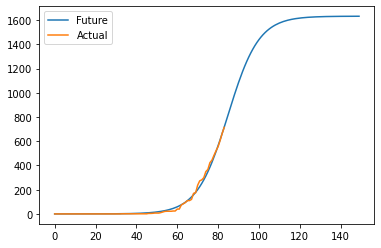

Afghanistan hopefully good


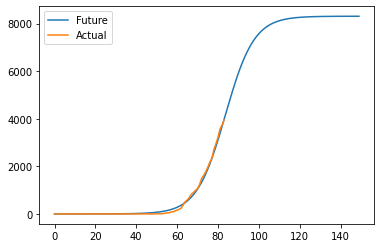

Alabama hopefully good


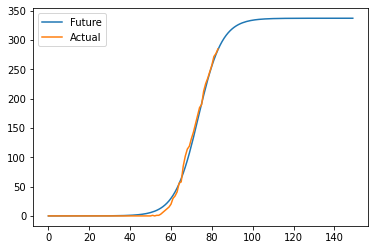

Alaska hopefully good


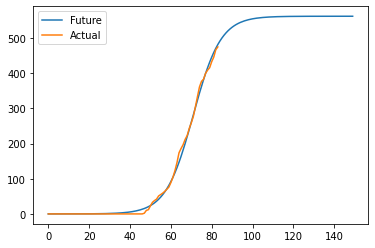

Albania hopefully good


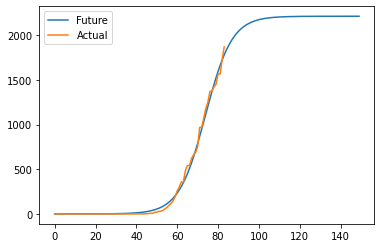

Alberta hopefully good


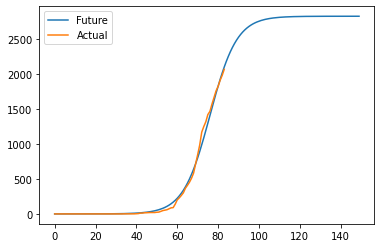

Algeria hopefully good


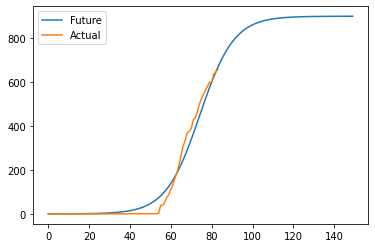

Andorra hopefully good


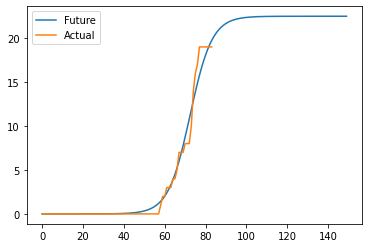

Angola hopefully good


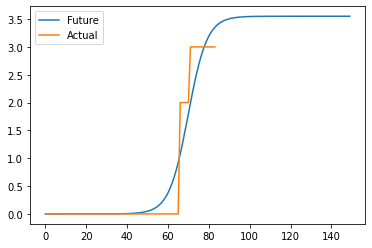

Anguilla hopefully good


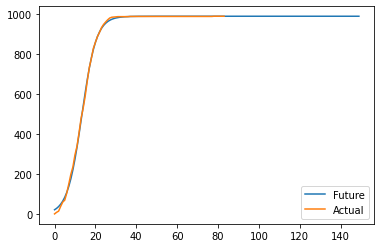

Anhui hopefully good


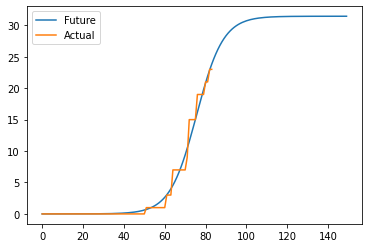

Antigua and Barbuda hopefully good


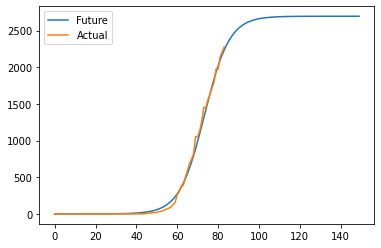

Argentina hopefully good


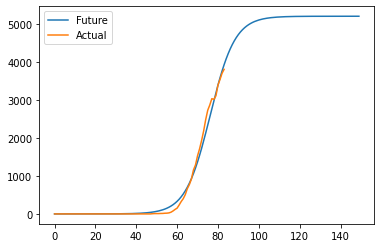

Arizona hopefully good


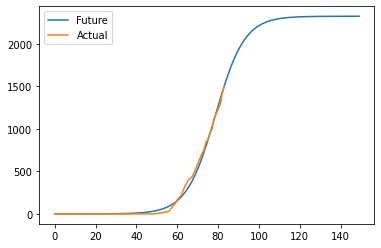

Arkansas hopefully good


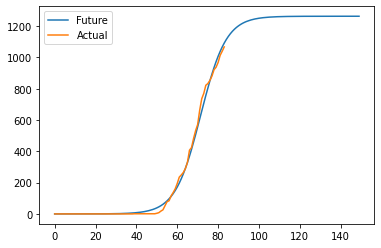

Armenia hopefully good


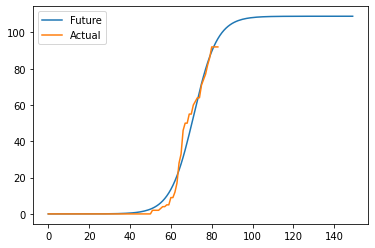

Aruba hopefully good


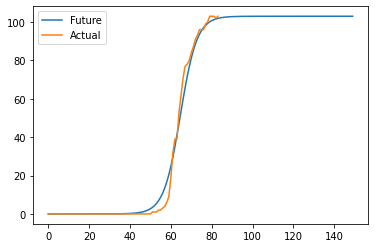

Australian Capital Territory hopefully good


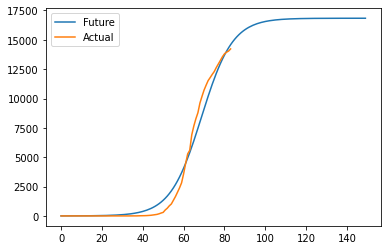

Austria hopefully good


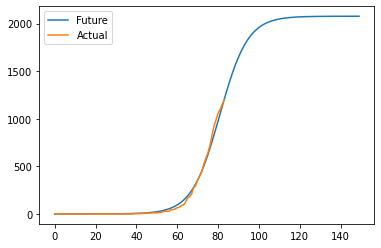

Azerbaijan hopefully good


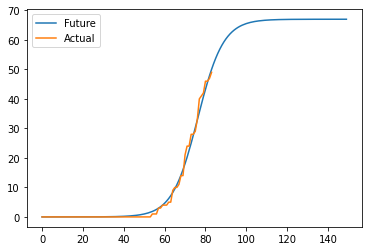

Bahamas hopefully good


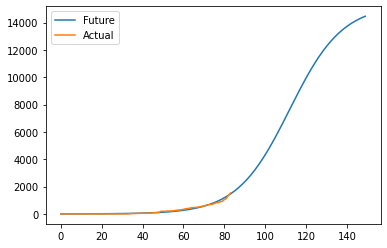

Bahrain hopefully good


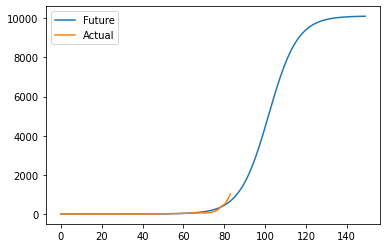

Bangladesh hopefully good


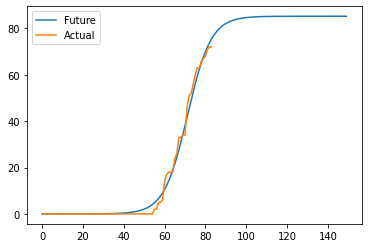

Barbados hopefully good


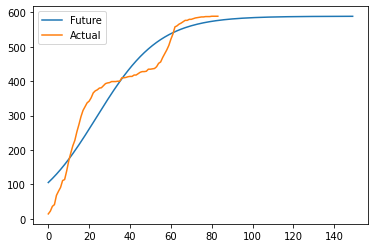

Beijing hopefully good


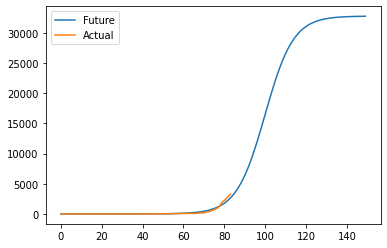

Belarus hopefully good


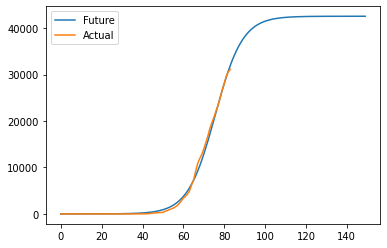

Belgium hopefully good


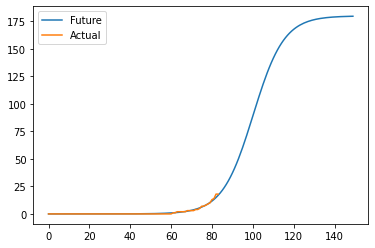

Belize hopefully good


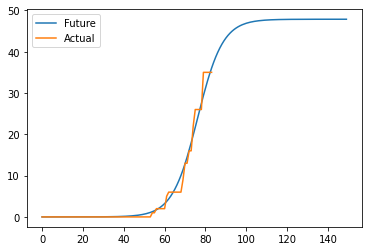

Benin hopefully good


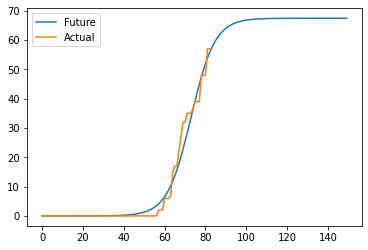

Bermuda hopefully good


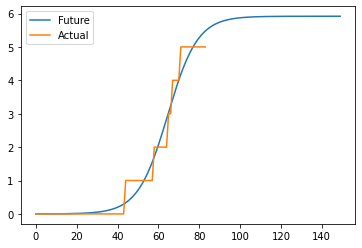

Bhutan hopefully good


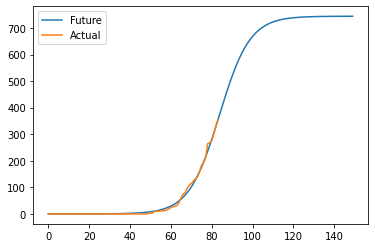

Bolivia hopefully good


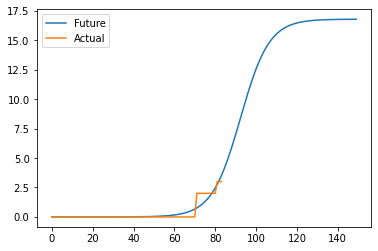

Bonaire, Sint Eustatius and Saba hopefully good


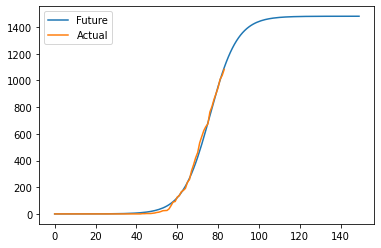

Bosnia and Herzegovina hopefully good


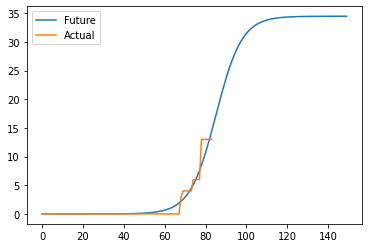

Botswana hopefully good


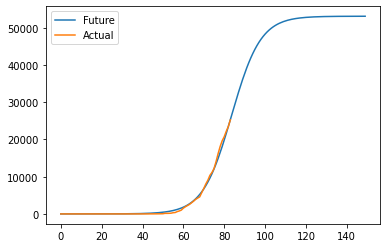

Brazil hopefully good


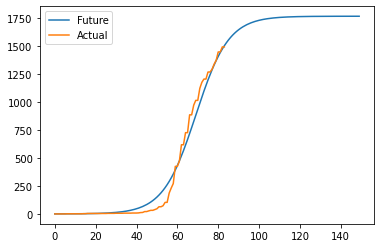

British Columbia hopefully good


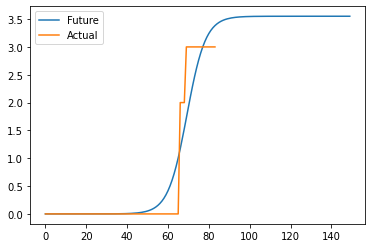

British Virgin Islands hopefully good


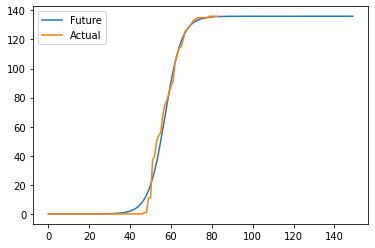

Brunei hopefully good


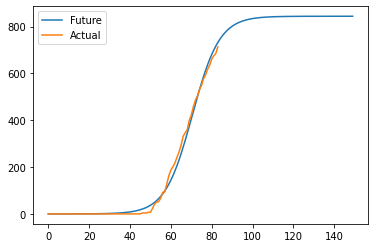

Bulgaria hopefully good


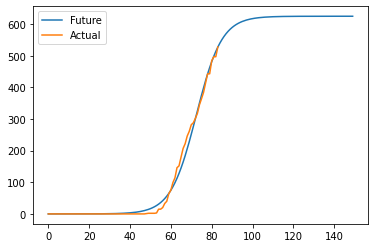

Burkina Faso hopefully good


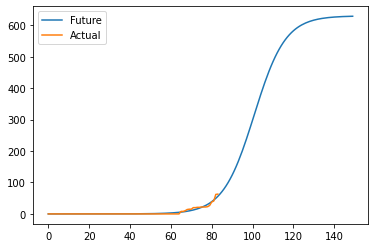

Burma hopefully good


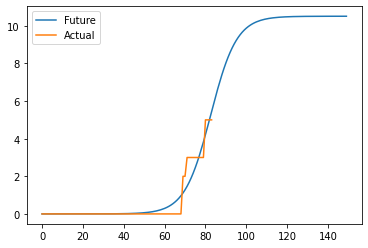

Burundi hopefully good


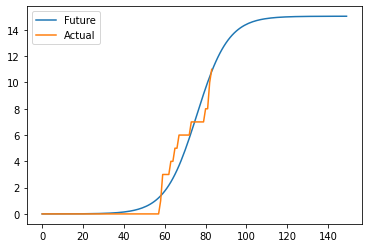

Cabo Verde hopefully good


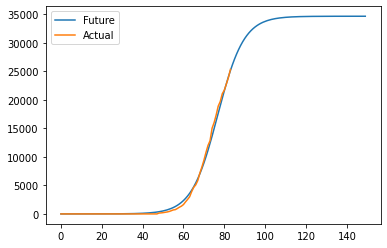

California hopefully good


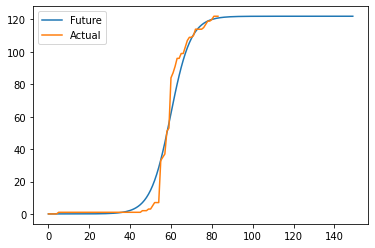

Cambodia hopefully good


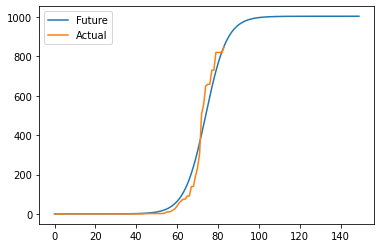

Cameroon hopefully good


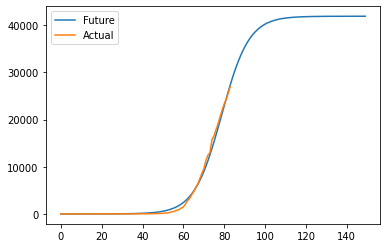

Canada hopefully good


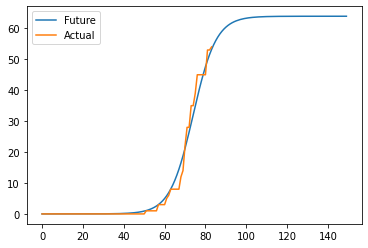

Cayman Islands hopefully good


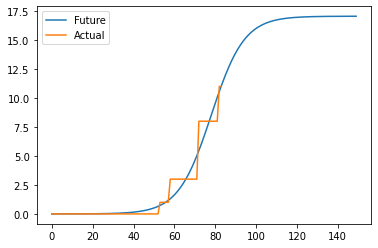

Central African Republic hopefully good


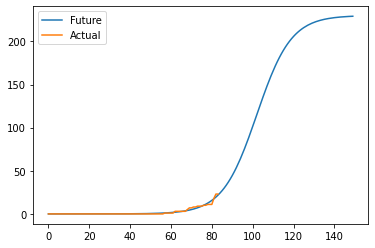

Chad hopefully good


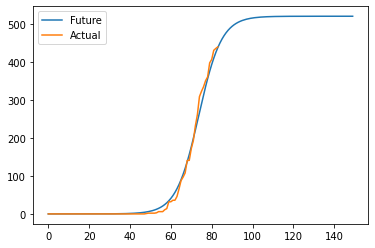

Channel Islands hopefully good


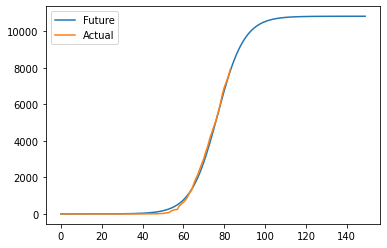

Chile hopefully good


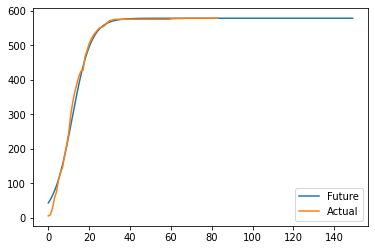

Chongqing hopefully good


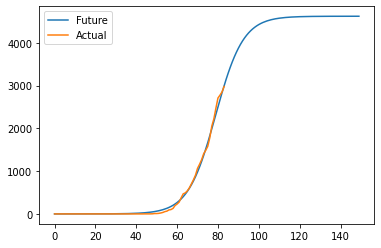

Colombia hopefully good


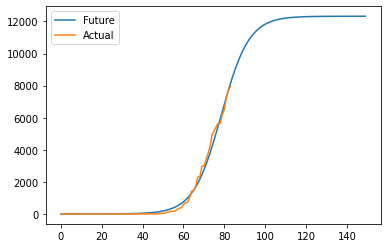

Colorado hopefully good


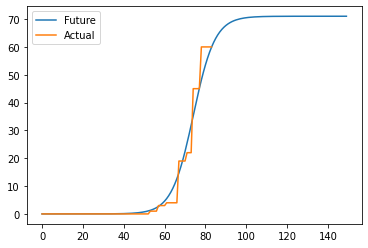

Congo (Brazzaville) hopefully good


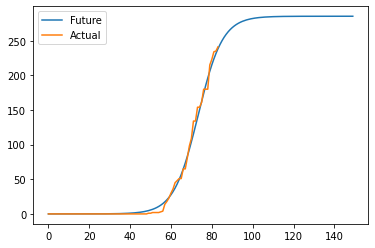

Congo (Kinshasa) hopefully good


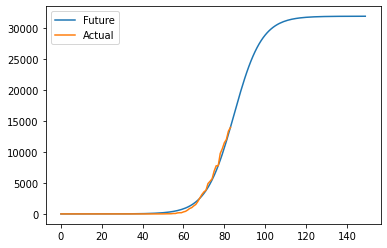

Connecticut hopefully good


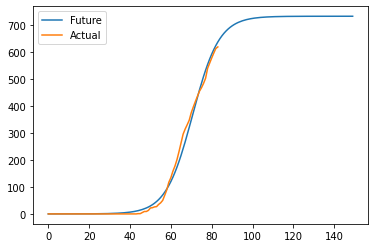

Costa Rica hopefully good


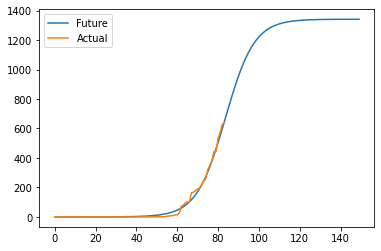

Cote d'Ivoire hopefully good


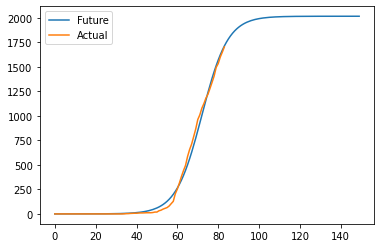

Croatia hopefully good


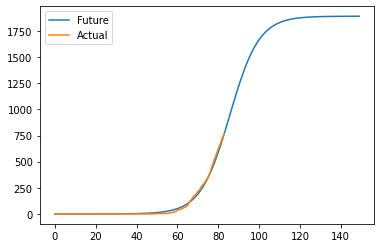

Cuba hopefully good


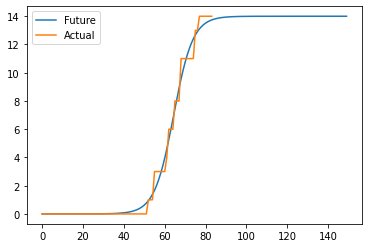

Curacao hopefully good


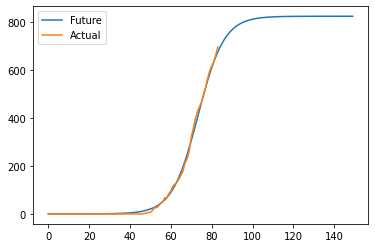

Cyprus hopefully good


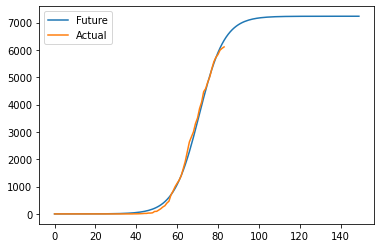

Czechia hopefully good


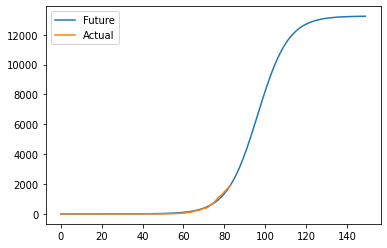

Delaware hopefully good


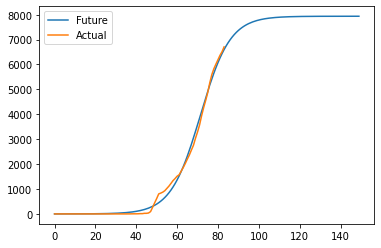

Denmark hopefully good


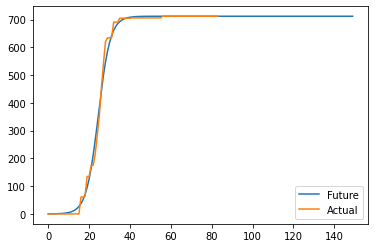

Diamond Princess hopefully good


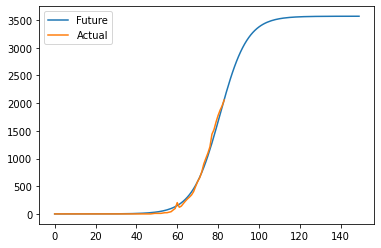

District of Columbia hopefully good


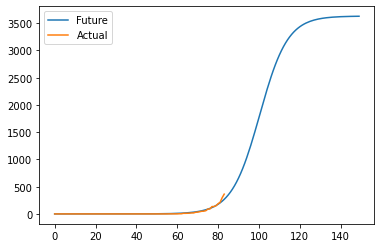

Djibouti hopefully good


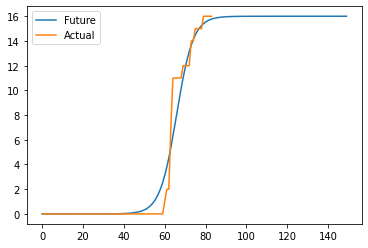

Dominica hopefully good


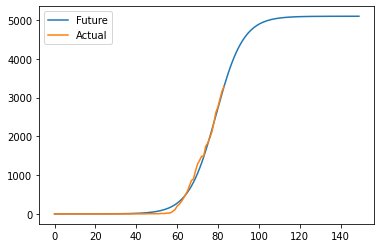

Dominican Republic hopefully good


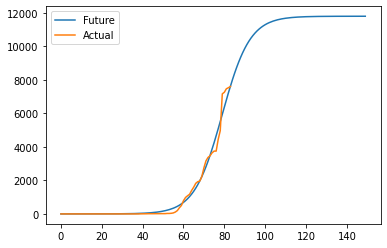

Ecuador hopefully good


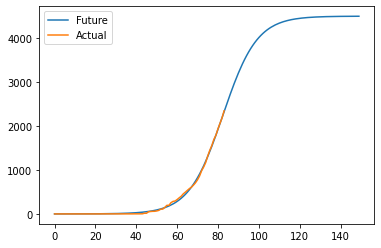

Egypt hopefully good


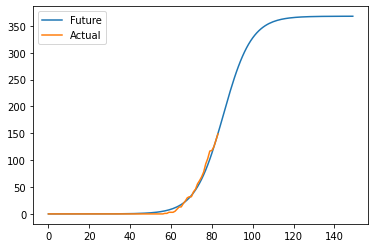

El Salvador hopefully good


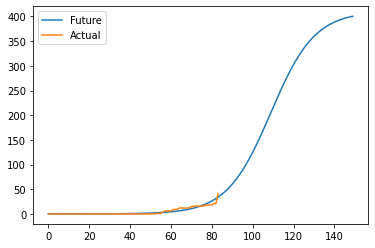

Equatorial Guinea hopefully good


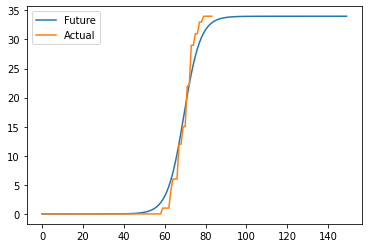

Eritrea hopefully good


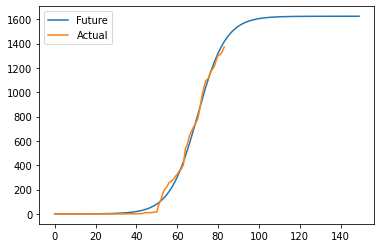

Estonia hopefully good


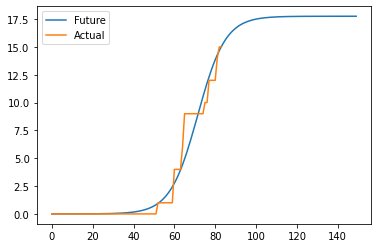

Eswatini hopefully good


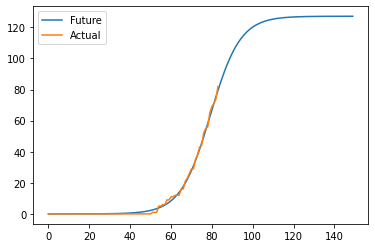

Ethiopia hopefully good


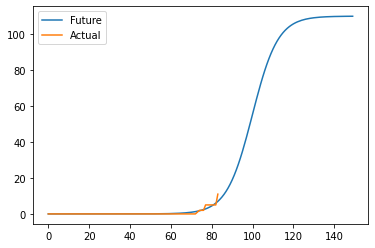

Falkland Islands (Malvinas) hopefully good


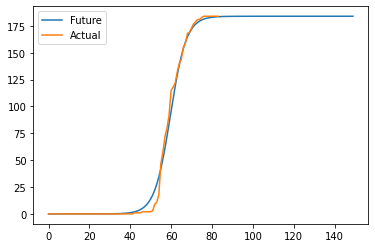

Faroe Islands hopefully good


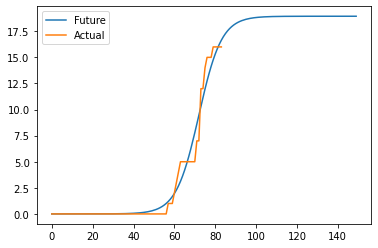

Fiji hopefully good


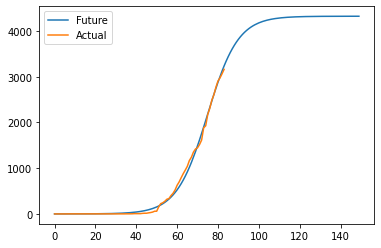

Finland hopefully good


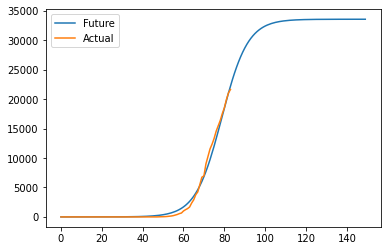

Florida hopefully good


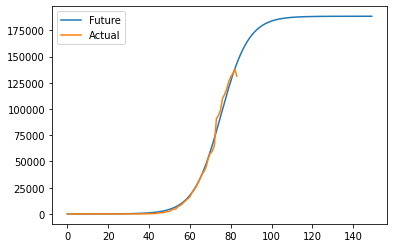

France hopefully good


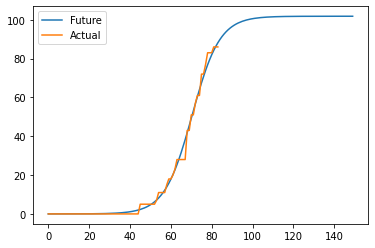

French Guiana hopefully good


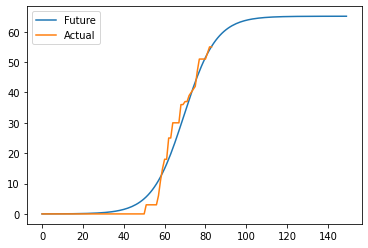

French Polynesia hopefully good


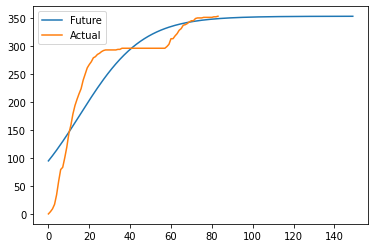

Fujian hopefully good


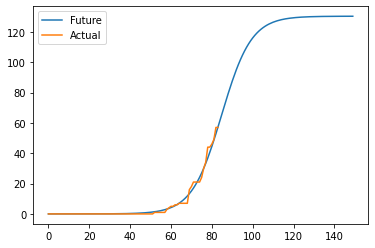

Gabon hopefully good


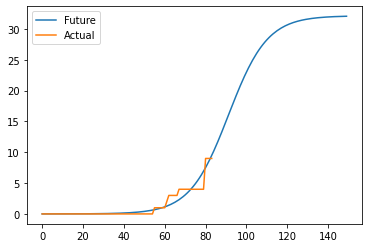

Gambia hopefully good


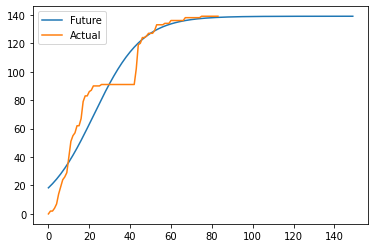

Gansu hopefully good


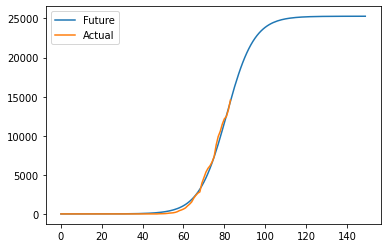

Georgia hopefully good


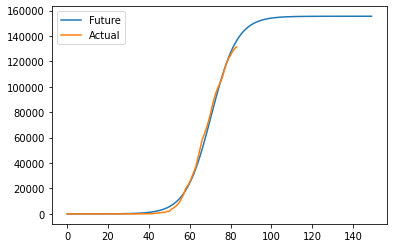

Germany hopefully good


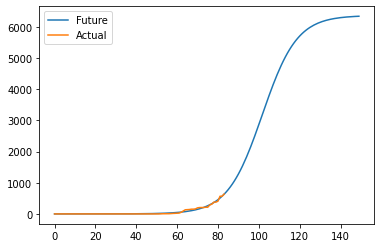

Ghana hopefully good


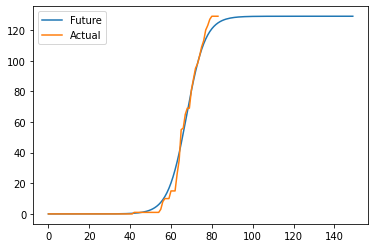

Gibraltar hopefully good


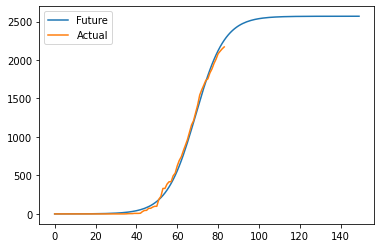

Greece hopefully good


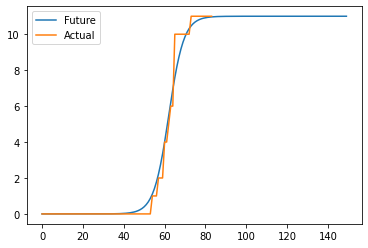

Greenland hopefully good


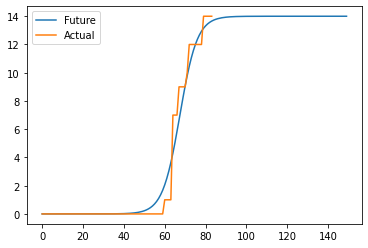

Grenada hopefully good


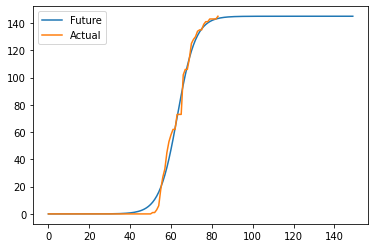

Guadeloupe hopefully good


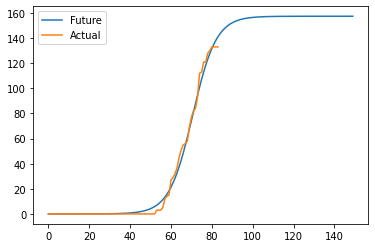

Guam hopefully good


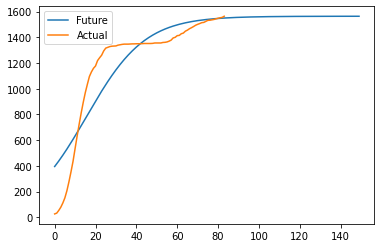

Guangdong hopefully good


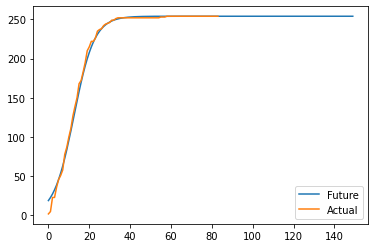

Guangxi hopefully good


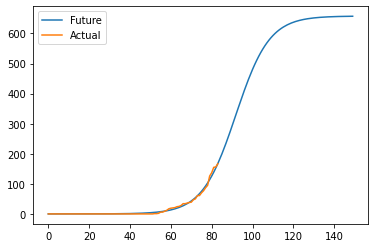

Guatemala hopefully good


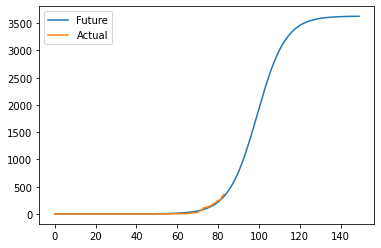

Guinea hopefully good


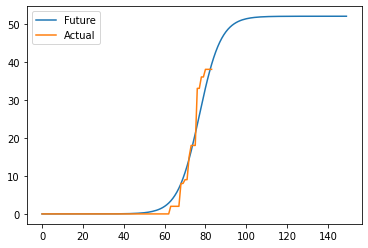

Guinea-Bissau hopefully good


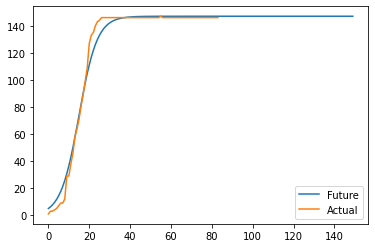

Guizhou hopefully good


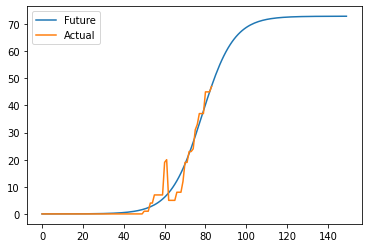

Guyana hopefully good


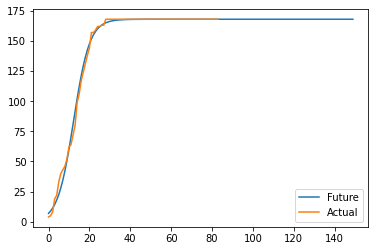

Hainan hopefully good


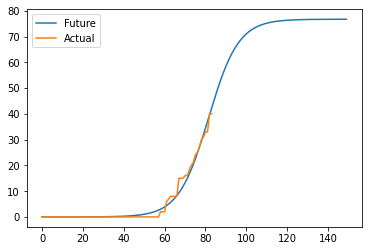

Haiti hopefully good


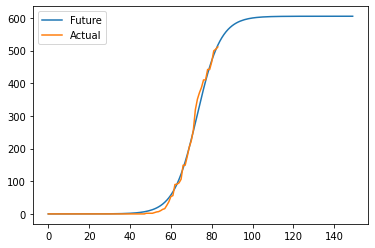

Hawaii hopefully good


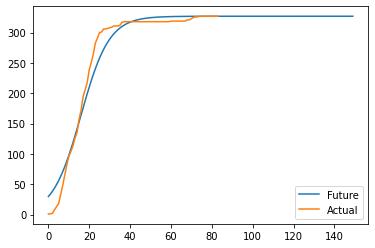

Hebei hopefully good


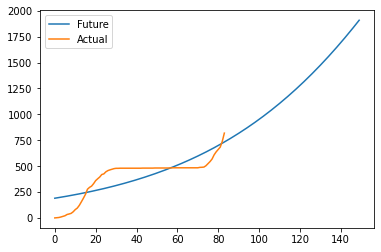

Heilongjiang hopefully good


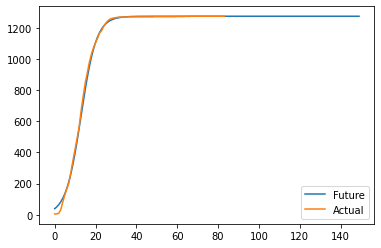

Henan hopefully good


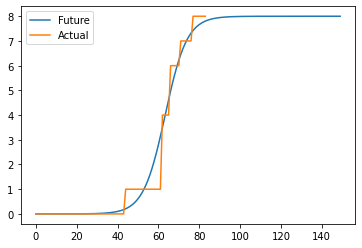

Holy See hopefully good


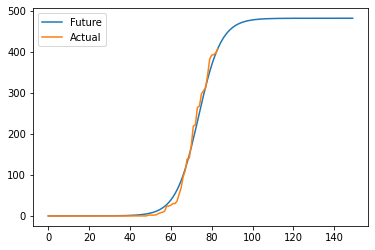

Honduras hopefully good


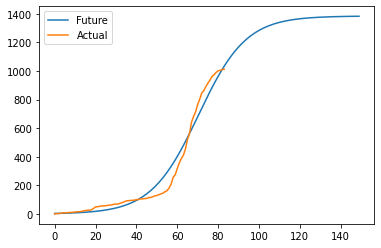

Hong Kong hopefully good


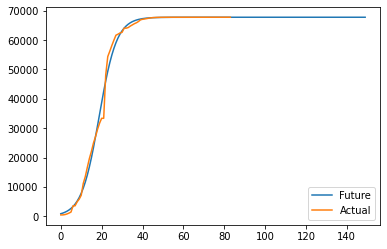

Hubei hopefully good


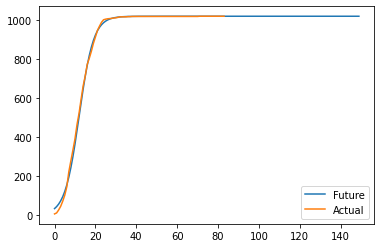

Hunan hopefully good


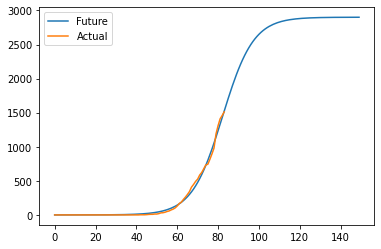

Hungary hopefully good


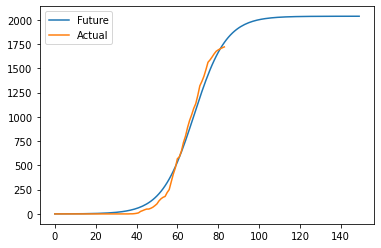

Iceland hopefully good


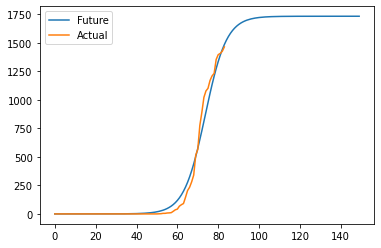

Idaho hopefully good


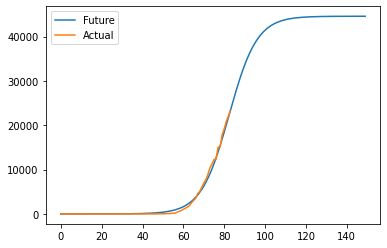

Illinois hopefully good


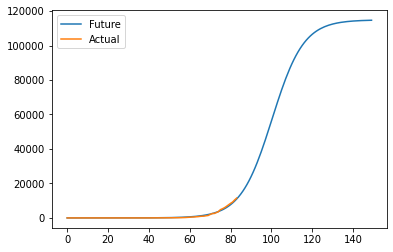

India hopefully good


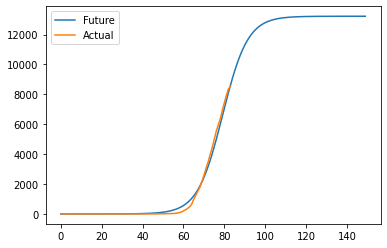

Indiana hopefully good


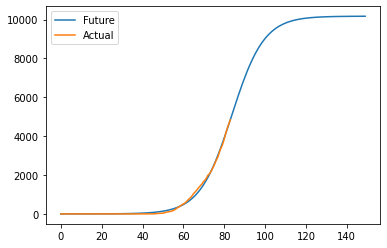

Indonesia hopefully good


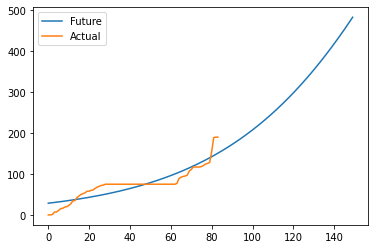

Inner Mongolia hopefully good


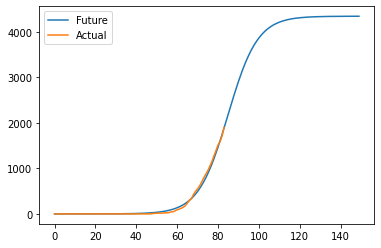

Iowa hopefully good


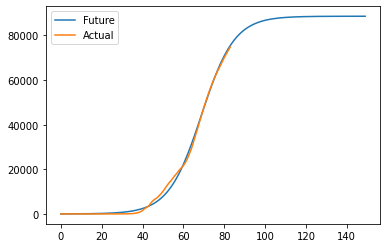

Iran hopefully good


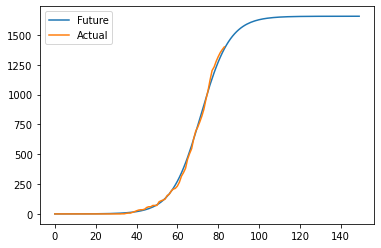

Iraq hopefully good


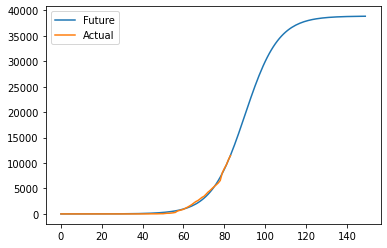

Ireland hopefully good


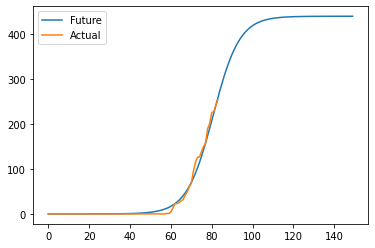

Isle of Man hopefully good


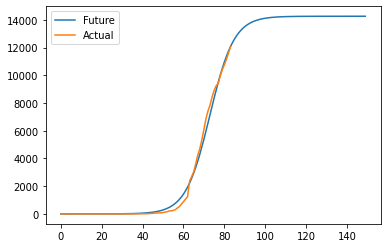

Israel hopefully good


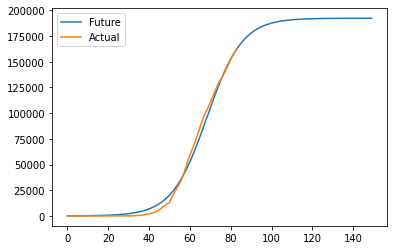

Italy hopefully good


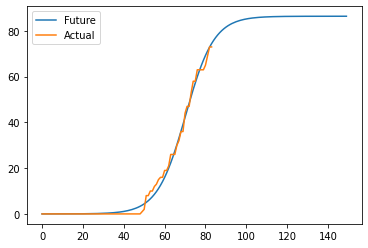

Jamaica hopefully good


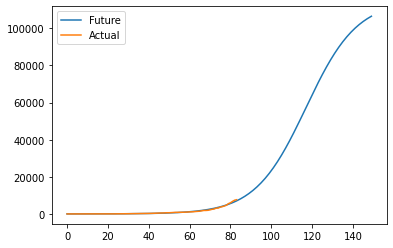

Japan hopefully good


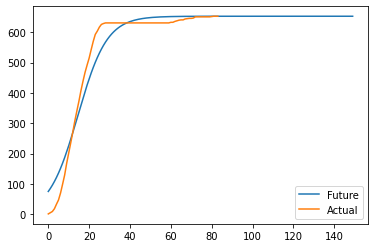

Jiangsu hopefully good


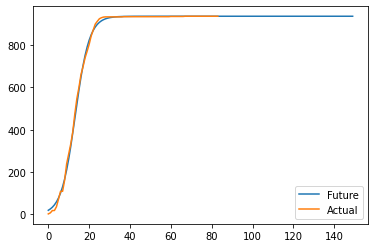

Jiangxi hopefully good


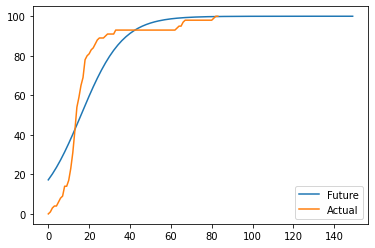

Jilin hopefully good


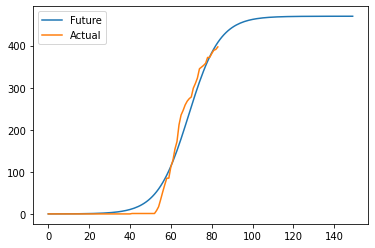

Jordan hopefully good


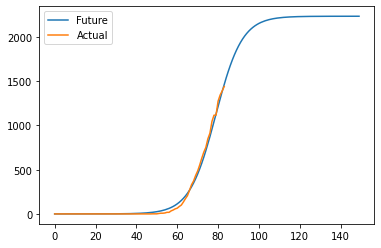

Kansas hopefully good


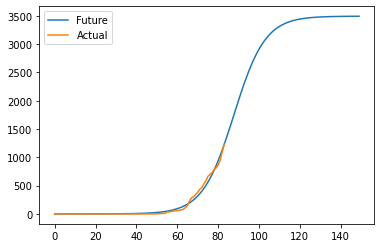

Kazakhstan hopefully good


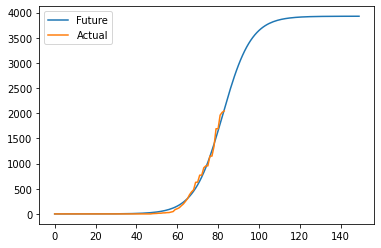

Kentucky hopefully good


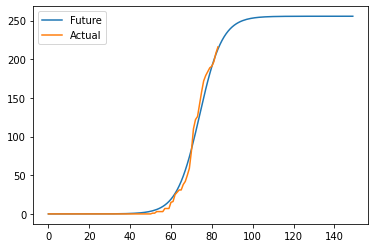

Kenya hopefully good


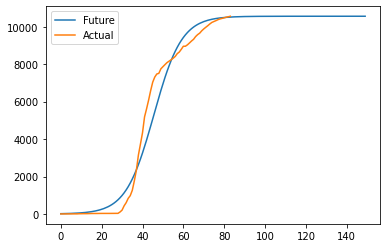

Korea, South hopefully good


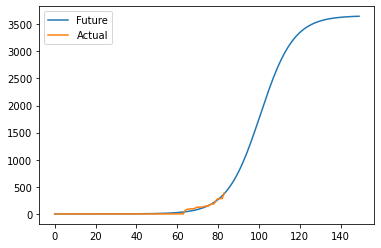

Kosovo hopefully good


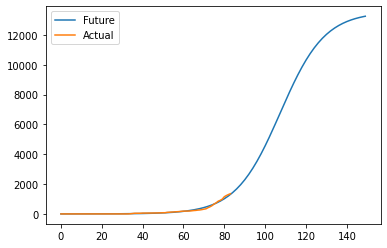

Kuwait hopefully good


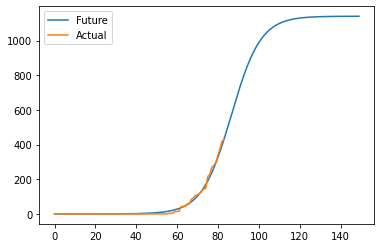

Kyrgyzstan hopefully good


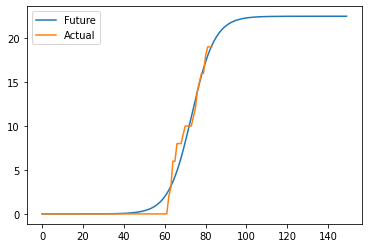

Laos hopefully good


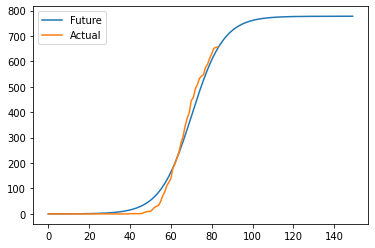

Latvia hopefully good


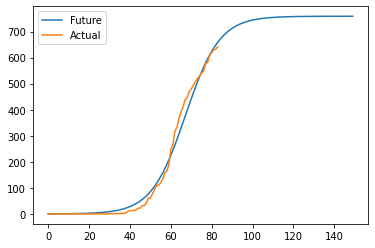

Lebanon hopefully good


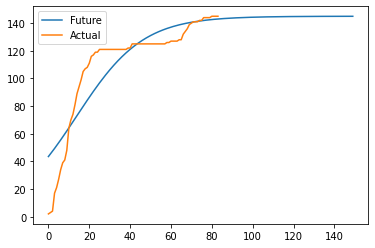

Liaoning hopefully good


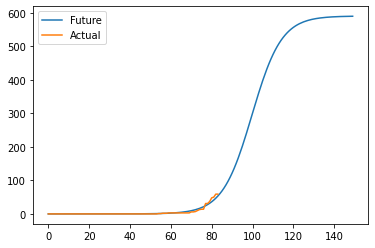

Liberia hopefully good


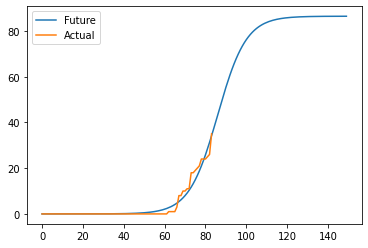

Libya hopefully good


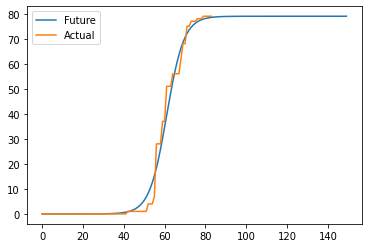

Liechtenstein hopefully good


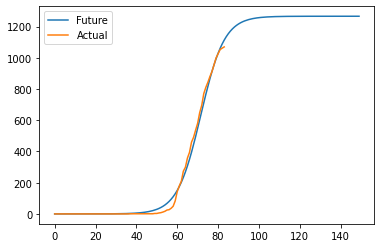

Lithuania hopefully good


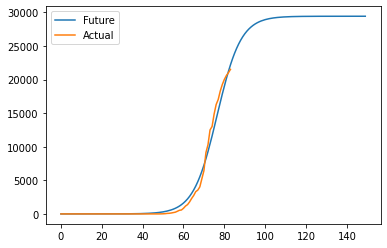

Louisiana hopefully good


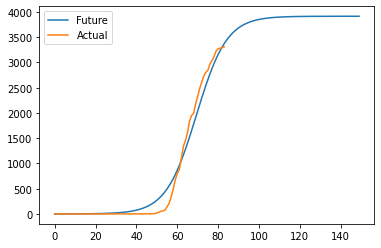

Luxembourg hopefully good


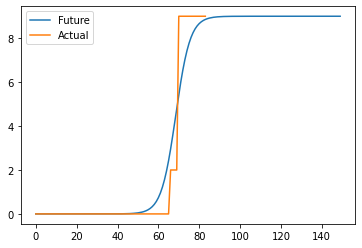

MS Zaandam hopefully good


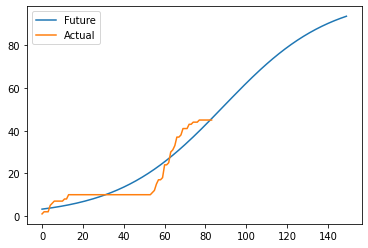

Macau hopefully good


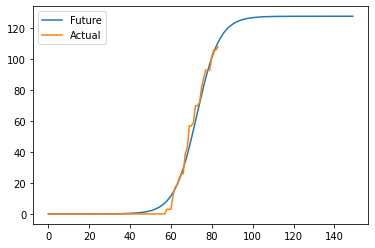

Madagascar hopefully good


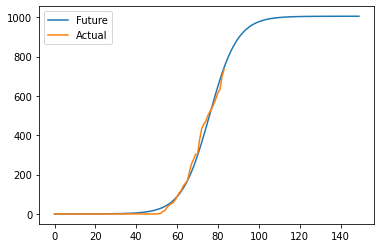

Maine hopefully good


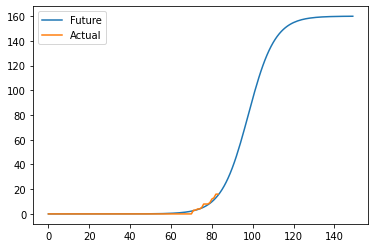

Malawi hopefully good


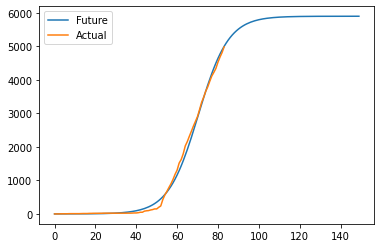

Malaysia hopefully good


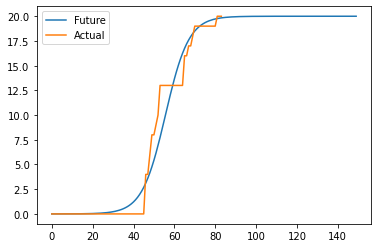

Maldives hopefully good


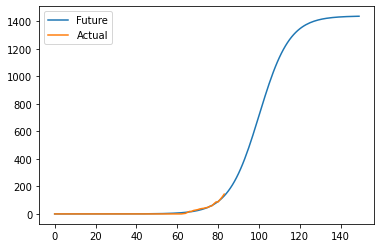

Mali hopefully good


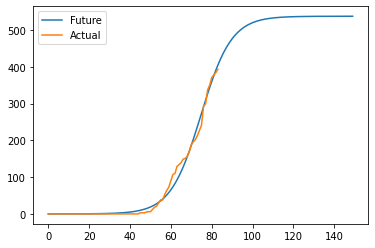

Malta hopefully good


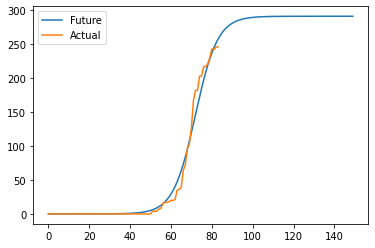

Manitoba hopefully good


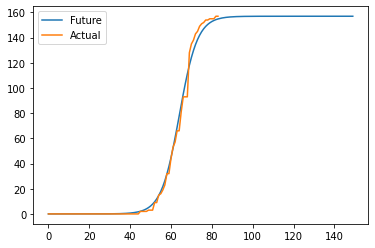

Martinique hopefully good


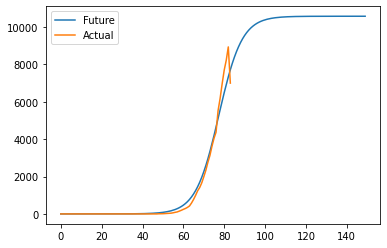

Maryland hopefully good


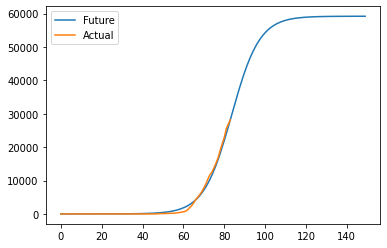

Massachusetts hopefully good


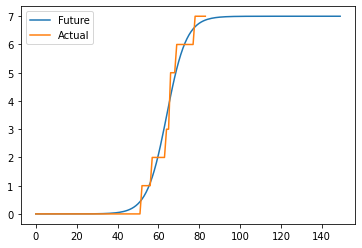

Mauritania hopefully good


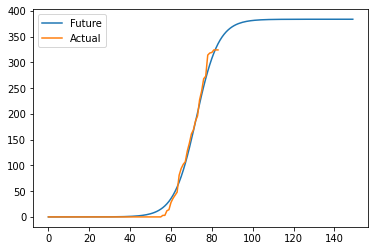

Mauritius hopefully good


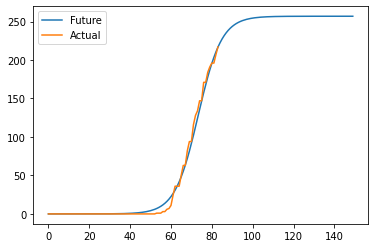

Mayotte hopefully good


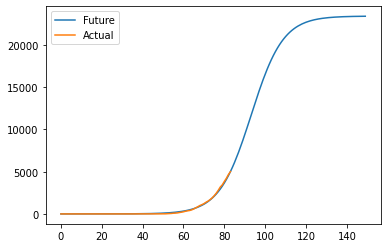

Mexico hopefully good


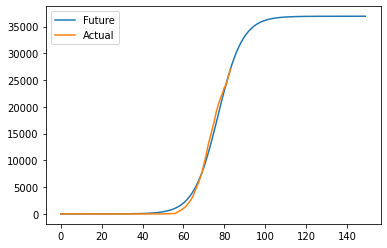

Michigan hopefully good


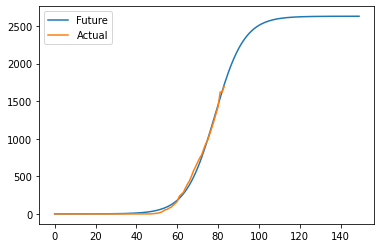

Minnesota hopefully good


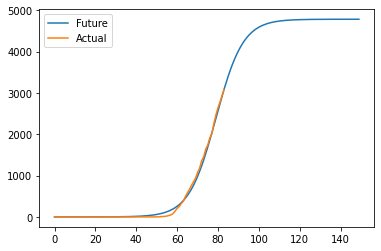

Mississippi hopefully good


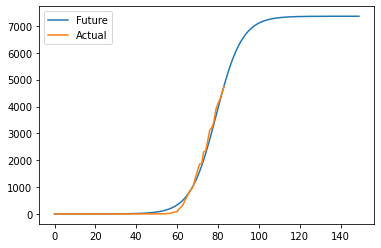

Missouri hopefully good


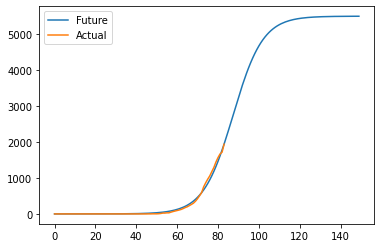

Moldova hopefully good


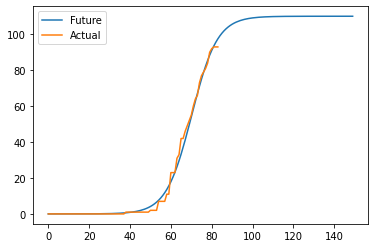

Monaco hopefully good


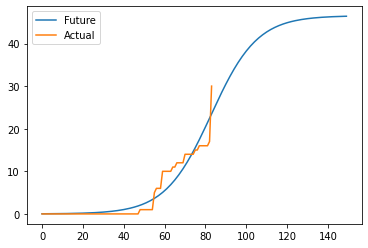

Mongolia hopefully good


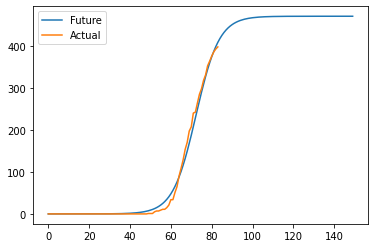

Montana hopefully good


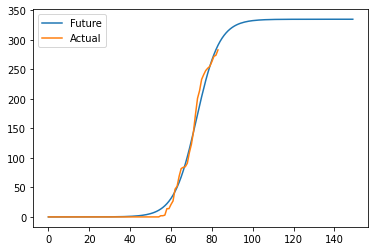

Montenegro hopefully good


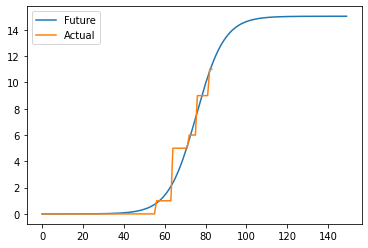

Montserrat hopefully good


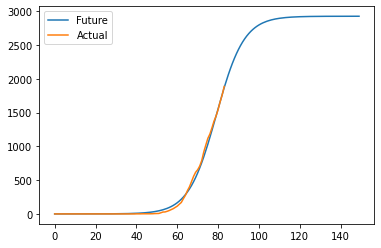

Morocco hopefully good


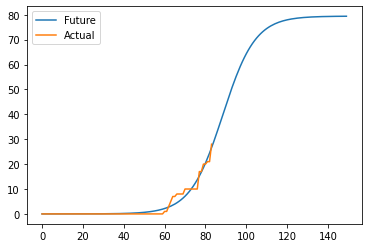

Mozambique hopefully good


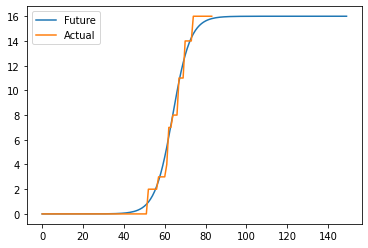

Namibia hopefully good


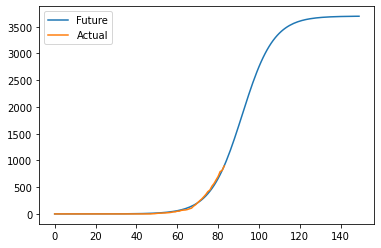

Nebraska hopefully good


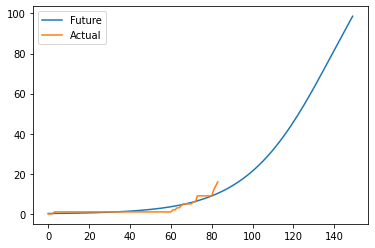

Nepal hopefully good


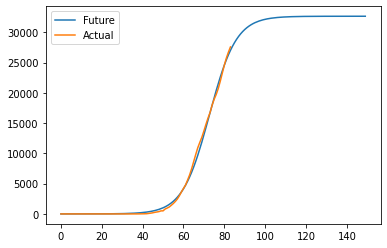

Netherlands hopefully good


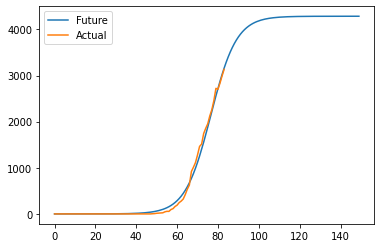

Nevada hopefully good


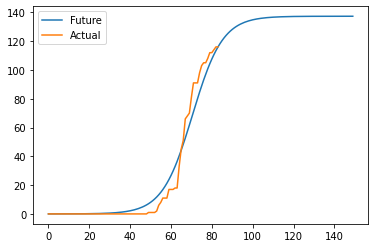

New Brunswick hopefully good


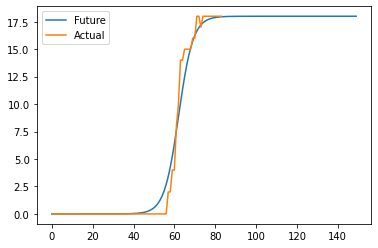

New Caledonia hopefully good


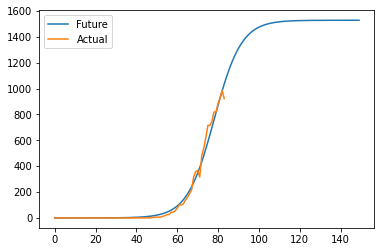

New Hampshire hopefully good


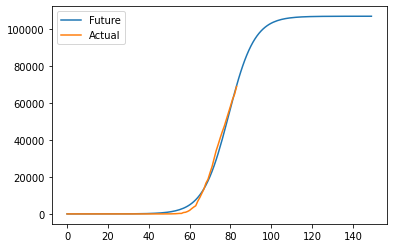

New Jersey hopefully good


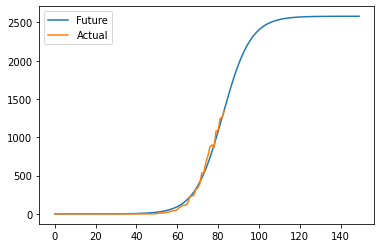

New Mexico hopefully good


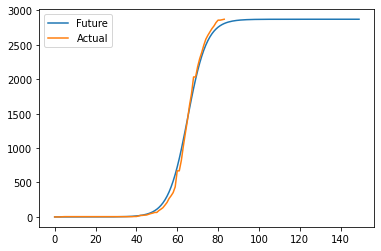

New South Wales hopefully good


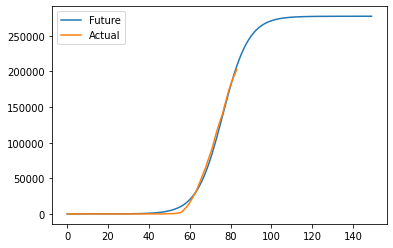

New York hopefully good


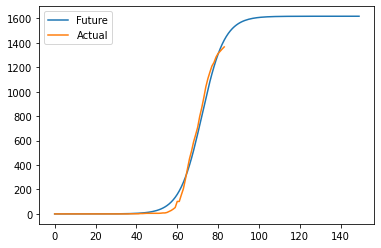

New Zealand hopefully good


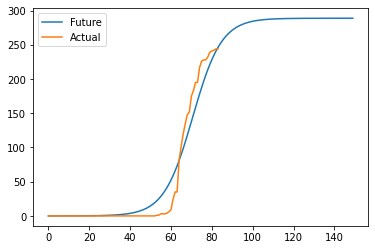

Newfoundland and Labrador hopefully good


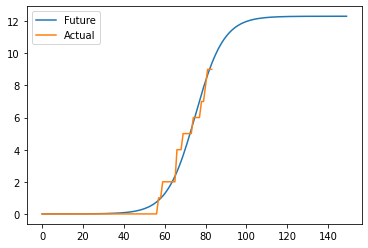

Nicaragua hopefully good


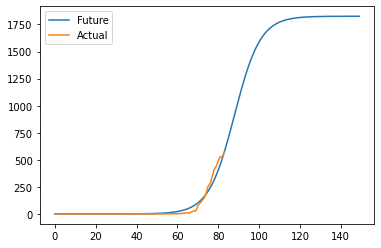

Niger hopefully good


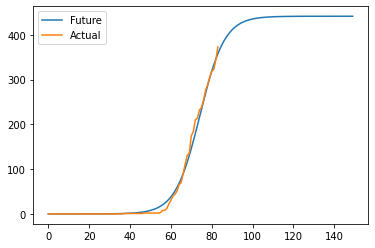

Nigeria hopefully good


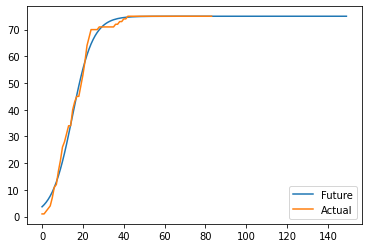

Ningxia hopefully good


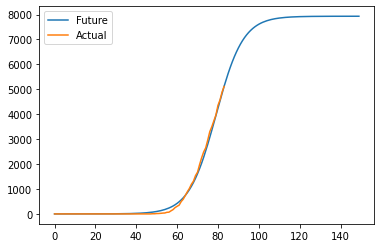

North Carolina hopefully good


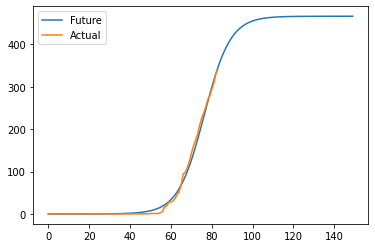

North Dakota hopefully good


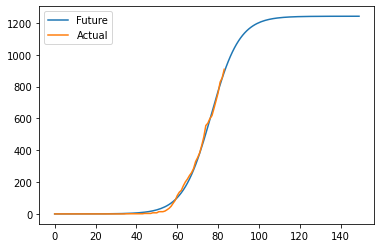

North Macedonia hopefully good


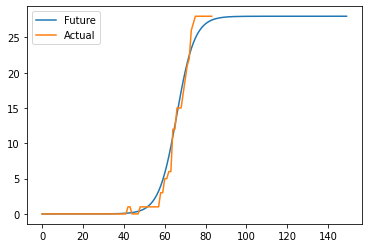

Northern Territory hopefully good


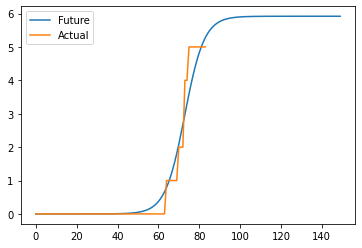

Northwest Territories hopefully good


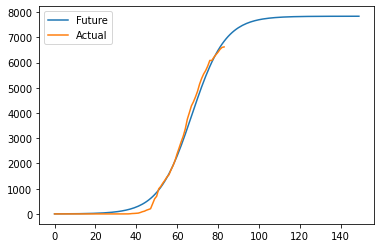

Norway hopefully good


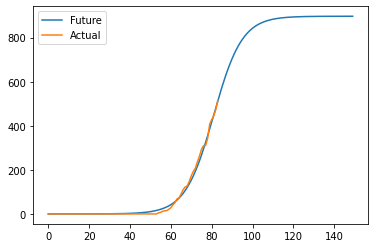

Nova Scotia hopefully good


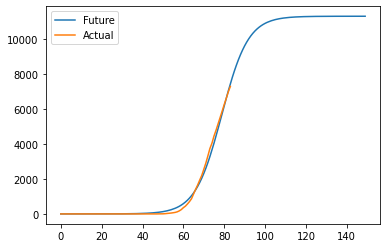

Ohio hopefully good


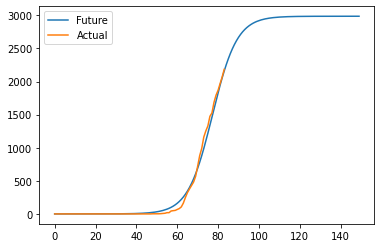

Oklahoma hopefully good


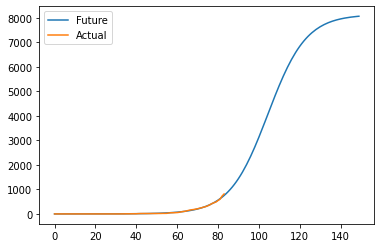

Oman hopefully good


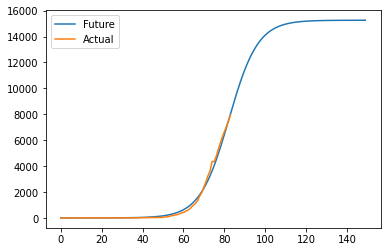

Ontario hopefully good


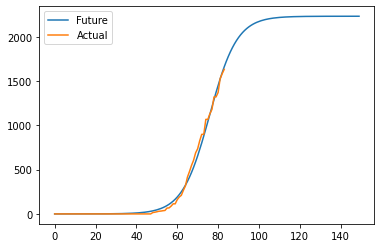

Oregon hopefully good


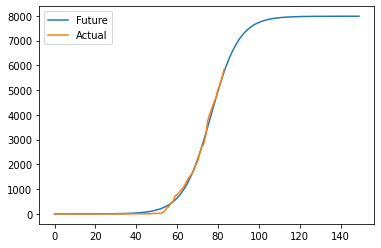

Pakistan hopefully good


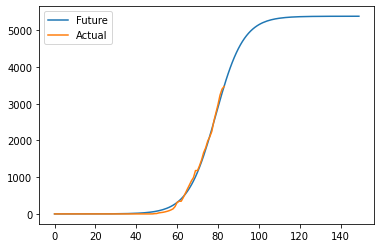

Panama hopefully good


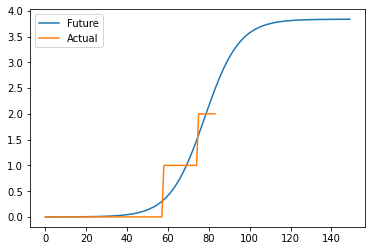

Papua New Guinea hopefully good


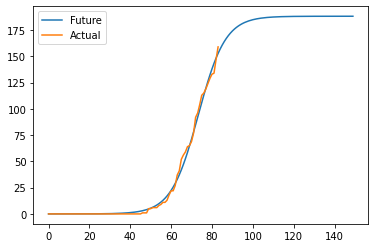

Paraguay hopefully good


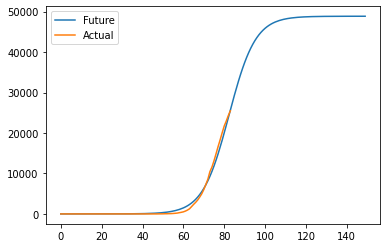

Pennsylvania hopefully good


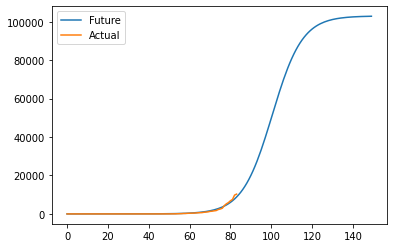

Peru hopefully good


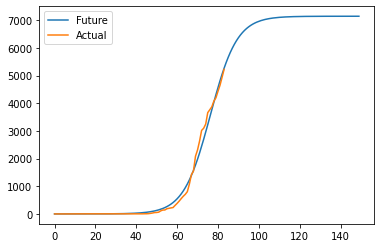

Philippines hopefully good


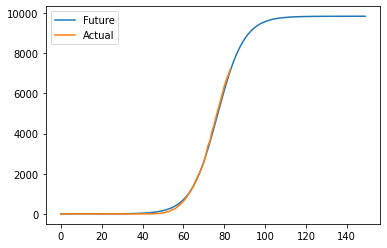

Poland hopefully good


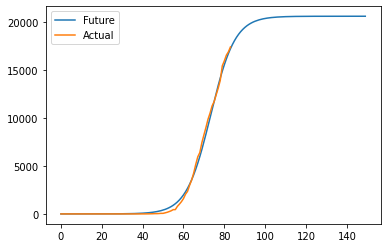

Portugal hopefully good


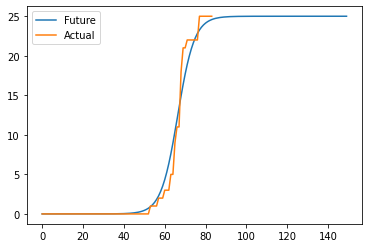

Prince Edward Island hopefully good


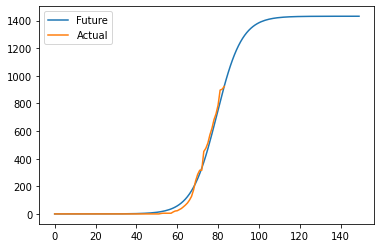

Puerto Rico hopefully good


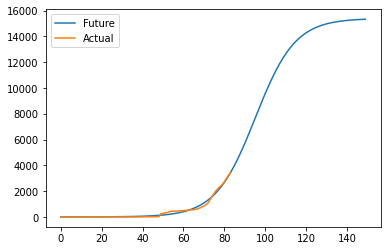

Qatar hopefully good


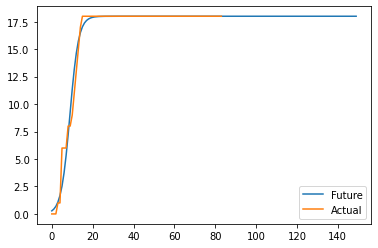

Qinghai hopefully good


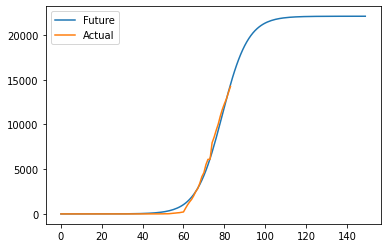

Quebec hopefully good


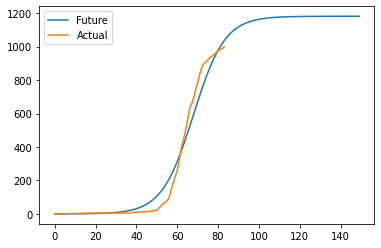

Queensland hopefully good


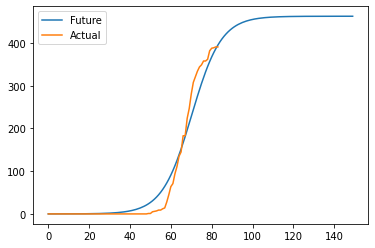

Reunion hopefully good


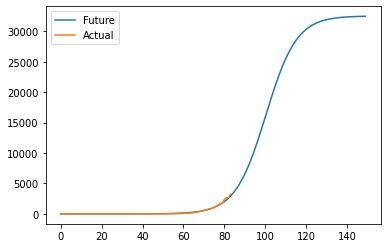

Rhode Island hopefully good


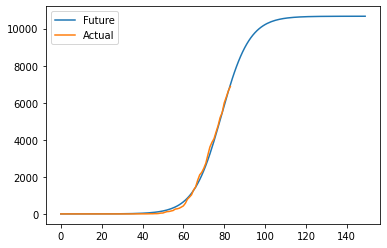

Romania hopefully good


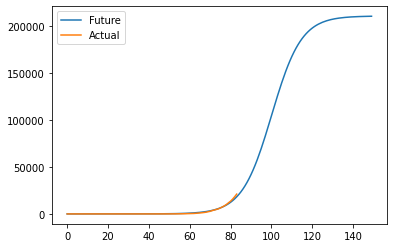

Russia hopefully good


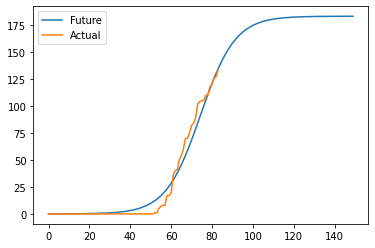

Rwanda hopefully good


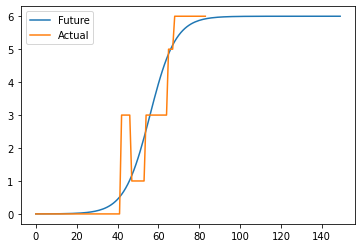

Saint Barthelemy hopefully good


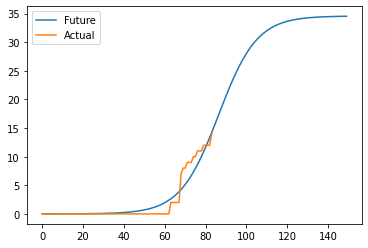

Saint Kitts and Nevis hopefully good


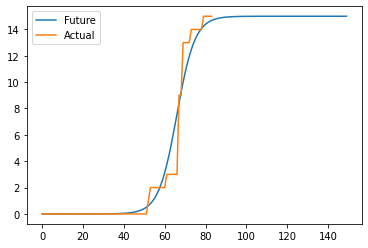

Saint Lucia hopefully good


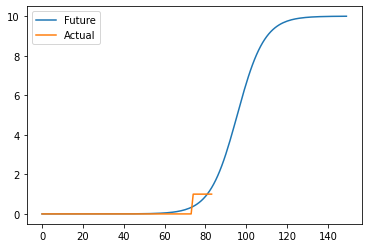

Saint Pierre and Miquelon hopefully good


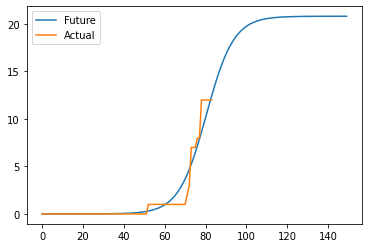

Saint Vincent and the Grenadines hopefully good


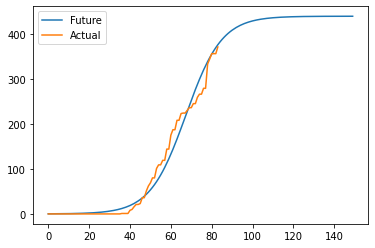

San Marino hopefully good


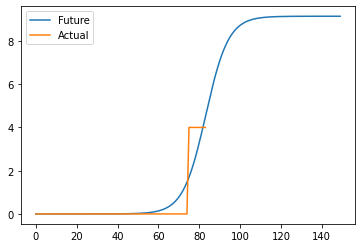

Sao Tome and Principe hopefully good


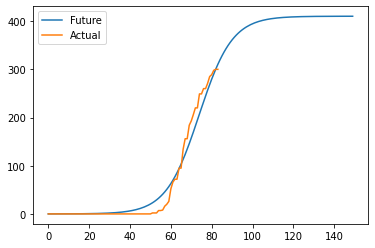

Saskatchewan hopefully good


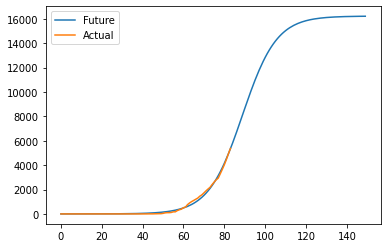

Saudi Arabia hopefully good


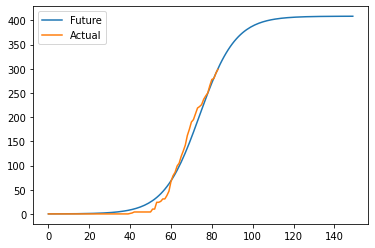

Senegal hopefully good


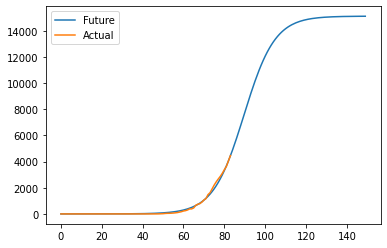

Serbia hopefully good


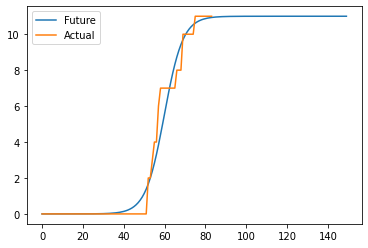

Seychelles hopefully good


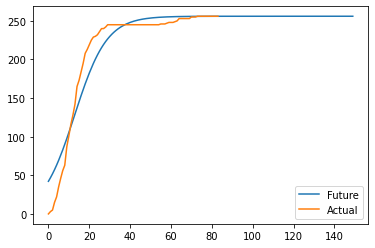

Shaanxi hopefully good


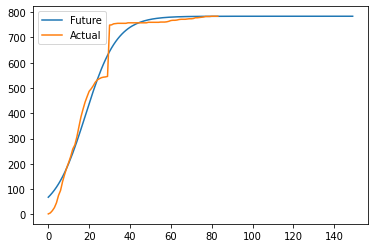

Shandong hopefully good


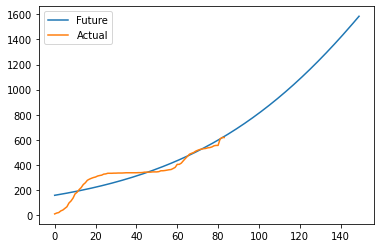

Shanghai hopefully good


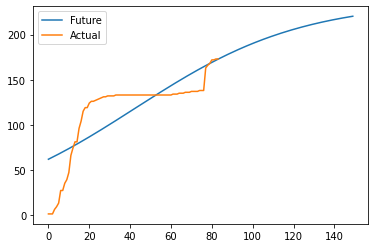

Shanxi hopefully good


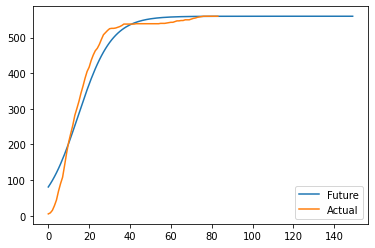

Sichuan hopefully good


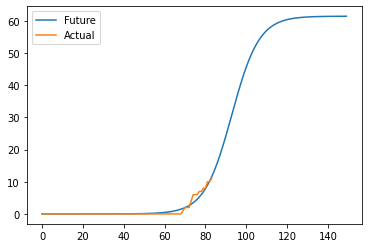

Sierra Leone hopefully good


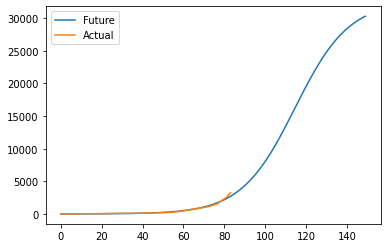

Singapore hopefully good


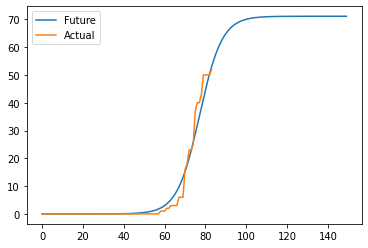

Sint Maarten hopefully good


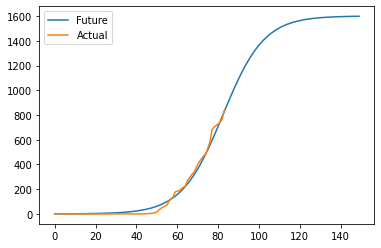

Slovakia hopefully good


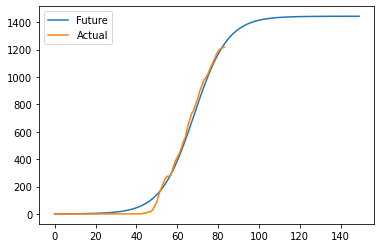

Slovenia hopefully good


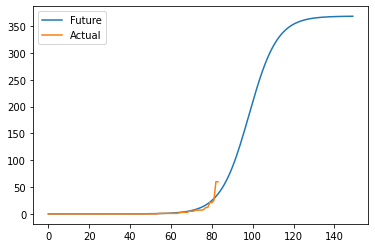

Somalia hopefully good


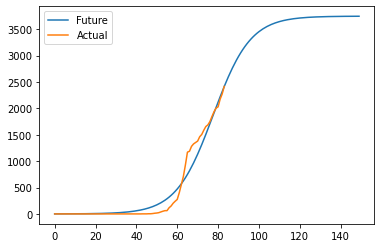

South Africa hopefully good


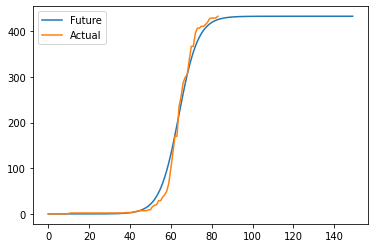

South Australia hopefully good


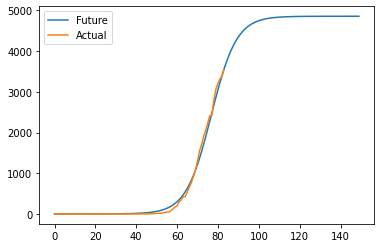

South Carolina hopefully good


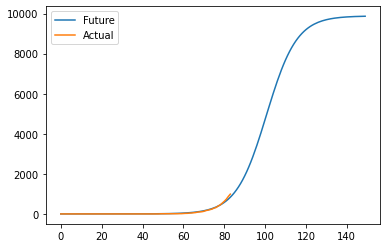

South Dakota hopefully good


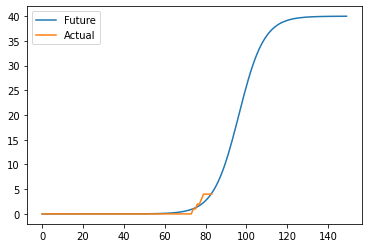

South Sudan hopefully good


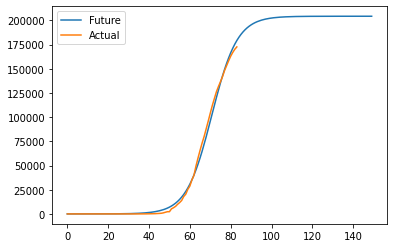

Spain hopefully good


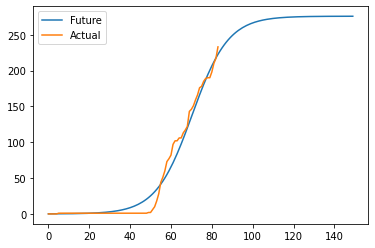

Sri Lanka hopefully good


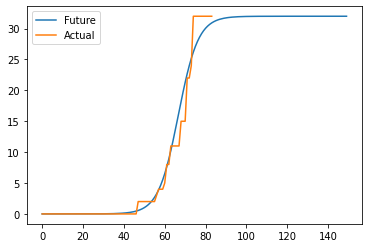

St Martin hopefully good


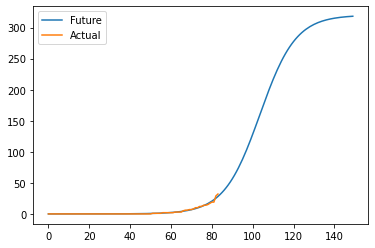

Sudan hopefully good


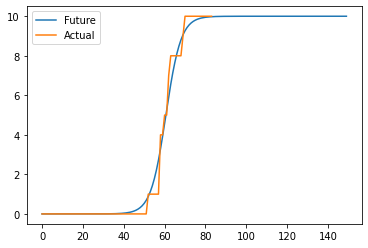

Suriname hopefully good


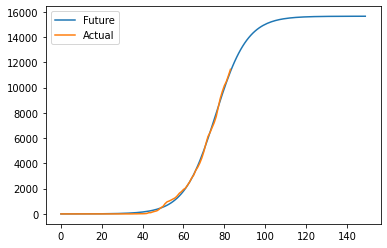

Sweden hopefully good


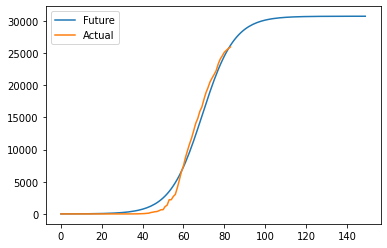

Switzerland hopefully good


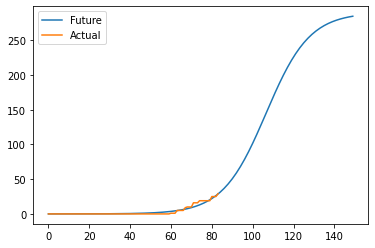

Syria hopefully good


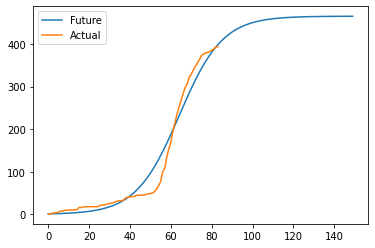

Taiwan* hopefully good


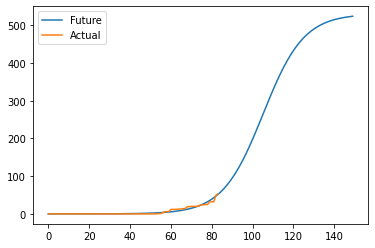

Tanzania hopefully good


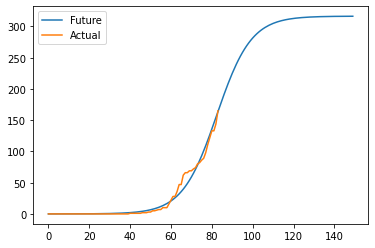

Tasmania hopefully good


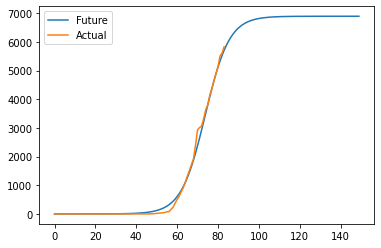

Tennessee hopefully good


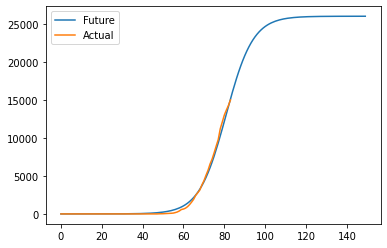

Texas hopefully good


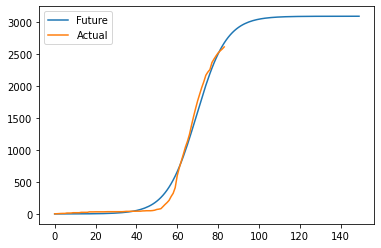

Thailand hopefully good


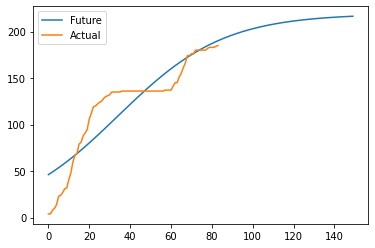

Tianjin hopefully good


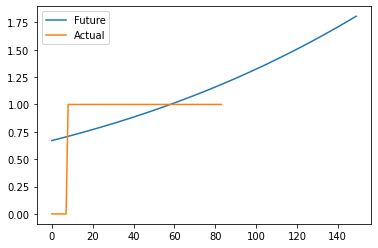

Tibet hopefully good


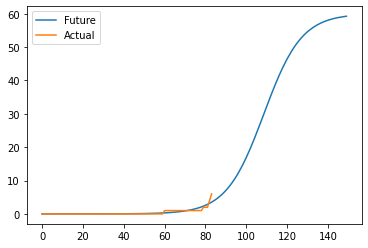

Timor-Leste hopefully good


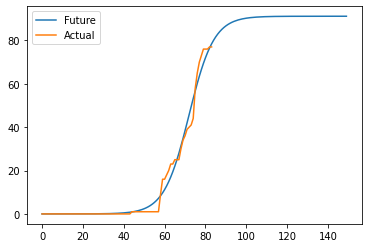

Togo hopefully good


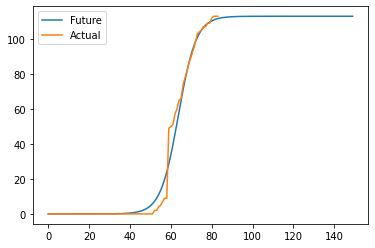

Trinidad and Tobago hopefully good


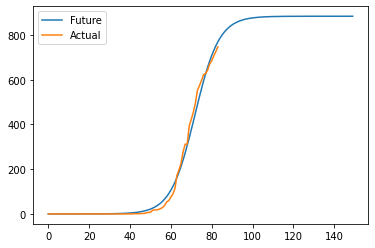

Tunisia hopefully good


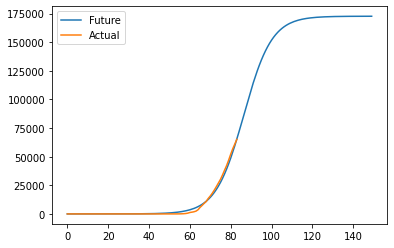

Turkey hopefully good


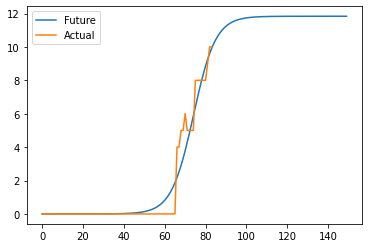

Turks and Caicos Islands hopefully good


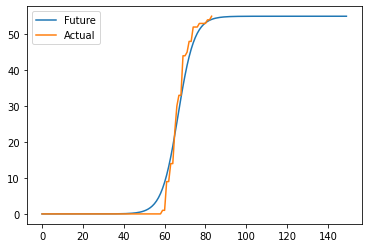

Uganda hopefully good


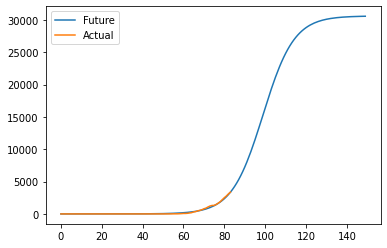

Ukraine hopefully good


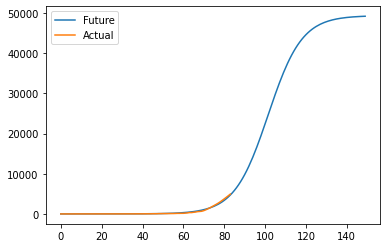

United Arab Emirates hopefully good


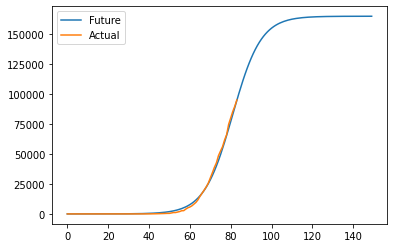

United Kingdom hopefully good


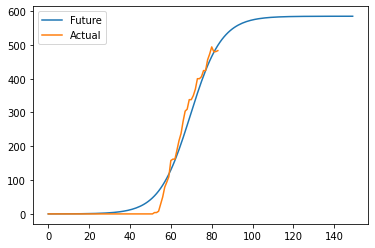

Uruguay hopefully good


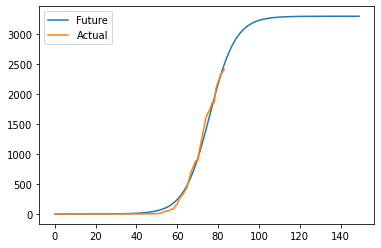

Utah hopefully good


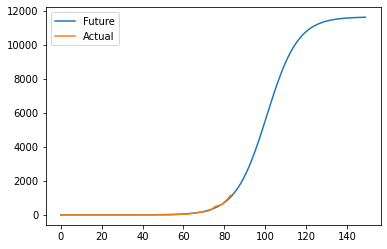

Uzbekistan hopefully good


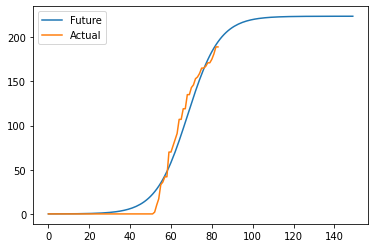

Venezuela hopefully good


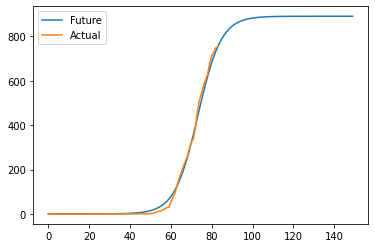

Vermont hopefully good


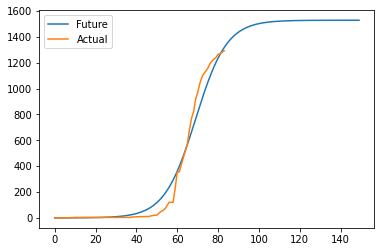

Victoria hopefully good


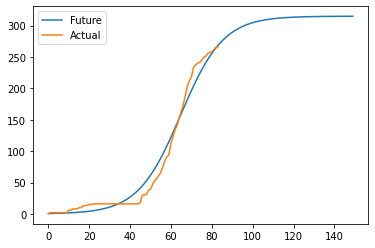

Vietnam hopefully good


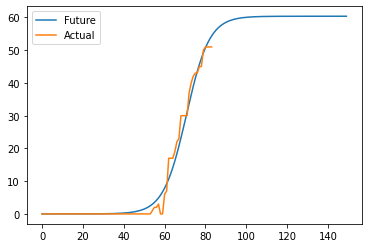

Virgin Islands hopefully good


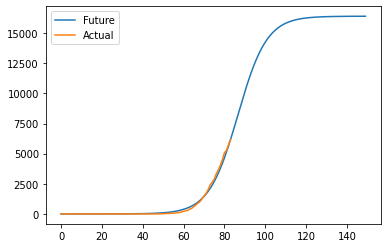

Virginia hopefully good


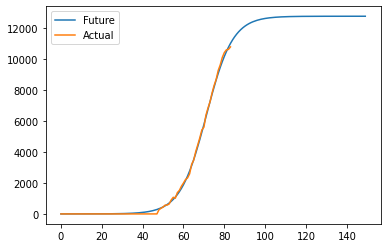

Washington hopefully good


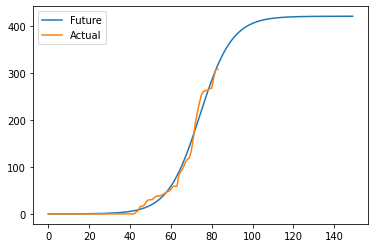

West Bank and Gaza hopefully good


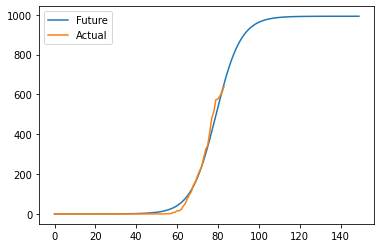

West Virginia hopefully good


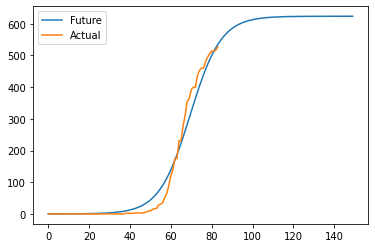

Western Australia hopefully good


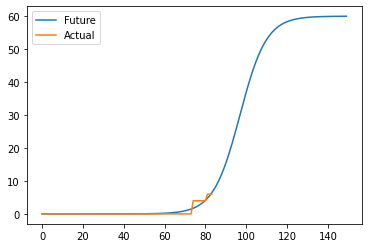

Western Sahara hopefully good


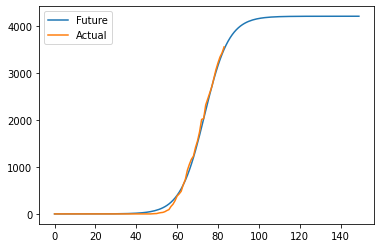

Wisconsin hopefully good


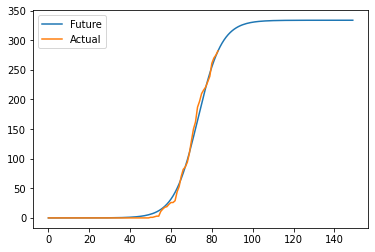

Wyoming hopefully good


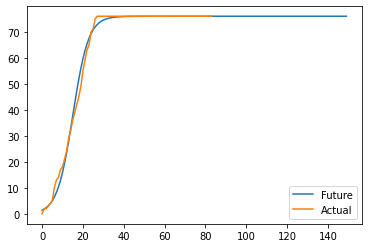

Xinjiang hopefully good


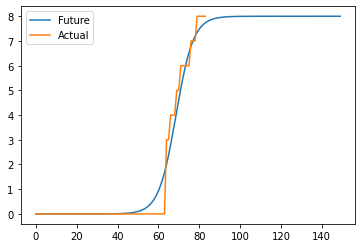

Yukon hopefully good


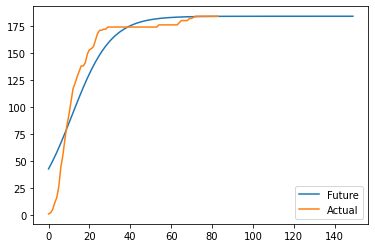

Yunnan hopefully good


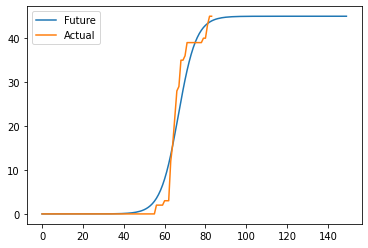

Zambia hopefully good


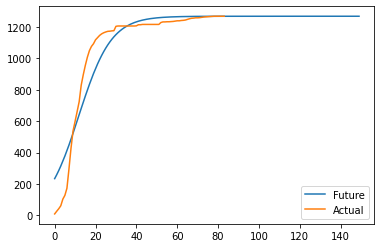

Zhejiang hopefully good


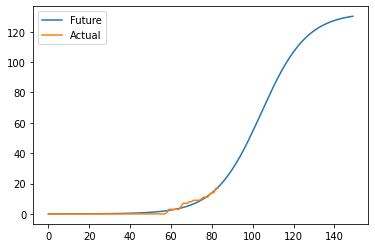

Zimbabwe hopefully good


In [17]:
# Cases
for cname in cnames:
    try:
        norm, model = casemodels[cname]
        x = list(xbycountry[cname])
        del plt

        import matplotlib.pyplot as plt

        plotx = np.array([[float(i)] for i in xbycountry[cname]])
        ploty_actual = np.array([i[0] for i in ybycountry[cname]])
#         ploty_model = model.predict(np.array([[float(i)] for i in xbycountry[cname]]))*norm

        futureplotx = np.array(list([i] for i in range(150)))
#         futurex = np.array([[float(i)] + x[1:] for i in range(150)])
        futurey = model.predict(futureplotx)*norm

        plt.plot(futureplotx, futurey, label="Future")
        plt.plot(plotx, ploty_actual, label="Actual")
        # plt.plot(plotx, ploty_model, label="Model")

        plt.legend()
        plt.show()
        print(f"{cname} hopefully good")
    except KeyError:
        print(f"{cname} is not a country")

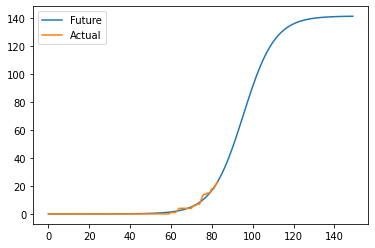

Afghanistan hopefully good


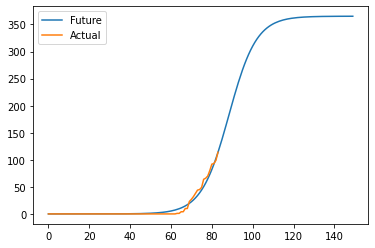

Alabama hopefully good


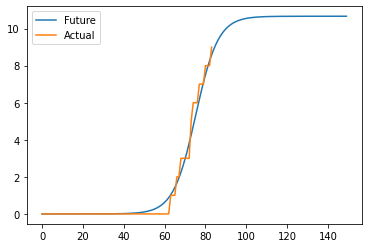

Alaska hopefully good


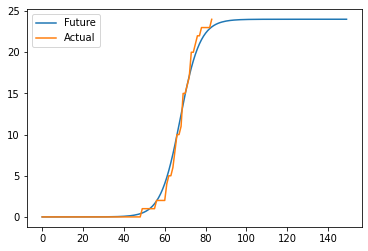

Albania hopefully good


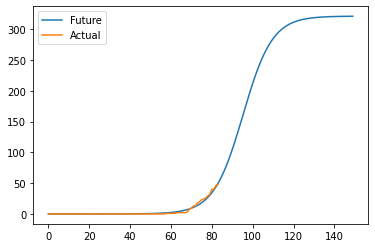

Alberta hopefully good


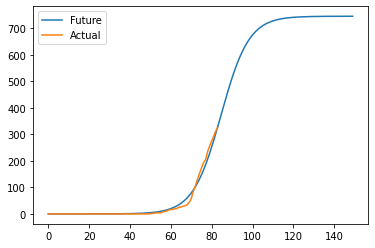

Algeria hopefully good


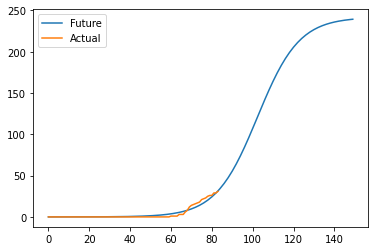

Andorra hopefully good


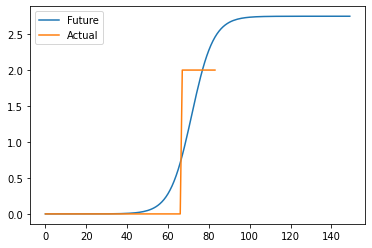

Angola hopefully good


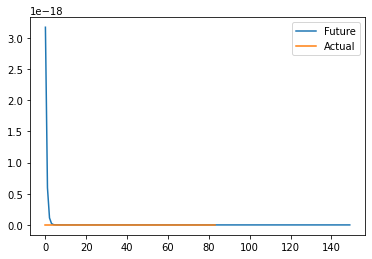

Anguilla hopefully good


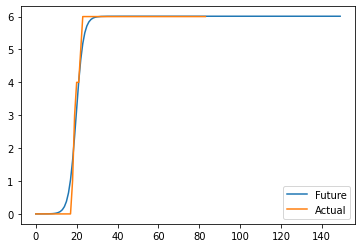

Anhui hopefully good


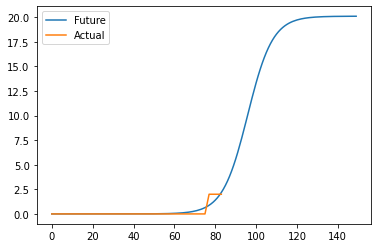

Antigua and Barbuda hopefully good


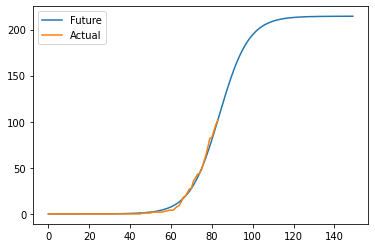

Argentina hopefully good


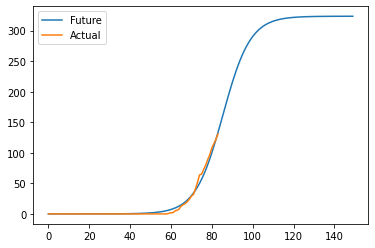

Arizona hopefully good


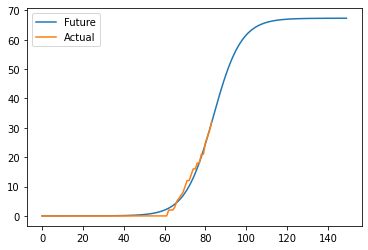

Arkansas hopefully good


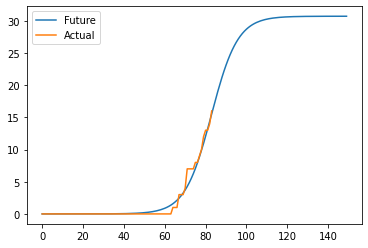

Armenia hopefully good


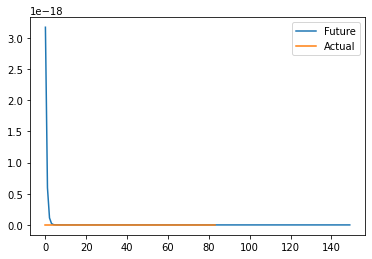

Aruba hopefully good


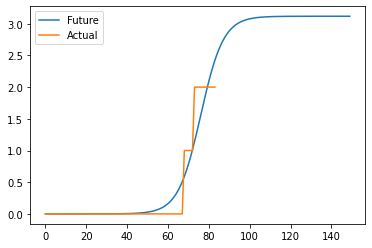

Australian Capital Territory hopefully good


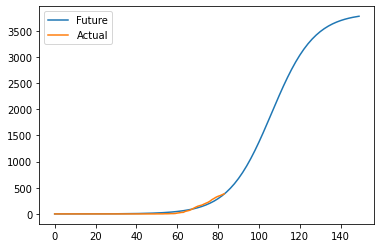

Austria hopefully good


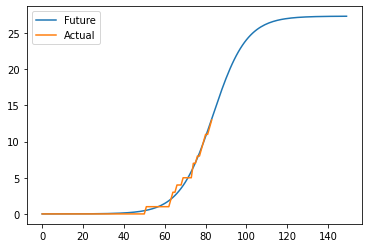

Azerbaijan hopefully good


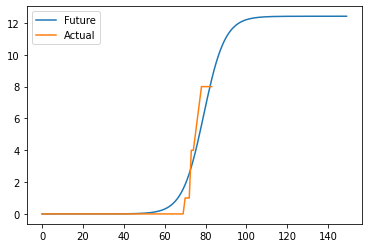

Bahamas hopefully good


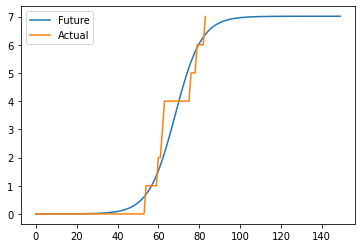

Bahrain hopefully good


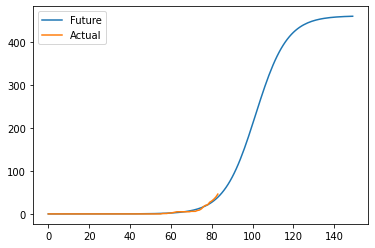

Bangladesh hopefully good


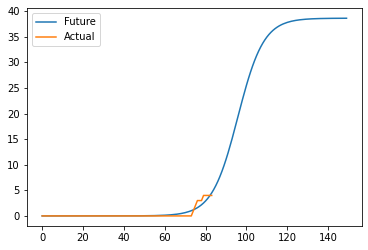

Barbados hopefully good


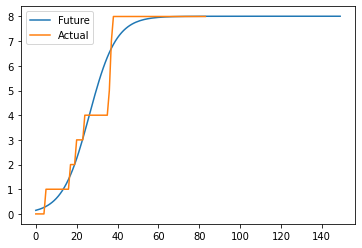

Beijing hopefully good


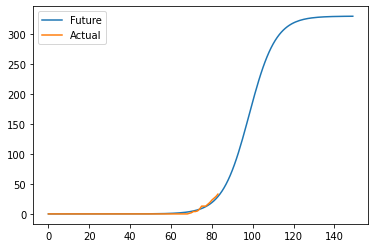

Belarus hopefully good


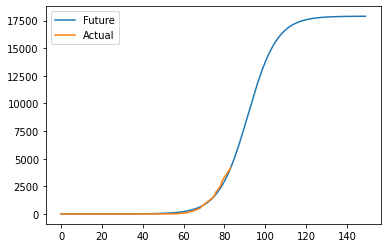

Belgium hopefully good


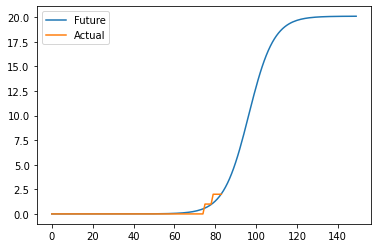

Belize hopefully good


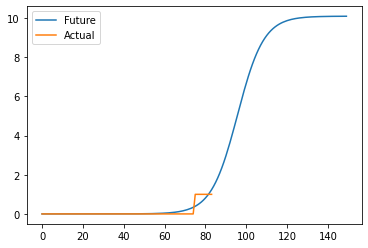

Benin hopefully good


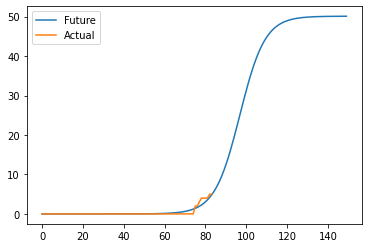

Bermuda hopefully good


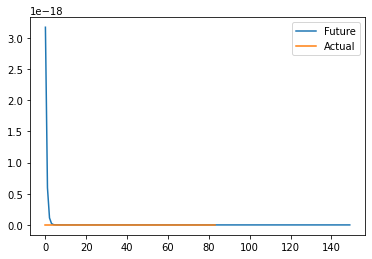

Bhutan hopefully good


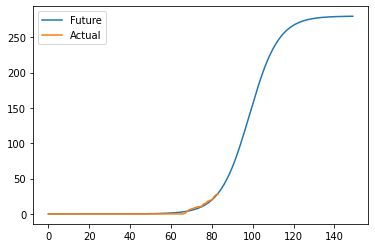

Bolivia hopefully good


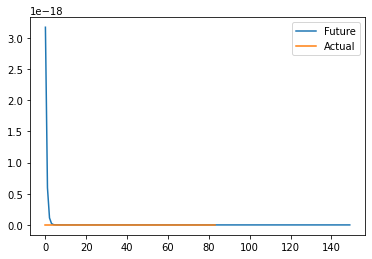

Bonaire, Sint Eustatius and Saba hopefully good


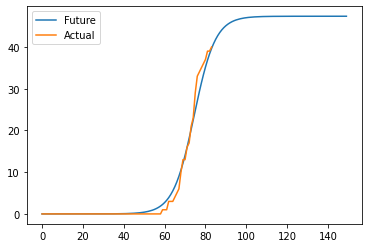

Bosnia and Herzegovina hopefully good


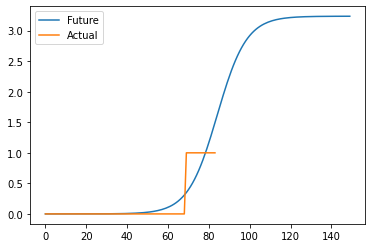

Botswana hopefully good


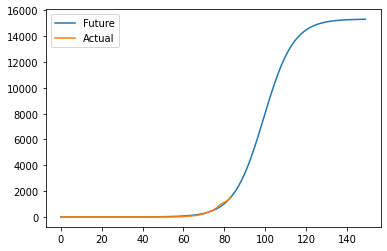

Brazil hopefully good


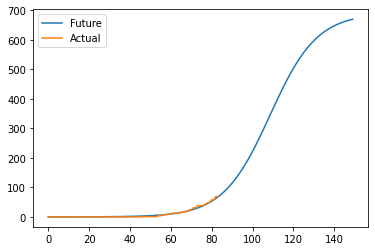

British Columbia hopefully good


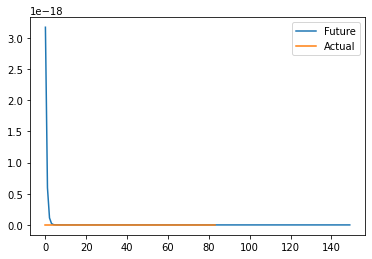

British Virgin Islands hopefully good


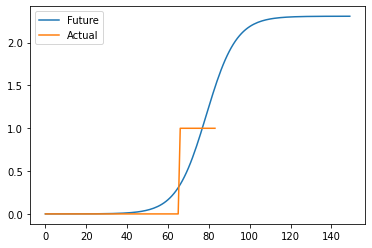

Brunei hopefully good


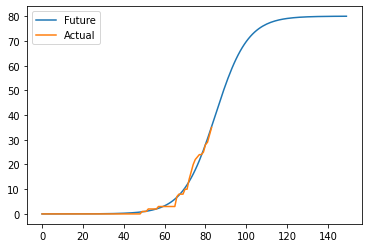

Bulgaria hopefully good


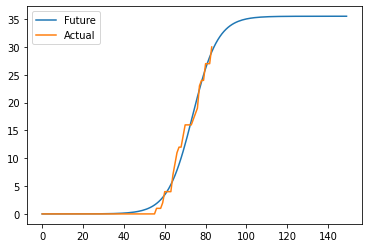

Burkina Faso hopefully good


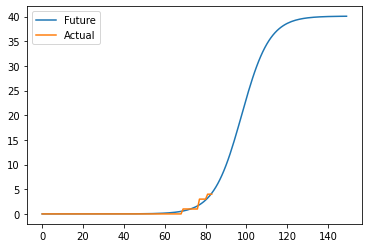

Burma hopefully good


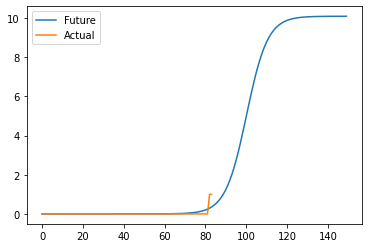

Burundi hopefully good


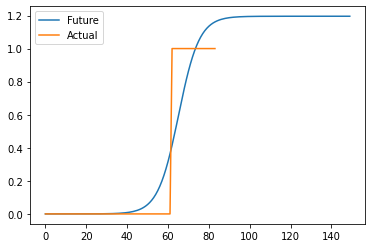

Cabo Verde hopefully good


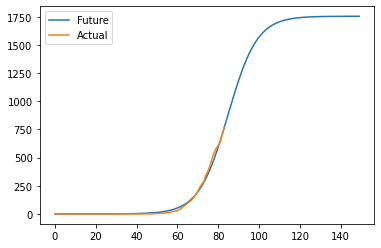

California hopefully good


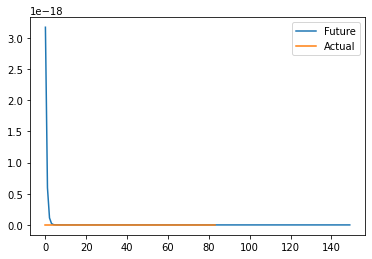

Cambodia hopefully good


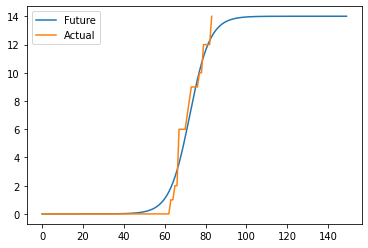

Cameroon hopefully good


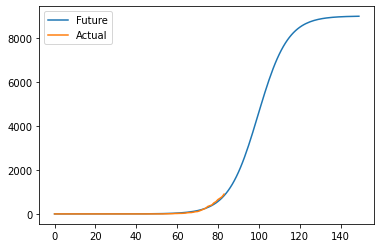

Canada hopefully good


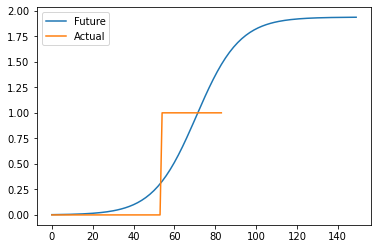

Cayman Islands hopefully good


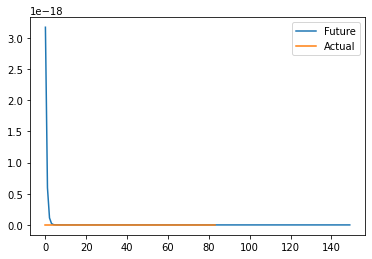

Central African Republic hopefully good


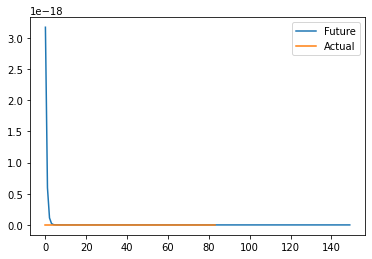

Chad hopefully good


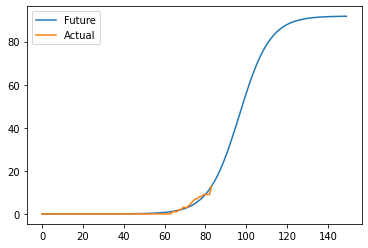

Channel Islands hopefully good


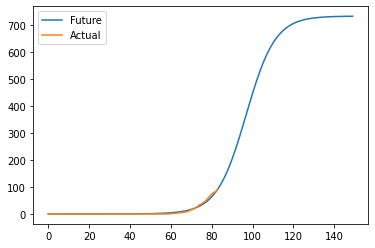

Chile hopefully good


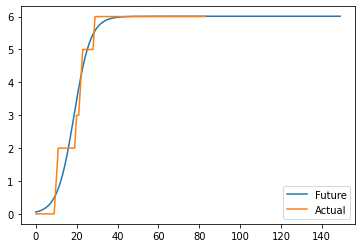

Chongqing hopefully good


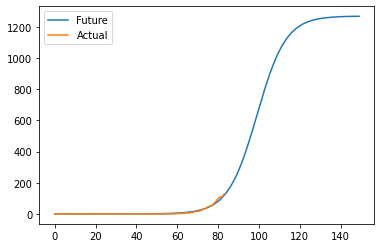

Colombia hopefully good


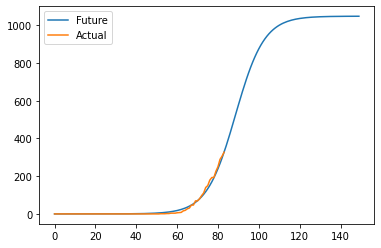

Colorado hopefully good


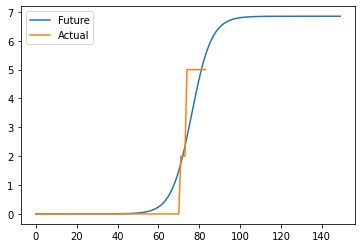

Congo (Brazzaville) hopefully good


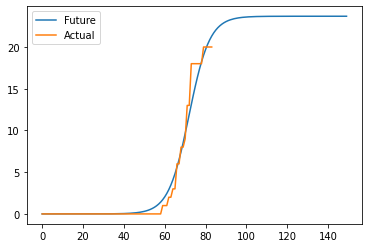

Congo (Kinshasa) hopefully good


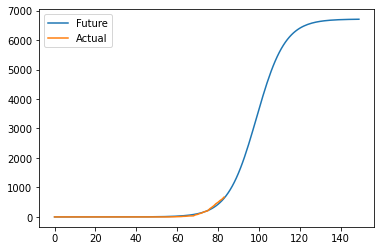

Connecticut hopefully good


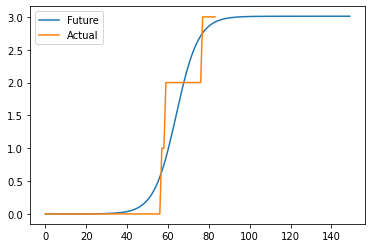

Costa Rica hopefully good


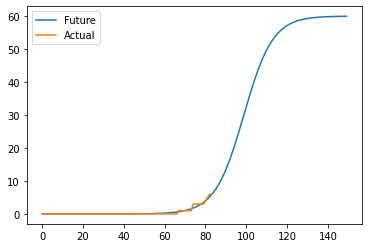

Cote d'Ivoire hopefully good


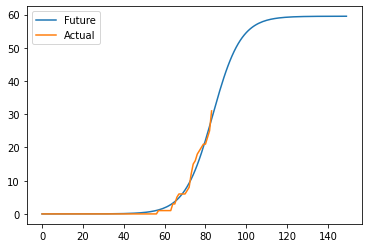

Croatia hopefully good


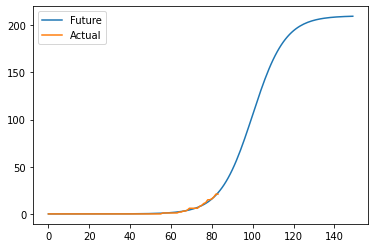

Cuba hopefully good


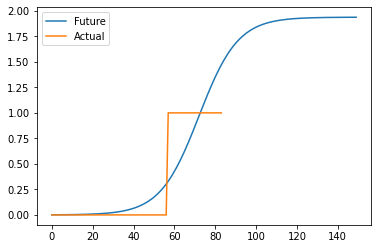

Curacao hopefully good


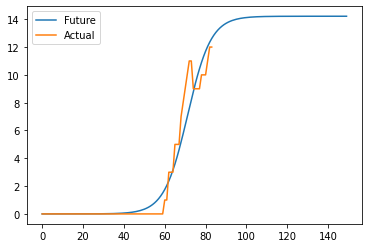

Cyprus hopefully good


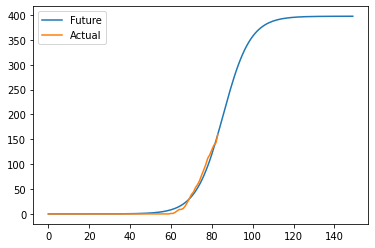

Czechia hopefully good


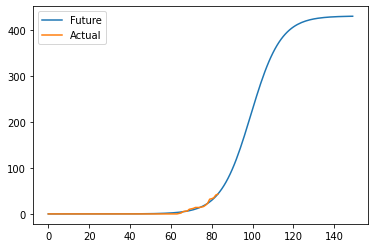

Delaware hopefully good


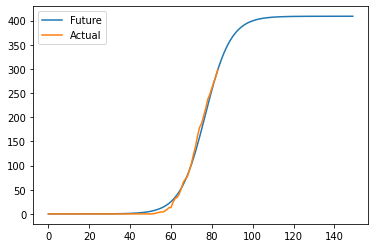

Denmark hopefully good


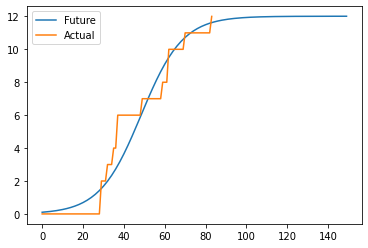

Diamond Princess hopefully good


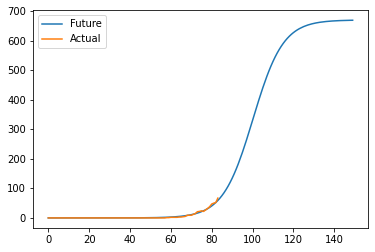

District of Columbia hopefully good


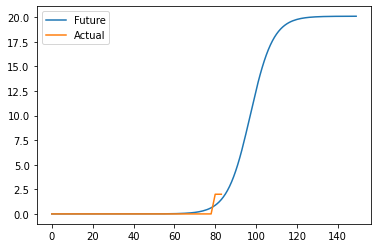

Djibouti hopefully good


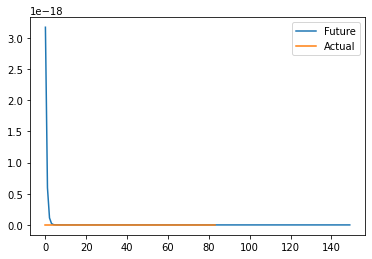

Dominica hopefully good


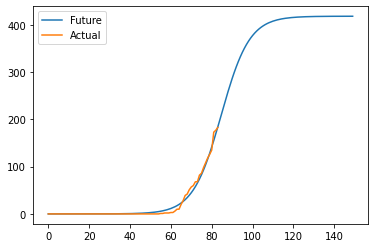

Dominican Republic hopefully good


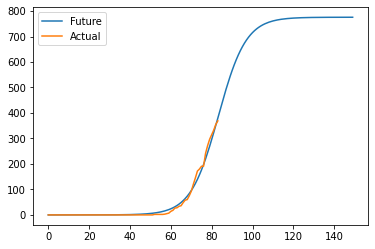

Ecuador hopefully good


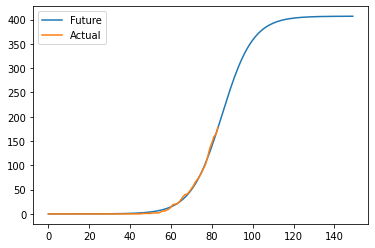

Egypt hopefully good


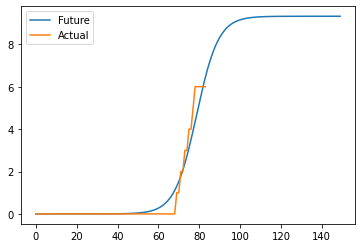

El Salvador hopefully good


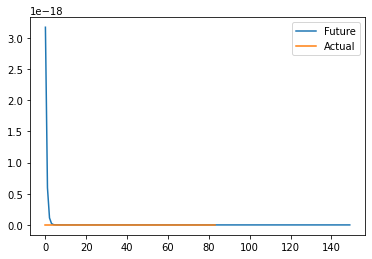

Equatorial Guinea hopefully good


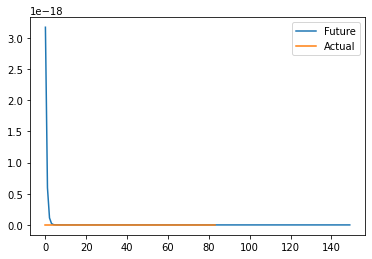

Eritrea hopefully good


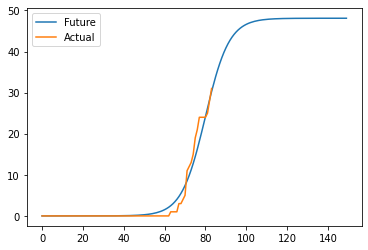

Estonia hopefully good


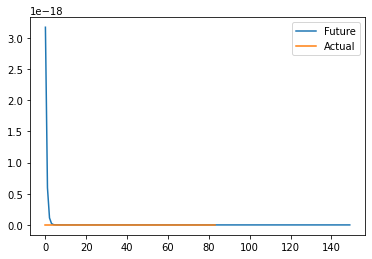

Eswatini hopefully good


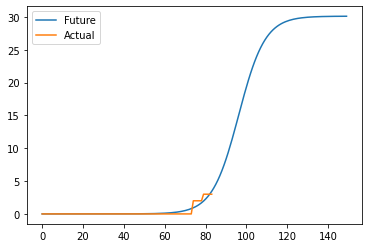

Ethiopia hopefully good


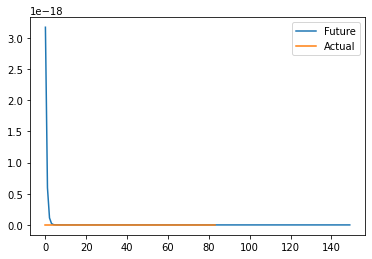

Falkland Islands (Malvinas) hopefully good


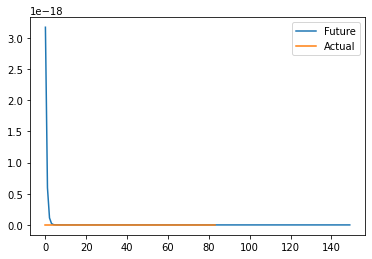

Faroe Islands hopefully good


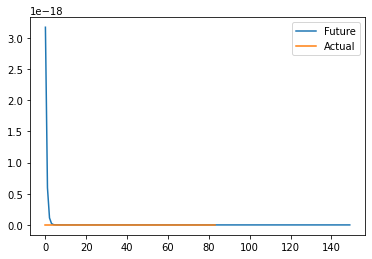

Fiji hopefully good


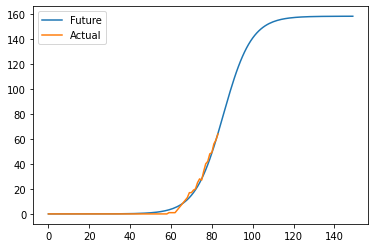

Finland hopefully good


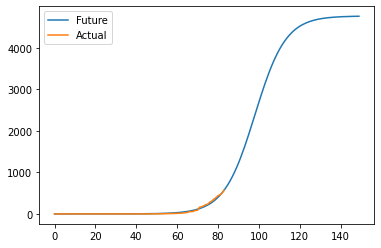

Florida hopefully good


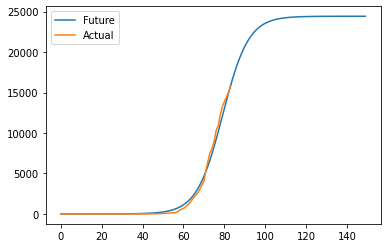

France hopefully good


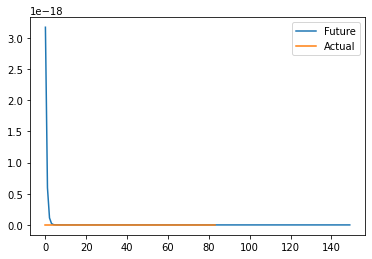

French Guiana hopefully good


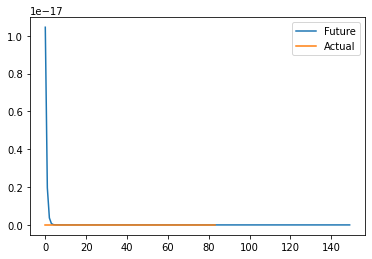

French Polynesia hopefully good


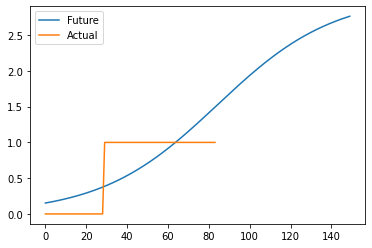

Fujian hopefully good


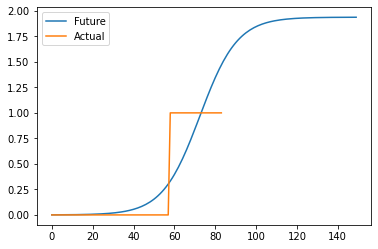

Gabon hopefully good


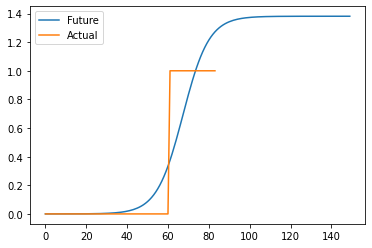

Gambia hopefully good


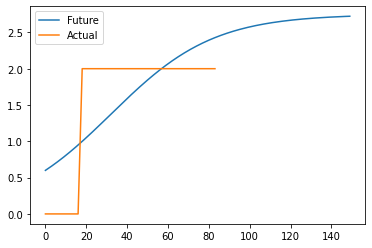

Gansu hopefully good


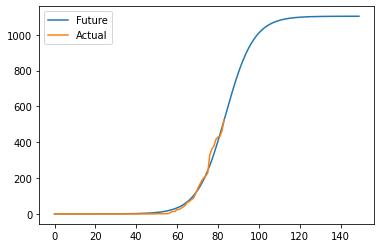

Georgia hopefully good


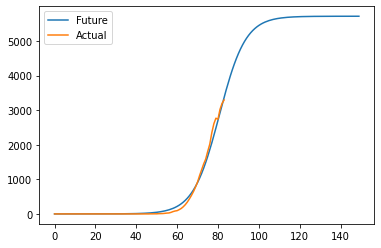

Germany hopefully good


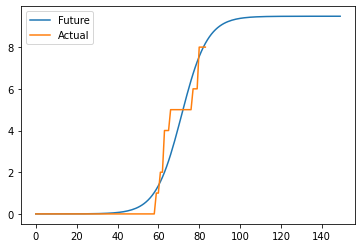

Ghana hopefully good


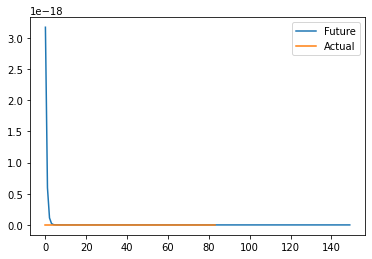

Gibraltar hopefully good


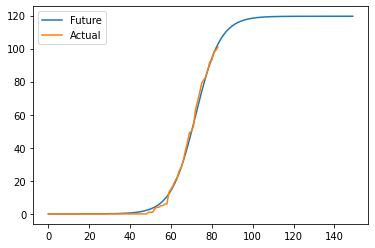

Greece hopefully good


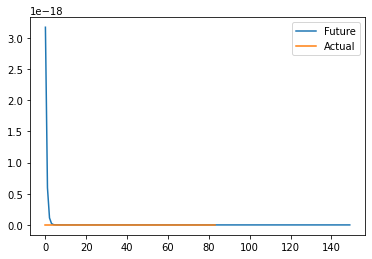

Greenland hopefully good


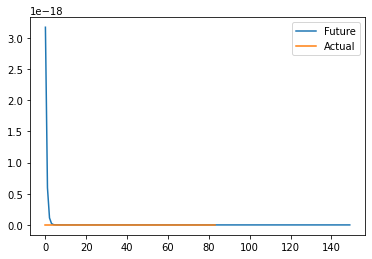

Grenada hopefully good


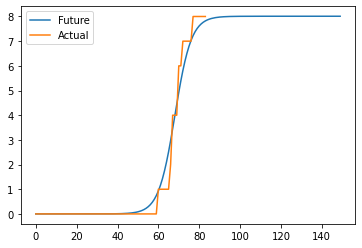

Guadeloupe hopefully good


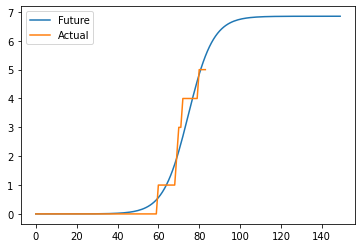

Guam hopefully good


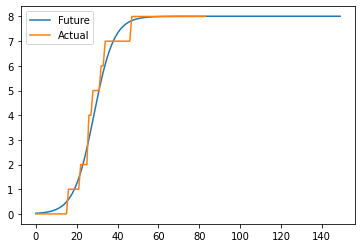

Guangdong hopefully good


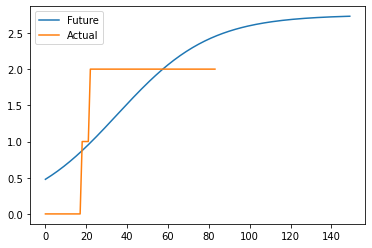

Guangxi hopefully good


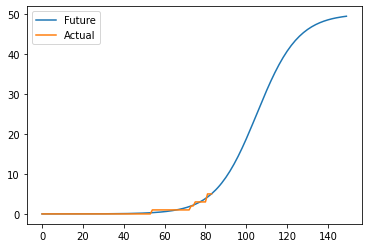

Guatemala hopefully good


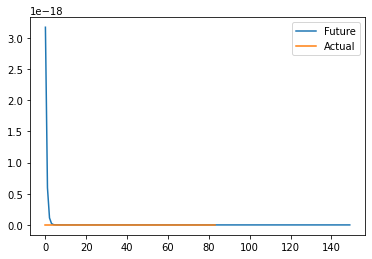

Guinea hopefully good


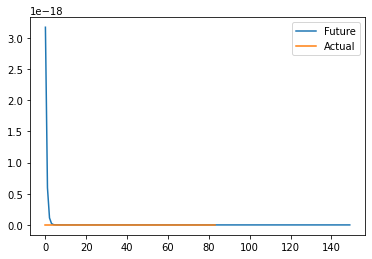

Guinea-Bissau hopefully good


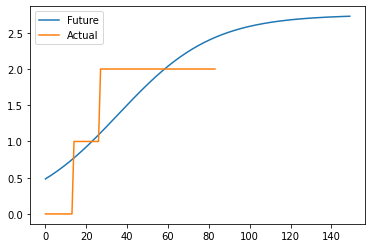

Guizhou hopefully good


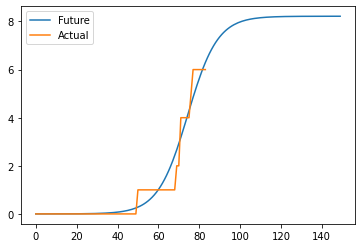

Guyana hopefully good


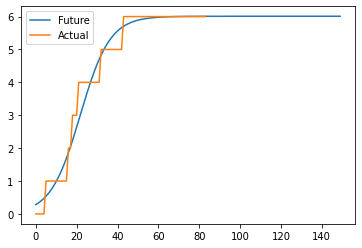

Hainan hopefully good


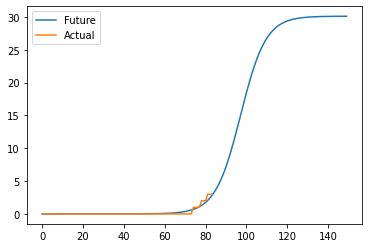

Haiti hopefully good


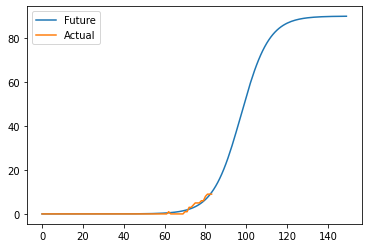

Hawaii hopefully good


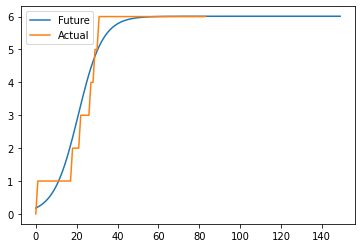

Hebei hopefully good


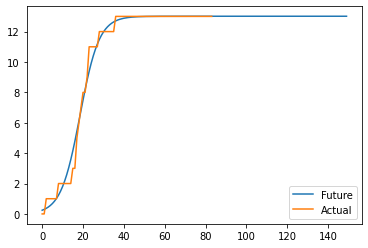

Heilongjiang hopefully good


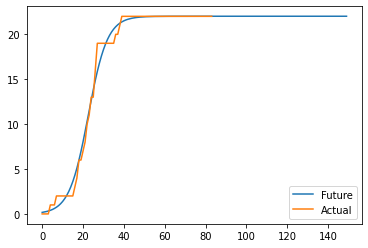

Henan hopefully good


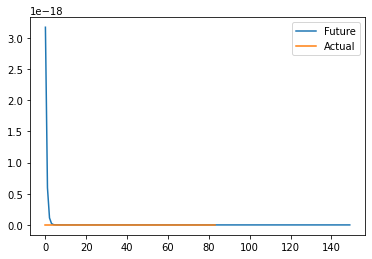

Holy See hopefully good


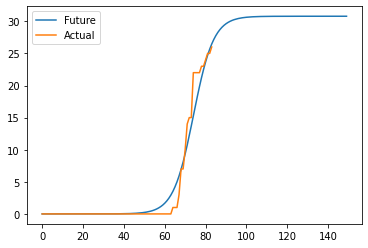

Honduras hopefully good


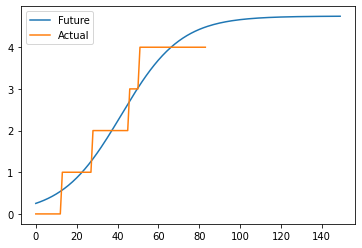

Hong Kong hopefully good


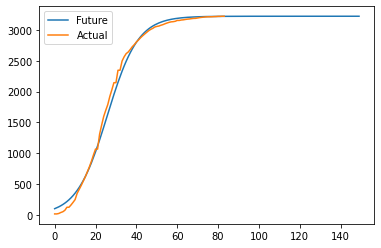

Hubei hopefully good


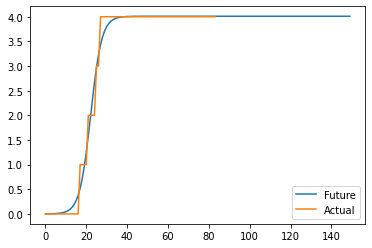

Hunan hopefully good


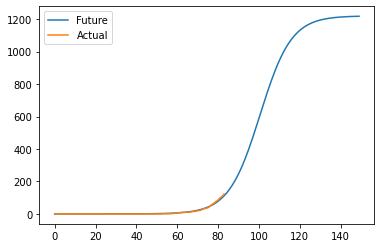

Hungary hopefully good


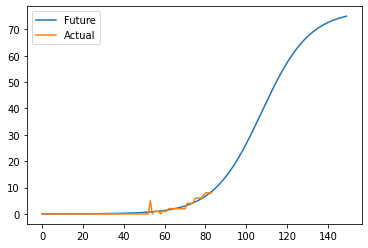

Iceland hopefully good


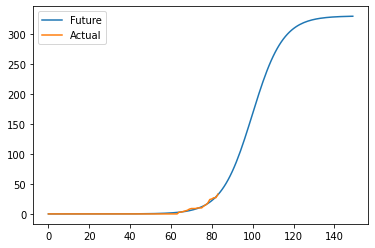

Idaho hopefully good


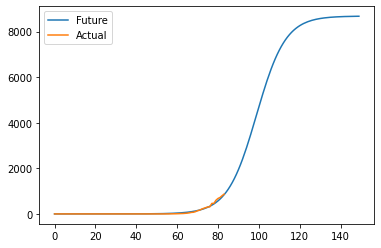

Illinois hopefully good


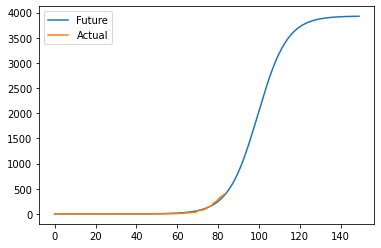

India hopefully good


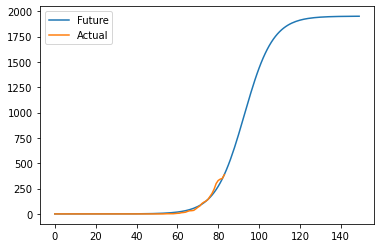

Indiana hopefully good


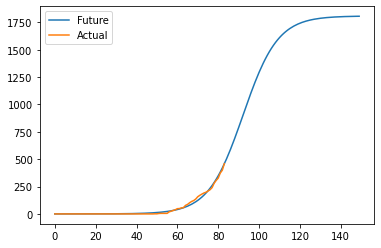

Indonesia hopefully good


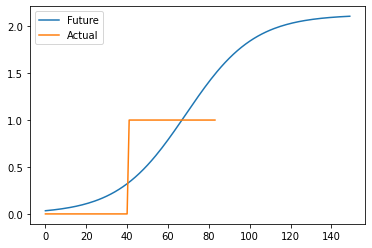

Inner Mongolia hopefully good


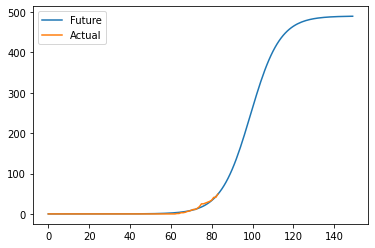

Iowa hopefully good


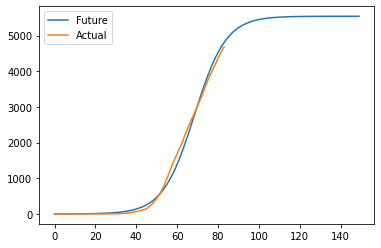

Iran hopefully good


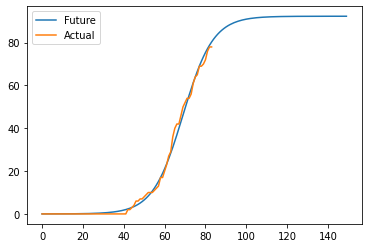

Iraq hopefully good


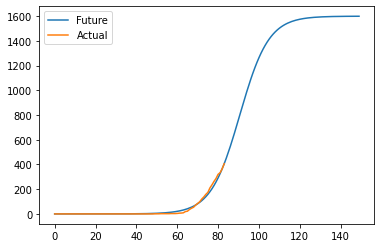

Ireland hopefully good


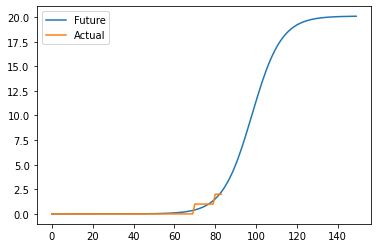

Isle of Man hopefully good


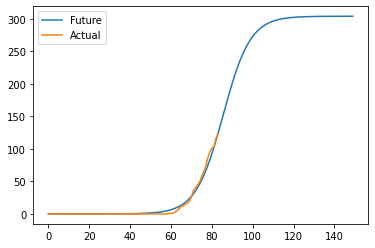

Israel hopefully good


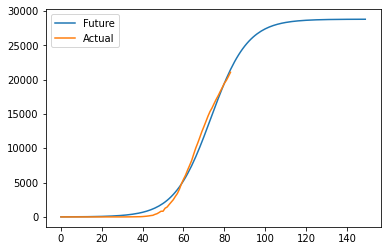

Italy hopefully good


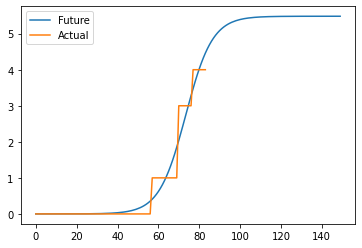

Jamaica hopefully good


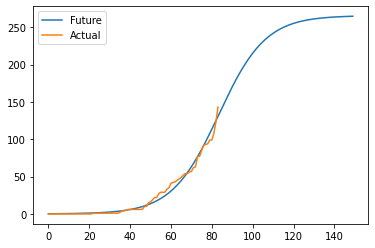

Japan hopefully good


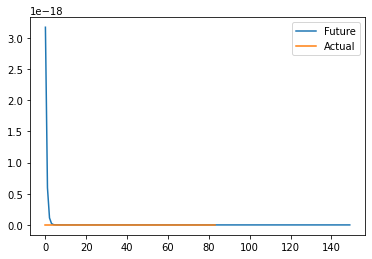

Jiangsu hopefully good


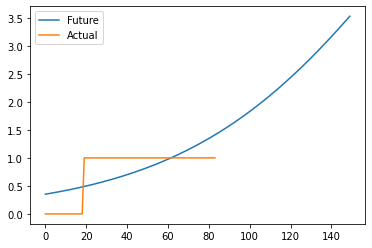

Jiangxi hopefully good


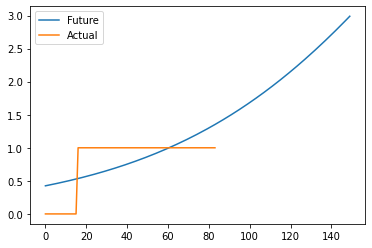

Jilin hopefully good


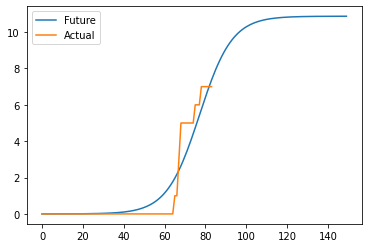

Jordan hopefully good


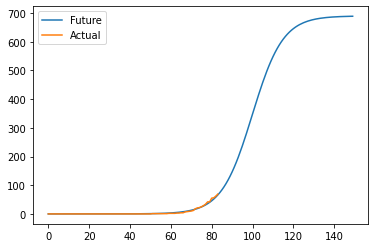

Kansas hopefully good


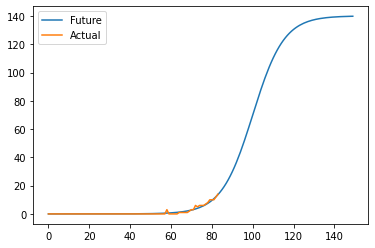

Kazakhstan hopefully good


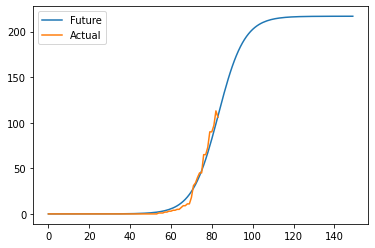

Kentucky hopefully good


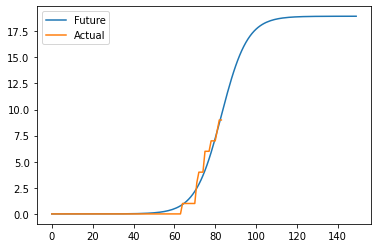

Kenya hopefully good


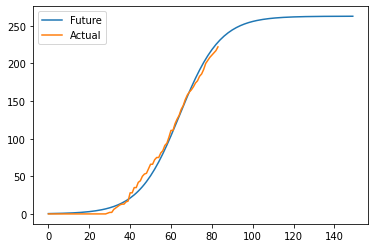

Korea, South hopefully good


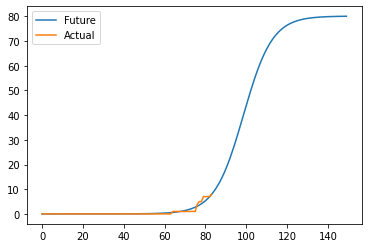

Kosovo hopefully good


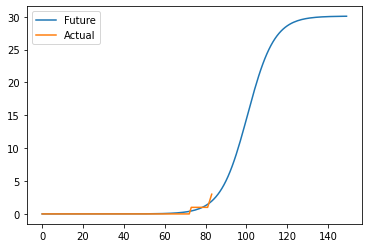

Kuwait hopefully good


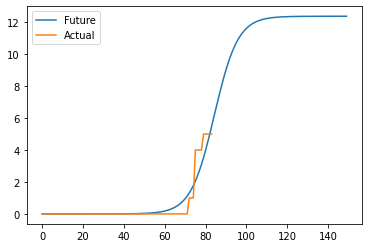

Kyrgyzstan hopefully good


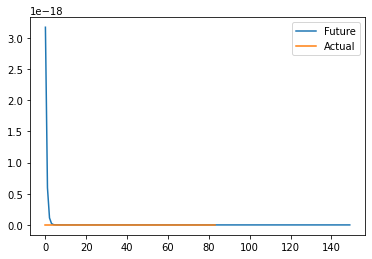

Laos hopefully good


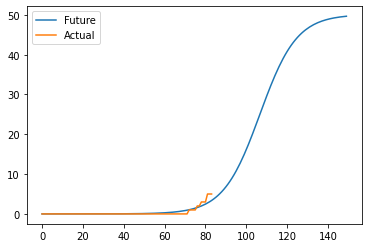

Latvia hopefully good


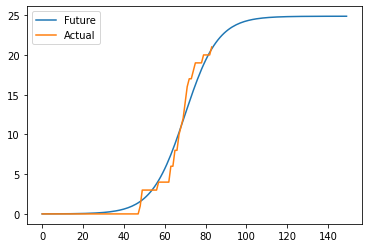

Lebanon hopefully good


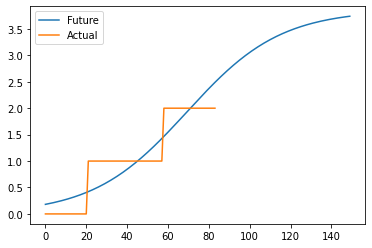

Liaoning hopefully good


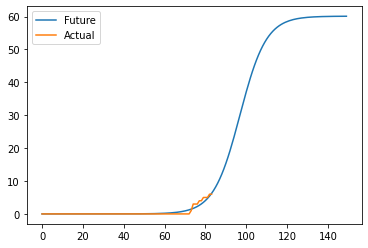

Liberia hopefully good


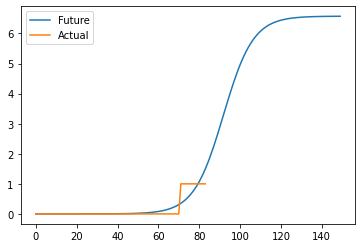

Libya hopefully good


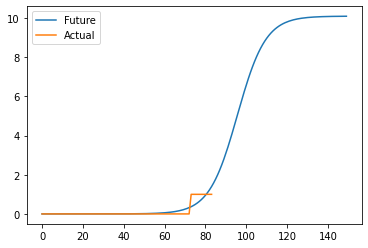

Liechtenstein hopefully good


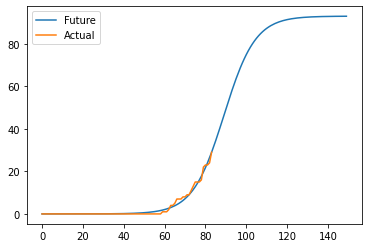

Lithuania hopefully good


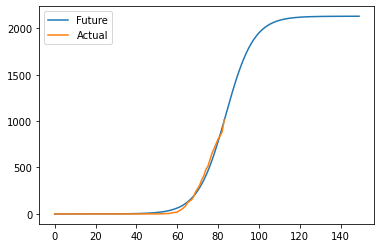

Louisiana hopefully good


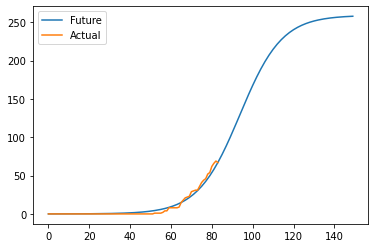

Luxembourg hopefully good


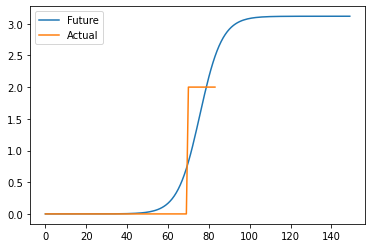

MS Zaandam hopefully good


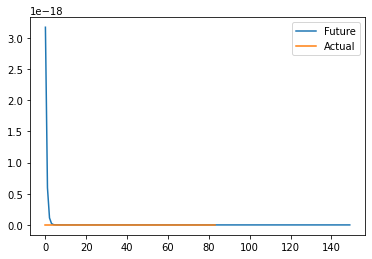

Macau hopefully good


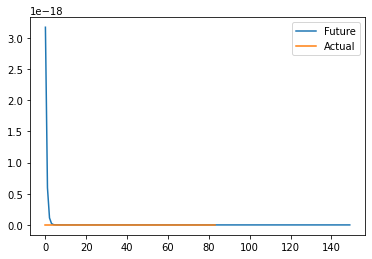

Madagascar hopefully good


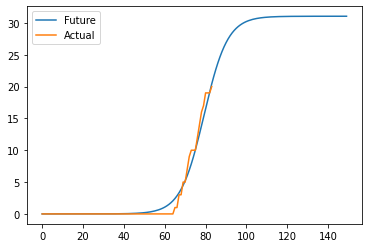

Maine hopefully good


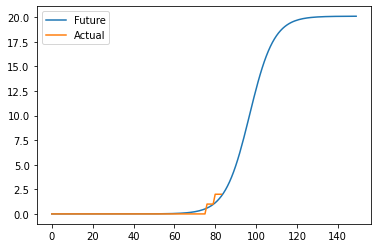

Malawi hopefully good


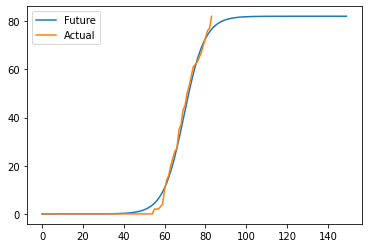

Malaysia hopefully good


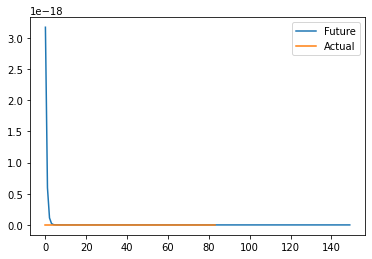

Maldives hopefully good


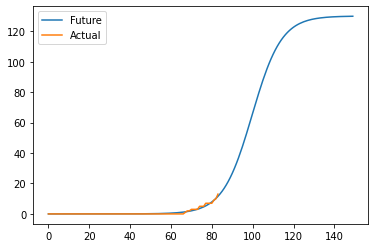

Mali hopefully good


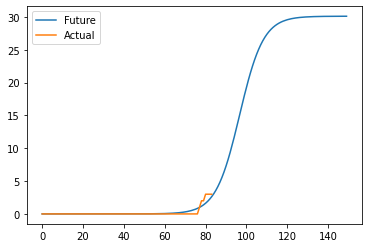

Malta hopefully good


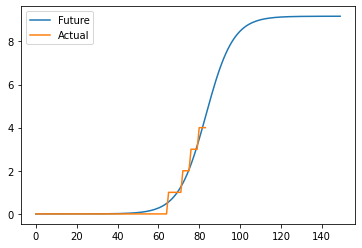

Manitoba hopefully good


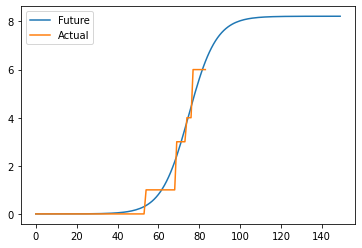

Martinique hopefully good


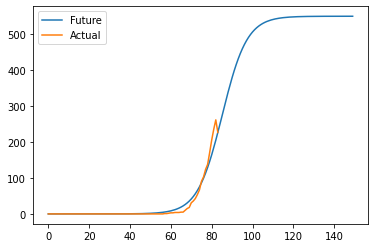

Maryland hopefully good


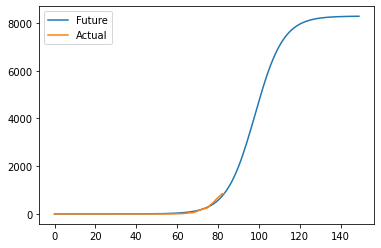

Massachusetts hopefully good


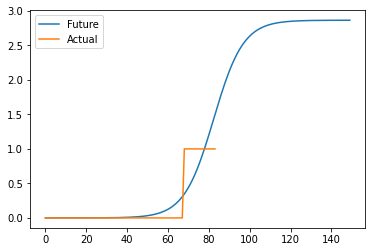

Mauritania hopefully good


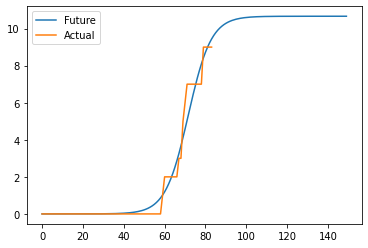

Mauritius hopefully good


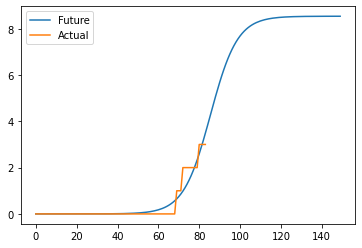

Mayotte hopefully good


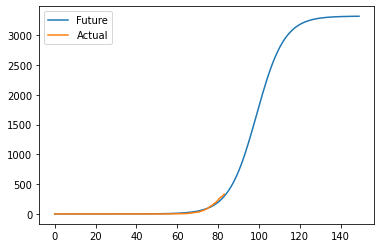

Mexico hopefully good


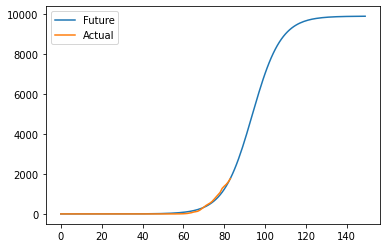

Michigan hopefully good


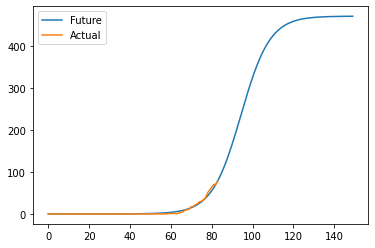

Minnesota hopefully good


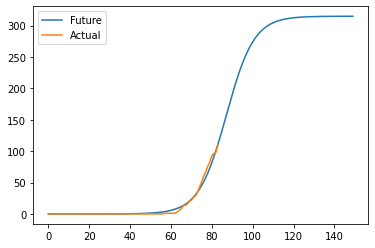

Mississippi hopefully good


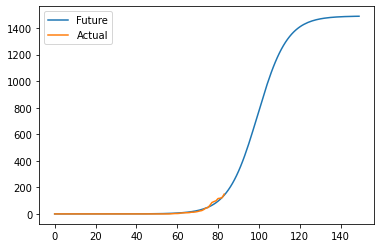

Missouri hopefully good


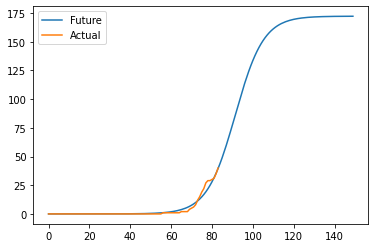

Moldova hopefully good


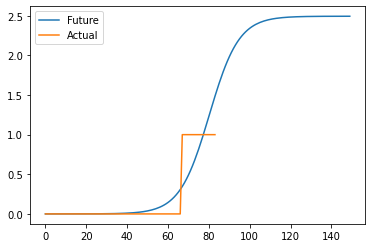

Monaco hopefully good


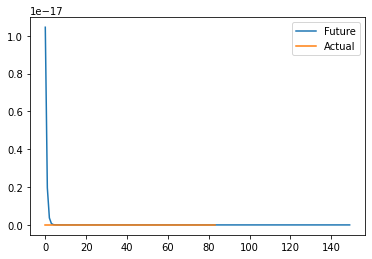

Mongolia hopefully good


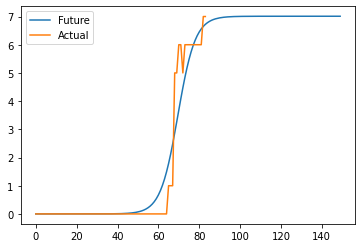

Montana hopefully good


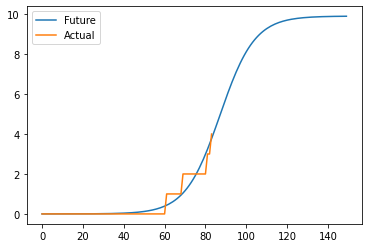

Montenegro hopefully good


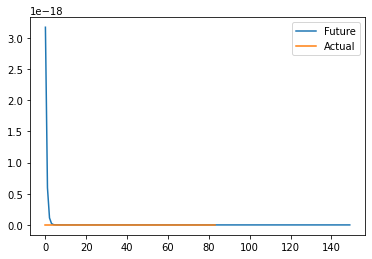

Montserrat hopefully good


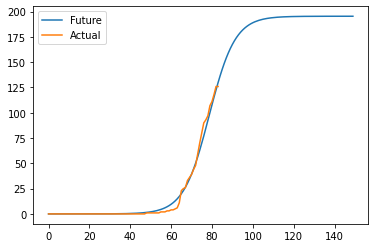

Morocco hopefully good


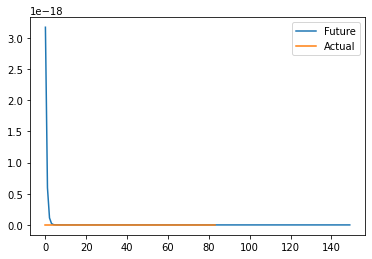

Mozambique hopefully good


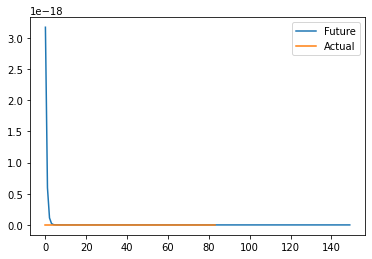

Namibia hopefully good


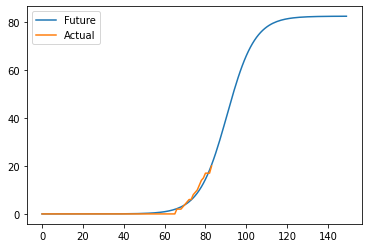

Nebraska hopefully good


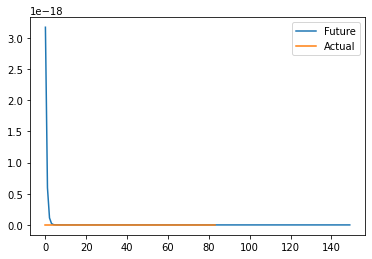

Nepal hopefully good


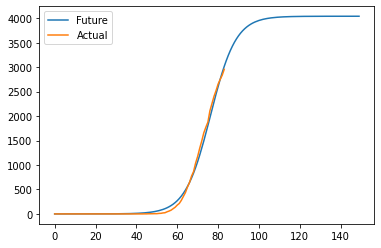

Netherlands hopefully good


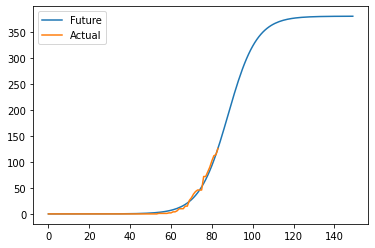

Nevada hopefully good


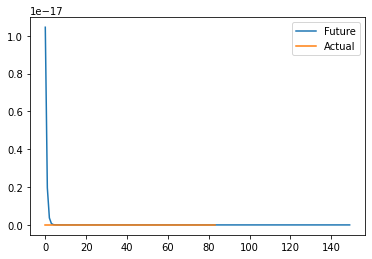

New Brunswick hopefully good


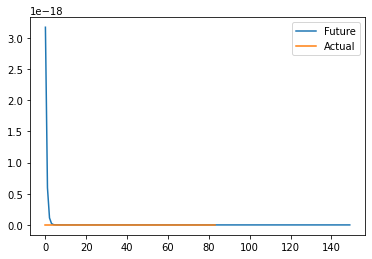

New Caledonia hopefully good


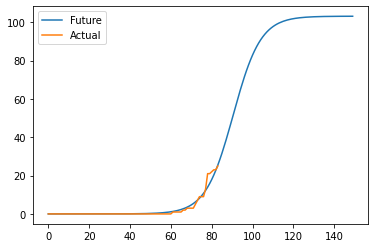

New Hampshire hopefully good


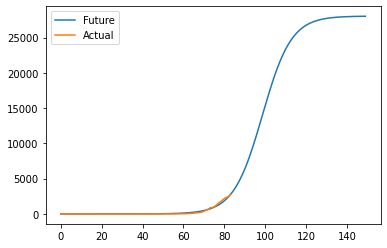

New Jersey hopefully good


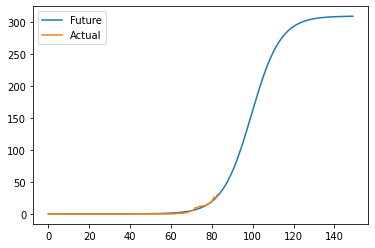

New Mexico hopefully good


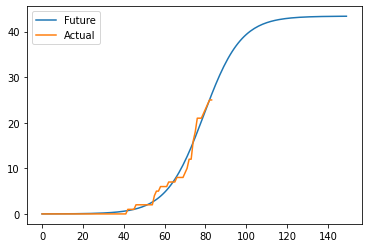

New South Wales hopefully good


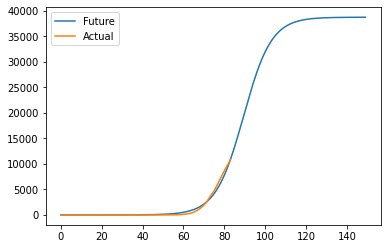

New York hopefully good


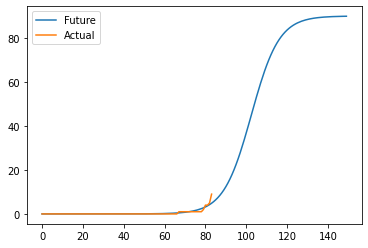

New Zealand hopefully good


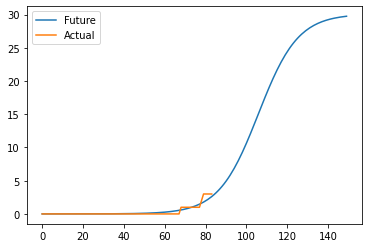

Newfoundland and Labrador hopefully good


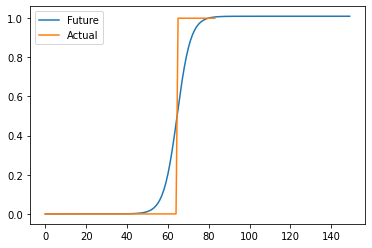

Nicaragua hopefully good


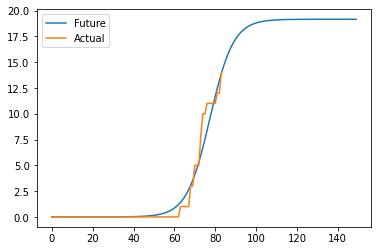

Niger hopefully good


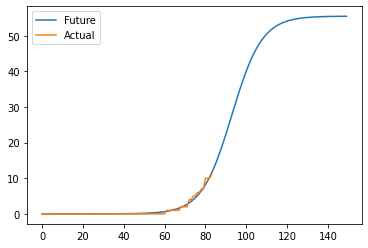

Nigeria hopefully good


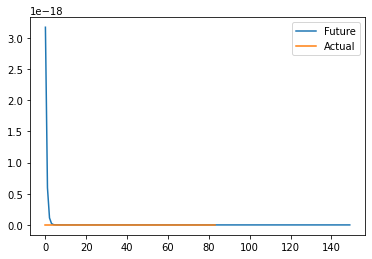

Ningxia hopefully good


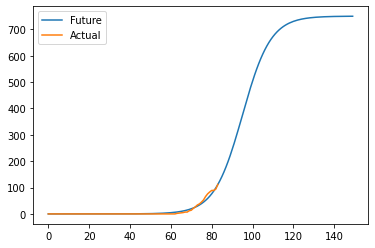

North Carolina hopefully good


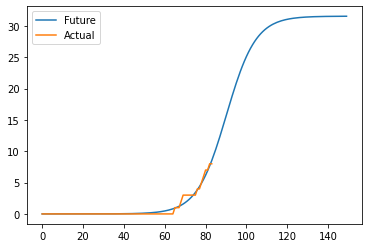

North Dakota hopefully good


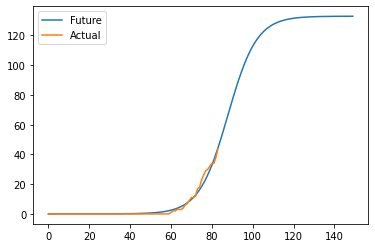

North Macedonia hopefully good


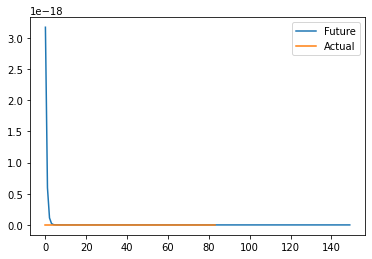

Northern Territory hopefully good


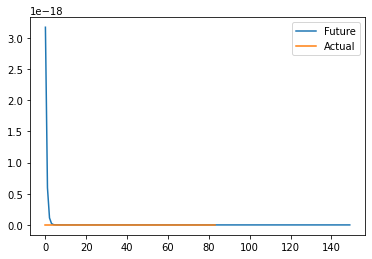

Northwest Territories hopefully good


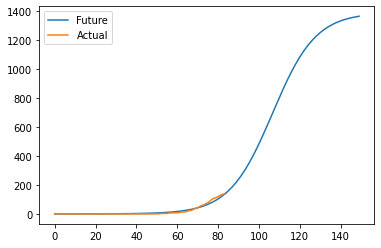

Norway hopefully good


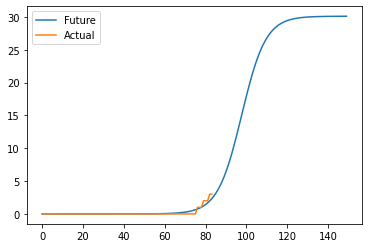

Nova Scotia hopefully good


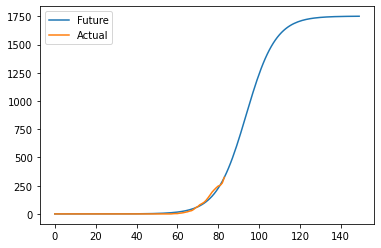

Ohio hopefully good


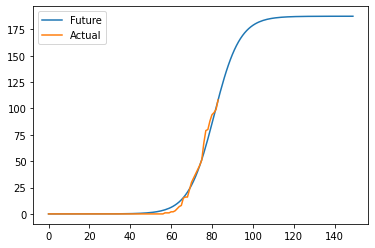

Oklahoma hopefully good


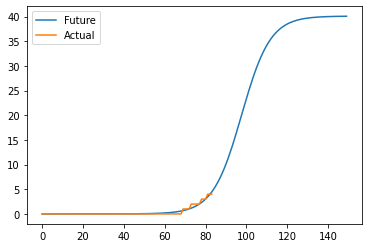

Oman hopefully good


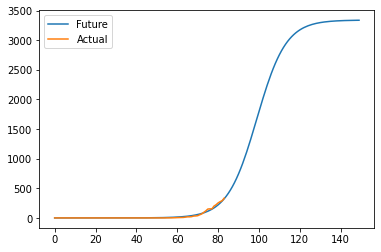

Ontario hopefully good


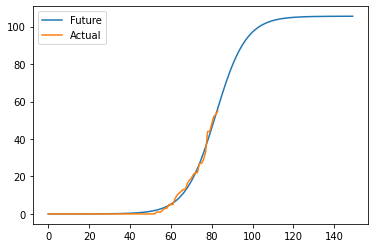

Oregon hopefully good


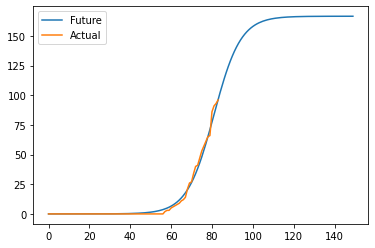

Pakistan hopefully good


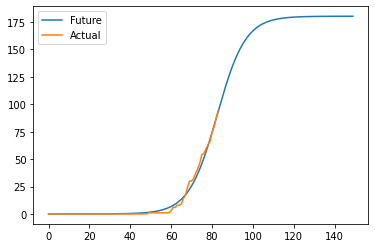

Panama hopefully good


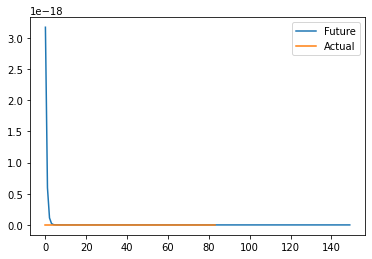

Papua New Guinea hopefully good


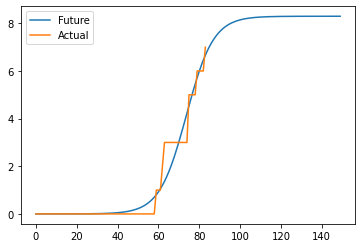

Paraguay hopefully good


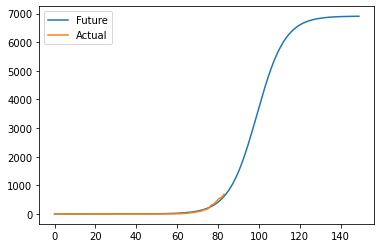

Pennsylvania hopefully good


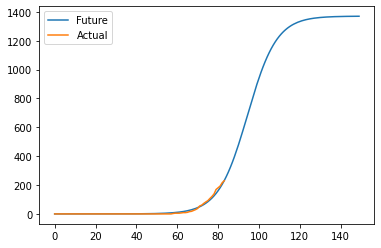

Peru hopefully good


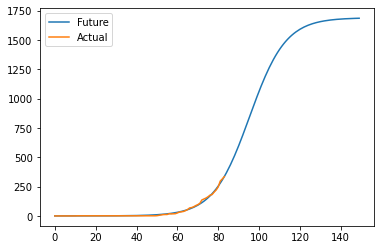

Philippines hopefully good


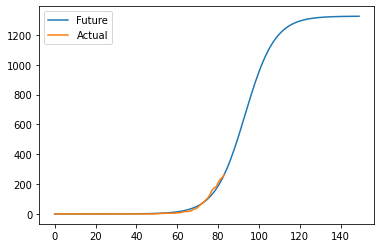

Poland hopefully good


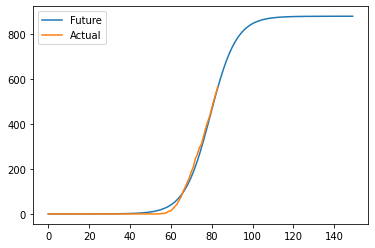

Portugal hopefully good


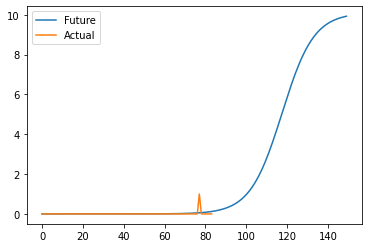

Prince Edward Island hopefully good


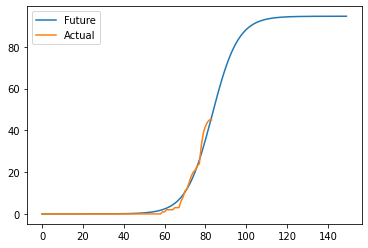

Puerto Rico hopefully good


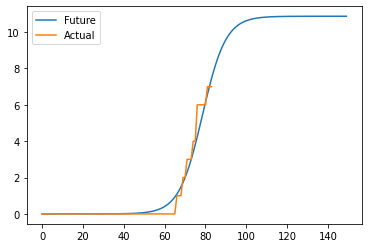

Qatar hopefully good


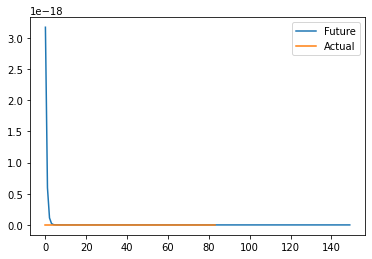

Qinghai hopefully good


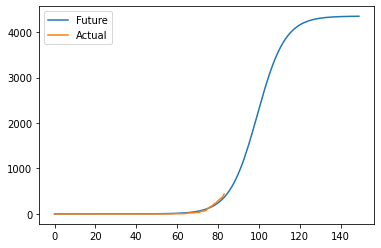

Quebec hopefully good


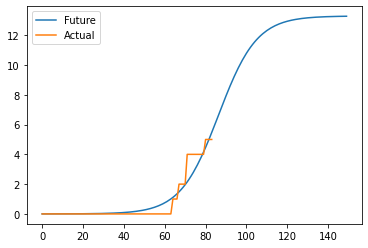

Queensland hopefully good


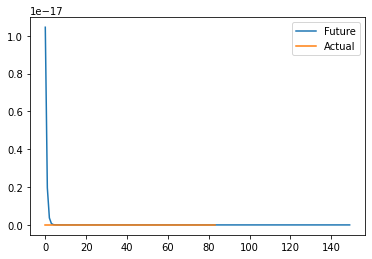

Reunion hopefully good


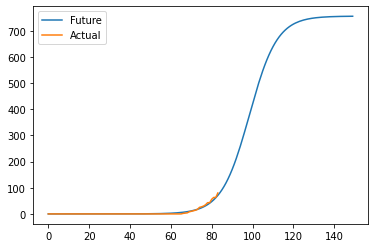

Rhode Island hopefully good


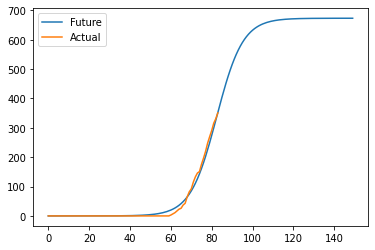

Romania hopefully good


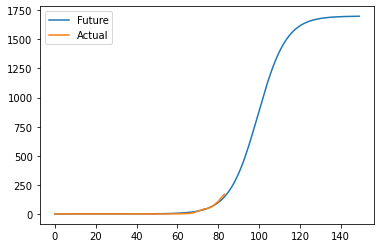

Russia hopefully good


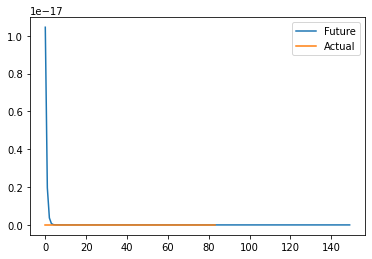

Rwanda hopefully good


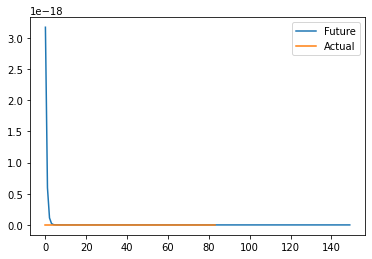

Saint Barthelemy hopefully good


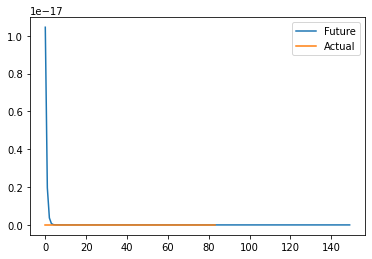

Saint Kitts and Nevis hopefully good


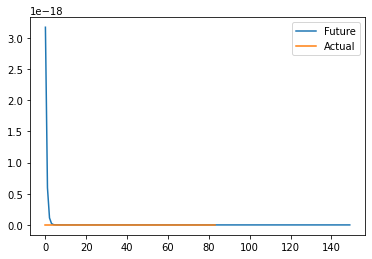

Saint Lucia hopefully good


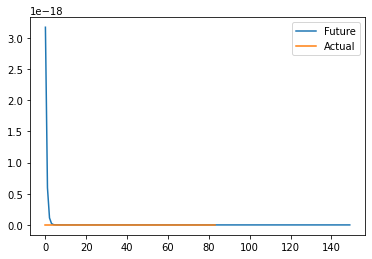

Saint Pierre and Miquelon hopefully good


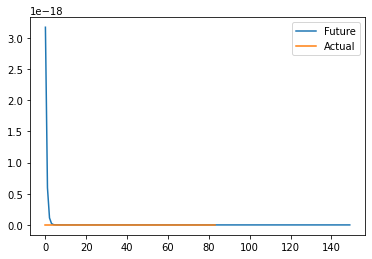

Saint Vincent and the Grenadines hopefully good


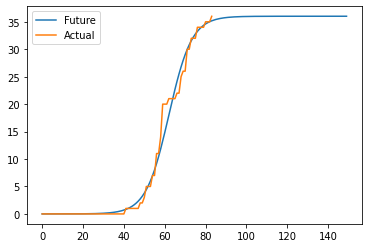

San Marino hopefully good


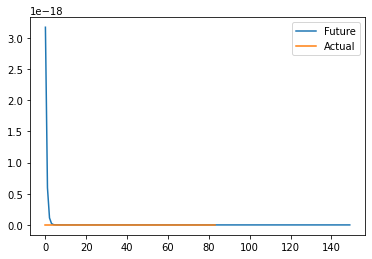

Sao Tome and Principe hopefully good


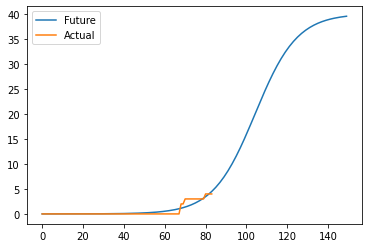

Saskatchewan hopefully good


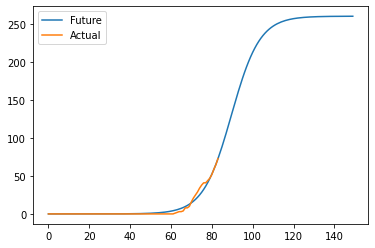

Saudi Arabia hopefully good


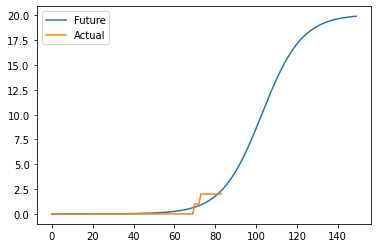

Senegal hopefully good


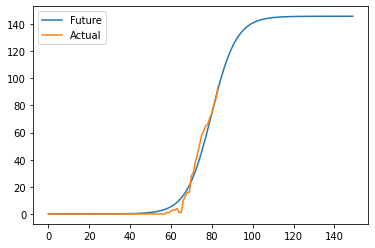

Serbia hopefully good


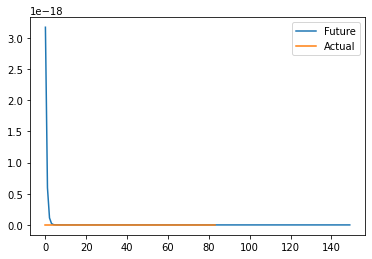

Seychelles hopefully good


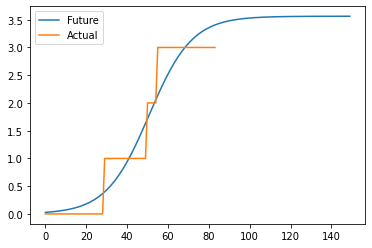

Shaanxi hopefully good


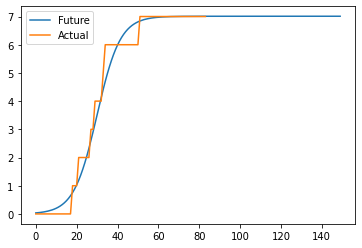

Shandong hopefully good


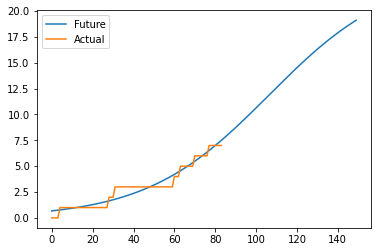

Shanghai hopefully good


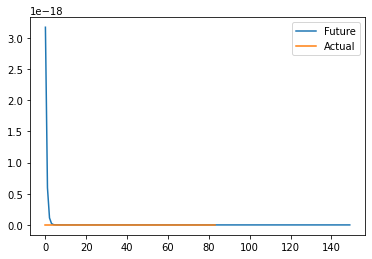

Shanxi hopefully good


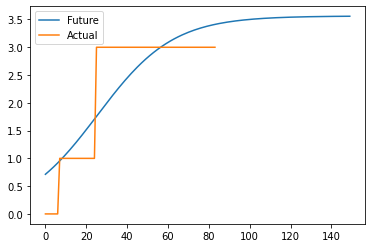

Sichuan hopefully good


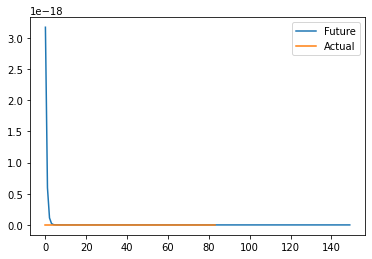

Sierra Leone hopefully good


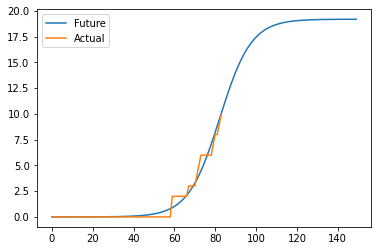

Singapore hopefully good


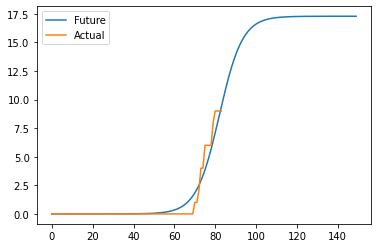

Sint Maarten hopefully good


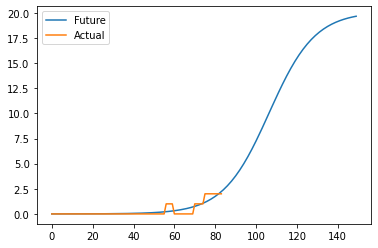

Slovakia hopefully good


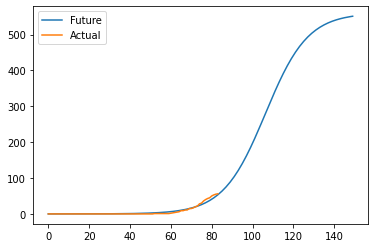

Slovenia hopefully good


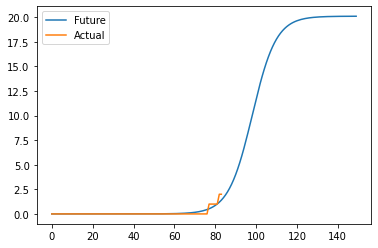

Somalia hopefully good


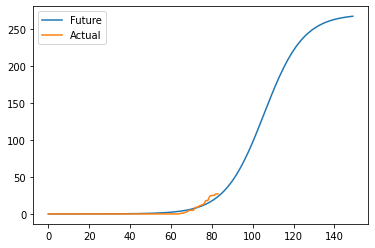

South Africa hopefully good


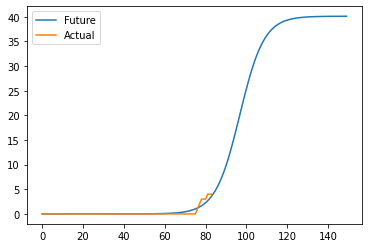

South Australia hopefully good


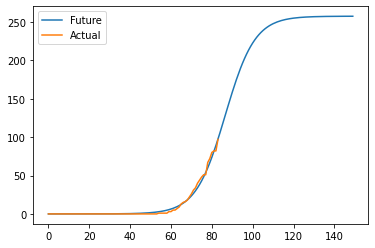

South Carolina hopefully good


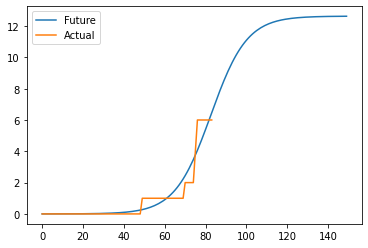

South Dakota hopefully good


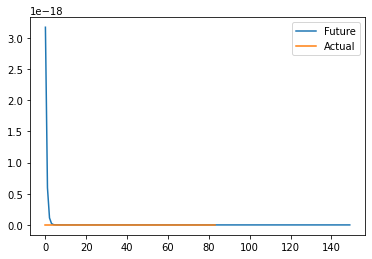

South Sudan hopefully good


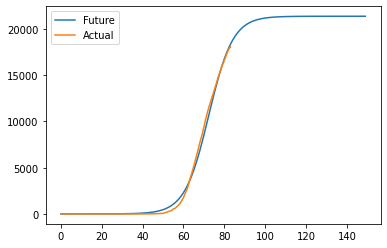

Spain hopefully good


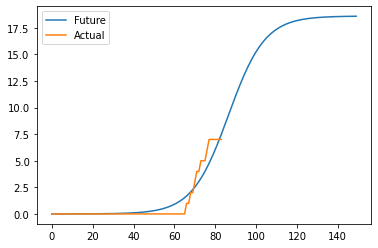

Sri Lanka hopefully good


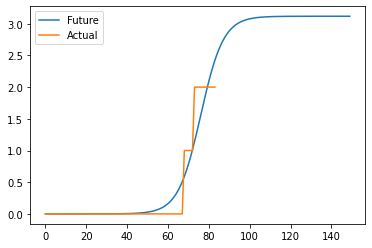

St Martin hopefully good


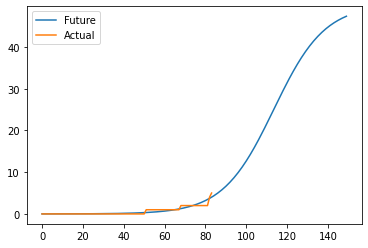

Sudan hopefully good


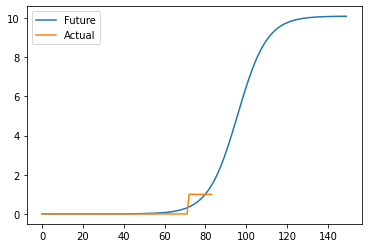

Suriname hopefully good


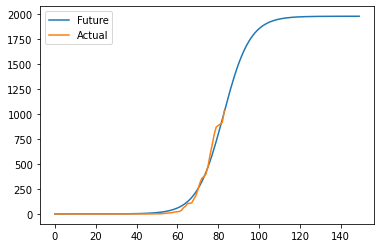

Sweden hopefully good


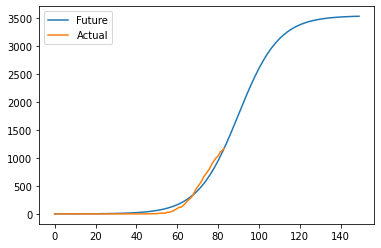

Switzerland hopefully good


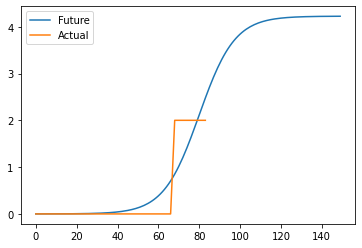

Syria hopefully good


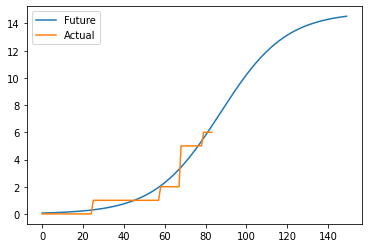

Taiwan* hopefully good


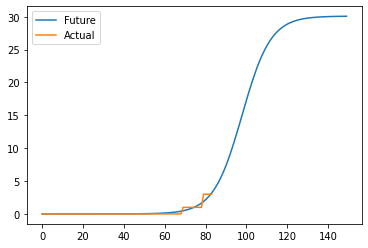

Tanzania hopefully good


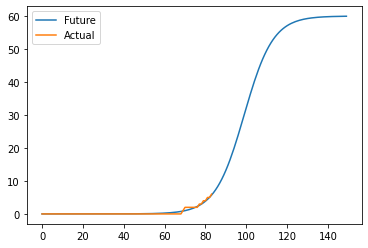

Tasmania hopefully good


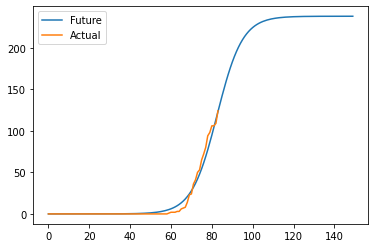

Tennessee hopefully good


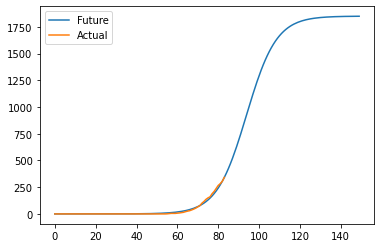

Texas hopefully good


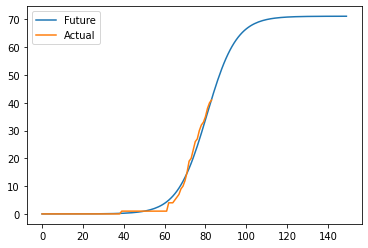

Thailand hopefully good


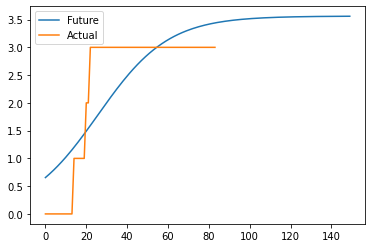

Tianjin hopefully good


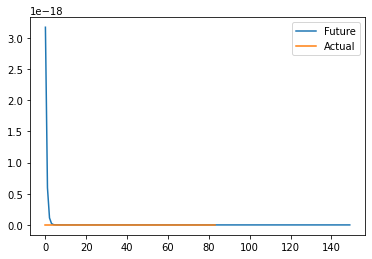

Tibet hopefully good


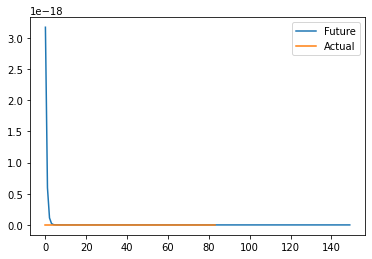

Timor-Leste hopefully good


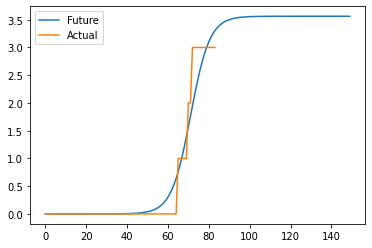

Togo hopefully good


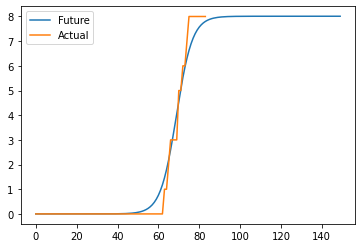

Trinidad and Tobago hopefully good


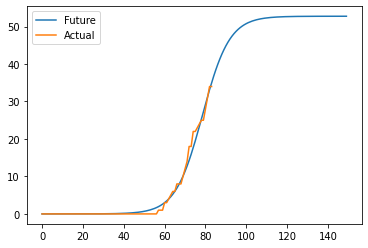

Tunisia hopefully good


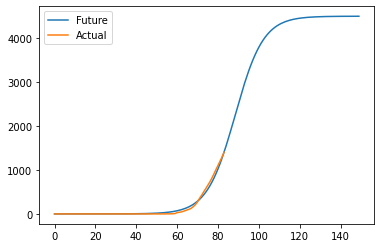

Turkey hopefully good


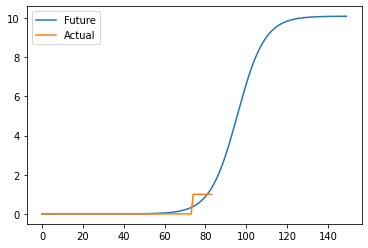

Turks and Caicos Islands hopefully good


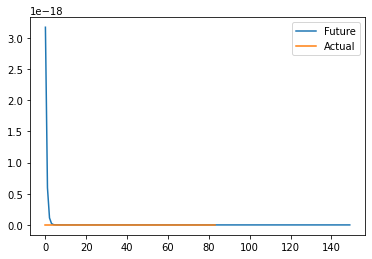

Uganda hopefully good


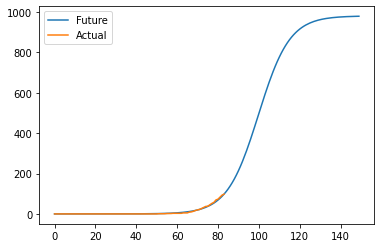

Ukraine hopefully good


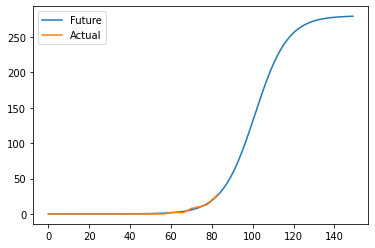

United Arab Emirates hopefully good


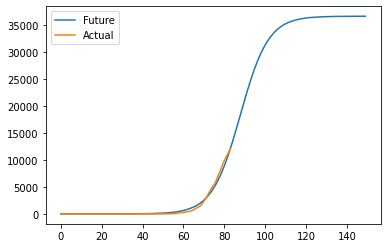

United Kingdom hopefully good


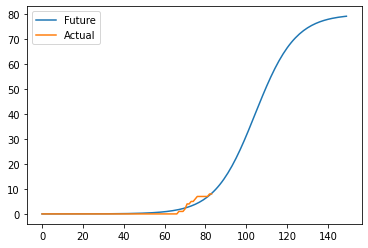

Uruguay hopefully good


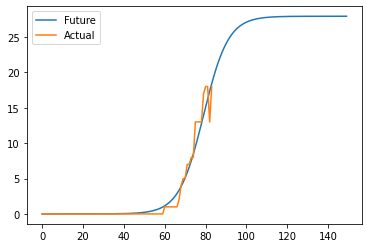

Utah hopefully good


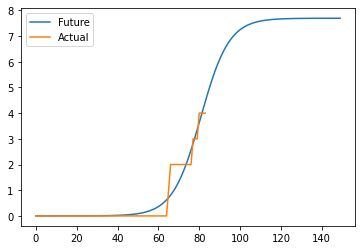

Uzbekistan hopefully good


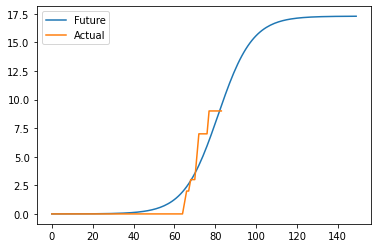

Venezuela hopefully good


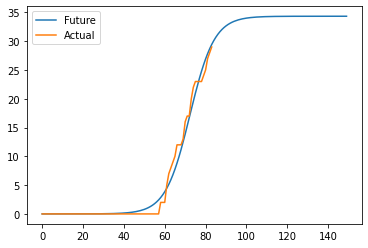

Vermont hopefully good


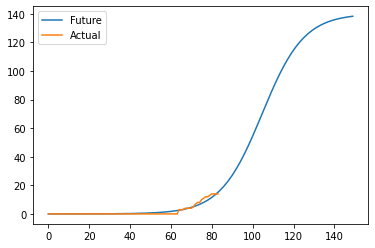

Victoria hopefully good


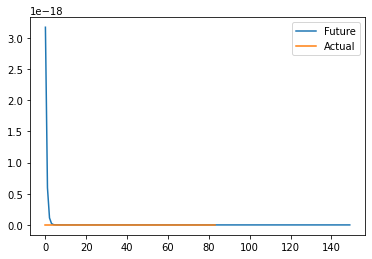

Vietnam hopefully good


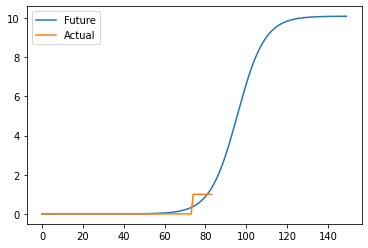

Virgin Islands hopefully good


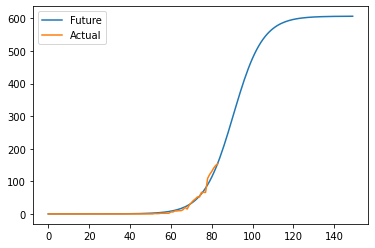

Virginia hopefully good


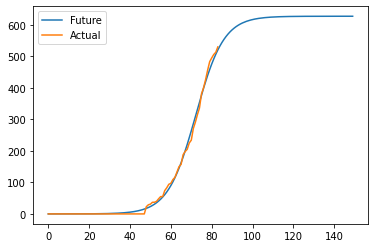

Washington hopefully good


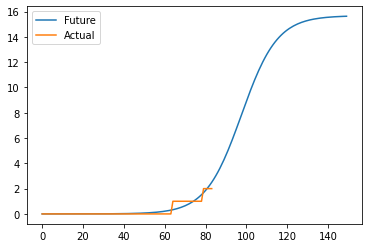

West Bank and Gaza hopefully good


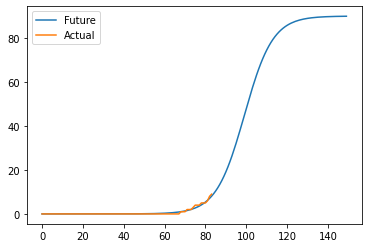

West Virginia hopefully good


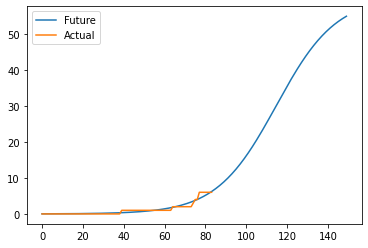

Western Australia hopefully good


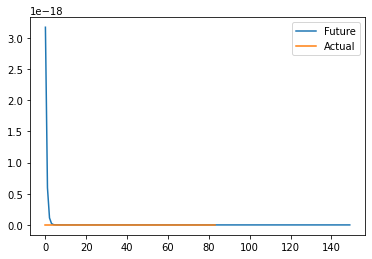

Western Sahara hopefully good


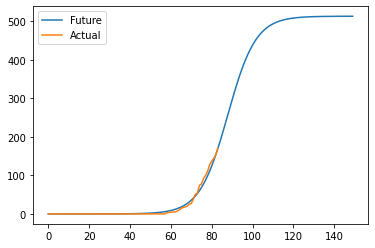

Wisconsin hopefully good


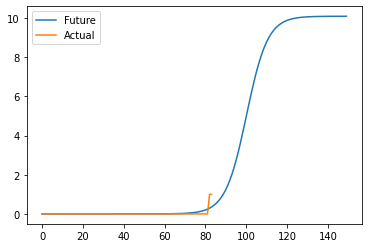

Wyoming hopefully good


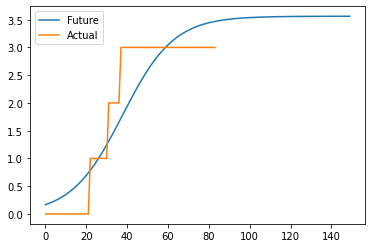

Xinjiang hopefully good


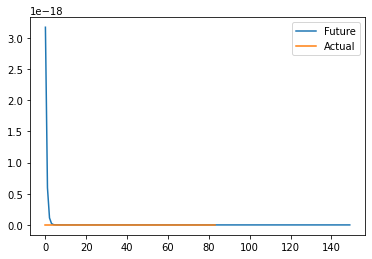

Yukon hopefully good


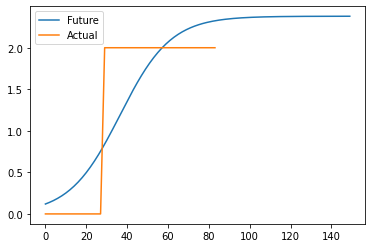

Yunnan hopefully good


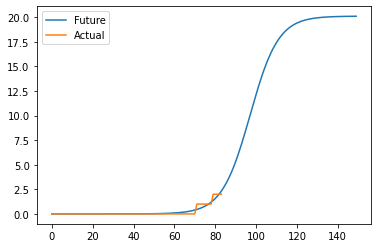

Zambia hopefully good


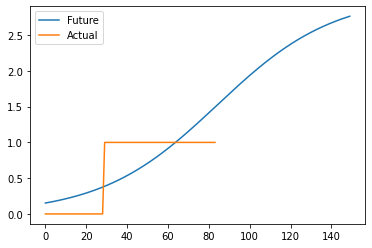

Zhejiang hopefully good


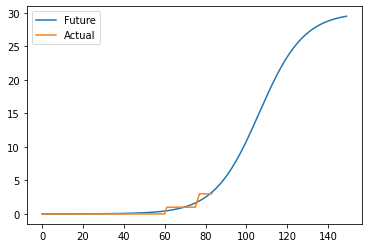

Zimbabwe hopefully good


In [18]:
# Fatalities
for cname in cnames:
    try:
        norm, model = fatmodels[cname]
        x = list(xbycountry[cname])
        del plt

        import matplotlib.pyplot as plt

        plotx = np.array([[float(i)] for i in xbycountry[cname]])
        ploty_actual = np.array([i[1] for i in ybycountry[cname]])
#         ploty_model = model.predict(np.array([[float(i)] for i in xbycountry[cname]]))*norm

        futureplotx = np.array(list([i] for i in range(150)))
#         futurex = np.array([[float(i/70)] + x[1:] for i in range(150)])
        futurey = model.predict(futureplotx)*norm

        plt.plot(futureplotx, futurey, label="Future")
        plt.plot(plotx, ploty_actual, label="Actual")
        # plt.plot(plotx, ploty_model, label="Model")

        plt.legend()
        plt.show()
        print(f"{cname} hopefully good")
    except KeyError:
        print(f"{cname} is not a country")

In [19]:
!rm /kaggle/working/submission.csv
stuff = []
with open("/kaggle/working/submission.csv", 'a+') as fout:
    fout.write("ForecastId,ConfirmedCases,Fatalities\n")
    for i, p in enumerate(ptest.to_numpy()):
        cname = p[1] if type(p[1]) is str else p[2]
        casenorm, casemodel = deepcopy(casemodels[cname])
        fatnorm, fatmodel = deepcopy(fatmodels[cname])
        date = dateToInt(p[3])
        cases = casemodel.predict(np.array([[date]]))[0]*casenorm
        fatalities = fatmodel.predict(np.array([[date]]))[0]*fatnorm
        print(i + 1, round(cases), round(fatalities), sep=',', file=fout)
#         stuff.append((i+1, predictions[0]))
# print(len(stuff))

rm: cannot remove '/kaggle/working/submission.csv': No such file or directory


Who needs ``pd.write_csv()`` NOOBS

# Please UPVOTE if you found this helpful